# Analysis notebook:

Manuscript: AF2χ: predicting protein side-chain rotamer distributions with AlphaFold2

Authors: Matteo Cagiada / F. Emil Thomasen

This notebook covers data and analysis for manuscript figures and tables:

- Fig 3
- Fig S5
- Fig S7
- Fig S8
- Fig S9

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import os
from scipy.stats import circmean,circstd
from scipy.spatial.distance import jensenshannon
import glob as glob

In [2]:
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

In [3]:
def rot_pop_rebinned_to_three(input_distr):
    assert len(input_distr) == 36, "not correct length"

    return [np.sum(input_distr[0:12]),np.sum(input_distr[12:24]),np.sum(input_distr[24:36])]


In [4]:
def adjust_period_angle(angle):
    while angle < 0:
        angle += 360
    while angle >= 360:
        angle -= 360
    return angle

def gaussian(x, a, mu, sigma):
    y = a * 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-0.5*(np.square(x-mu)/np.square(sigma)))
    return y

In [5]:
def circmean_weighted(angles, weights=None):
    if weights is None:
        weights = np.array([1]*len(angles))

    weights_norm = weights/np.sum(weights)

    if np.all(weights_norm == weights_norm[0]):
        sin_avg = 0
        cos_avg = 0
    else:
        sin_avg = np.sum(weights_norm*np.sin(angles))
        cos_avg = np.sum(weights_norm*np.cos(angles))
    angle_avg = np.arctan2(sin_avg, cos_avg)

    return angle_avg

In [6]:
def plot_boxplot_with_points(*args, colors=None,labels=None, title=None,ylabel=r'$JS_{div}$',ylimit=1,width=10,height=5,labelsize=22):
    """
    Plots a boxplot with raw points underneath for each list passed.
    
    Parameters:
        *args: Each argument is a list or array of points.
        labels (list): Optional, a list of labels corresponding to each series.
        title (str): Optional, title for the plot.
    """

    PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k','linewidth':2.},
    'medianprops':{'color':'k','linewidth':2.},
    'whiskerprops':{'color':'k','linewidth':2.},
    'capprops':{'color':'k'}
    }
    
    # Create the figure and axis
    plt.figure(figsize=(width, height))
    meanprops = {'color': 'red', 'linewidth': 20}
    # Plot the boxplot
    sns.boxplot(data=args, width=0.2,showmeans=True, meanprops=meanprops,**PROPS)

    for i, data in enumerate(args):
        # Add jitter to avoid points overlapping
        x = np.random.normal(i+0.3, 0.04, size=len(data))

        # Plot the raw data points
        if colors:
            for j, (x_val, y_val) in enumerate(zip(x, data)):
                plt.scatter(x_val, y_val, color=colors[j], alpha=0.7,edgecolor='w',s=75)
        else:
            plt.plot(x, data, 'r.', alpha=0.5)
    plt.ylim(-0.01,ylimit)
    plt.yticks([0.,0.2,0.4,0.6,0.8,1.0],fontsize=labelsize)
    plt.ylabel(ylabel,fontsize=labelsize)
    plt.grid(axis='y',alpha=0.2,zorder=-200)
    # Add labels if provided
    if labels:
        plt.xticks(range(len(args)), labels,fontsize=labelsize)
    
    # Add title if provided
    if title:
        plt.title(title)

In [7]:
def plot_boxplot(*args, labels=None, title=None,box_color='#d55c00',width=10,height=5):
    """
    Plots a boxplot with raw points underneath for each list passed.
    
    Parameters:
        *args: Each argument is a list or array of points.
        labels (list): Optional, a list of labels corresponding to each series.
        title (str): Optional, title for the plot.
    """
    PROPS = {
    'boxprops':{'facecolor':box_color, 'edgecolor':'k','linewidth':2.},
    'medianprops':{'color':'k','linewidth':2.},
    'whiskerprops':{'color':'k','linewidth':2.},
    'capprops':{'color':'k'}
    }
    
    # Create the figure and axis
    plt.figure(figsize=(width, height))
    meanprops = {'color': 'red', 'linewidth': 20}

    # Plot the boxplot
    sns.boxplot(data=args, width=0.2,showmeans=True,**PROPS)
    plt.ylim(-0.01,1)
    plt.ylabel(r'$JS_{div}$')
    # Add labels if provided
    if labels:
        plt.xticks(range(len(args)), labels)
    
    # Add title if provided
    if title:
        plt.title(title)

## global var

In [8]:
top8000_prior=pd.read_csv('../data/extra_data/Top8000_rebinned_all_chi_distributions.csv', index_col=0)

In [9]:
dihedral_angles=[10*i for i in range(36)]

## UBQ

In [10]:
ubq_seq="MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG"

In [11]:
keys_chi1=[]
for idx,letter in enumerate(ubq_seq):
    keys_chi1.append(alphabetAA_1L_3L[letter].upper()+str(idx+1))

### load target 

In [12]:
angles_vs_chitype={}
angles_std_vs_chitype={}

chis_target = np.load(glob.glob(f'../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/output/1UBI_1_Chain_A_UBIQUITIN_Homo_sapiens__9606__rank_001_sc_angles.npy')[0])
chi_names={1:'chi1',2:'chi2'}
for chi_type in range(1,3):
        angles=[]
        angles_std=[]
        angles_lastlayer=[]
        for k in range(chis_target.shape[1]):
            angles.append(circmean(np.arctan2(chis_target[1:-1,k,chi_type+2,0],chis_target[1:-1,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))
            angles_std.append(circstd(np.arctan2(chis_target[1:-1,k,chi_type+2,0],chis_target[1:-1,k,chi_type+2,1]).astype(np.float64),low=0,high=2*np.pi))

        angles = np.array(angles)
        angles_std = np.array(angles_std)

        angles_vs_chitype[chi_names[chi_type]] = angles
        angles_std_vs_chitype[chi_names[chi_type]] = angles_std


### load all chis prior

In [13]:
with open('../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/output/1UBI_1_Chain_A_UBIQUITIN_Homo_sapiens__9606__rank_001_sc_pops_priori.json') as json_in:
    all_chis_priori=json.load(json_in)

### load all chis posterior

In [14]:
with open('../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/output/1UBI_1_Chain_A_UBIQUITIN_Homo_sapiens__9606__rank_001_sc_pops_fitted.json') as json_in:
    all_chis_fitted=json.load(json_in)

### load all pdb ensemble

In [15]:
with open('../data/struct_data/ubq__pdbs_chis_seqid99.json') as json_in:
    all_chis_pdb_ensemble=json.load(json_in)

### load MD

In [16]:
with open('../data/MD_data/MD_charmm36m/UBQ_chis.pkl','rb') as pkl_in:
    all_chis_MD_ensemble=pickle.load(pkl_in)

### load 1xqq

In [17]:
with open('../data/struct_data/1xqq_allchis.json','rb') as json_in:
    all_chis_1xqq_ensemble=json.load(json_in)

## Comparisons

In [18]:
x=[i for i in range(5,360,10)]
x_range=[i for i in range(0,365,10)]
print(len(x_range),len(x))

37 36


### chi1

In [19]:
chi_sel='chi1'

In [20]:
pdb_ensemble_angles=all_chis_pdb_ensemble[chi_sel]

prior_distributions=all_chis_priori[chi_sel]

reweighted_distributions=all_chis_fitted[chi_sel]

MD_ensemble_angles=all_chis_MD_ensemble[chi_sel]

pdb_1xqq_ensemble_angles= all_chis_1xqq_ensemble[chi_sel]

In [21]:
layer_chi=3
angles_collected=[]

input_file='../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/output/1UBI_1_Chain_A_UBIQUITIN_Homo_sapiens__9606__rank_001_sc_angles.npy'

angles_npy=np.load(input_file,allow_pickle=True)

angles_appended=(circmean(np.arctan2(angles_npy[-1][:,layer_chi,0],angles_npy[-1][:,layer_chi,1]).reshape(-1,1),low=0,high=2*np.pi,axis=1))
angles_appended=np.array(angles_appended)

In [22]:
struct_angles={}
struct_distributions={}
for res in pdb_ensemble_angles.keys():
    struct_angles[res]=np.rad2deg(angles_appended[int(res[3:])-1])
    struct_distributions[res]= gaussian(dihedral_angles, 10, struct_angles[res] ,1.25)

In [23]:
pdb_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_ensemble_angles[key]]
    
    pdb_ensemble_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [24]:
for key in pdb_ensemble_angles_distr.keys():
    if len(pdb_ensemble_angles_distr[key]) <10:
        print(key)

In [25]:
MD_ensemble_angles_distr={}

for key in MD_ensemble_angles.keys():
    
    MD_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in MD_ensemble_angles[key]]
    
    MD_ensemble_angles_distr[key]=np.histogram(MD_degr_conv,bins=x_range)[0]/len(MD_degr_conv)

In [26]:
pdb_1xqq_ensemble_angles_distr={}

for key in pdb_1xqq_ensemble_angles.keys():
    
    pdb_1xqq_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_1xqq_ensemble_angles[key]]
    
    pdb_1xqq_ensemble_angles_distr[key]=np.histogram(pdb_1xqq_degr_conv,bins=x_range)[0]/len(pdb_1xqq_degr_conv)

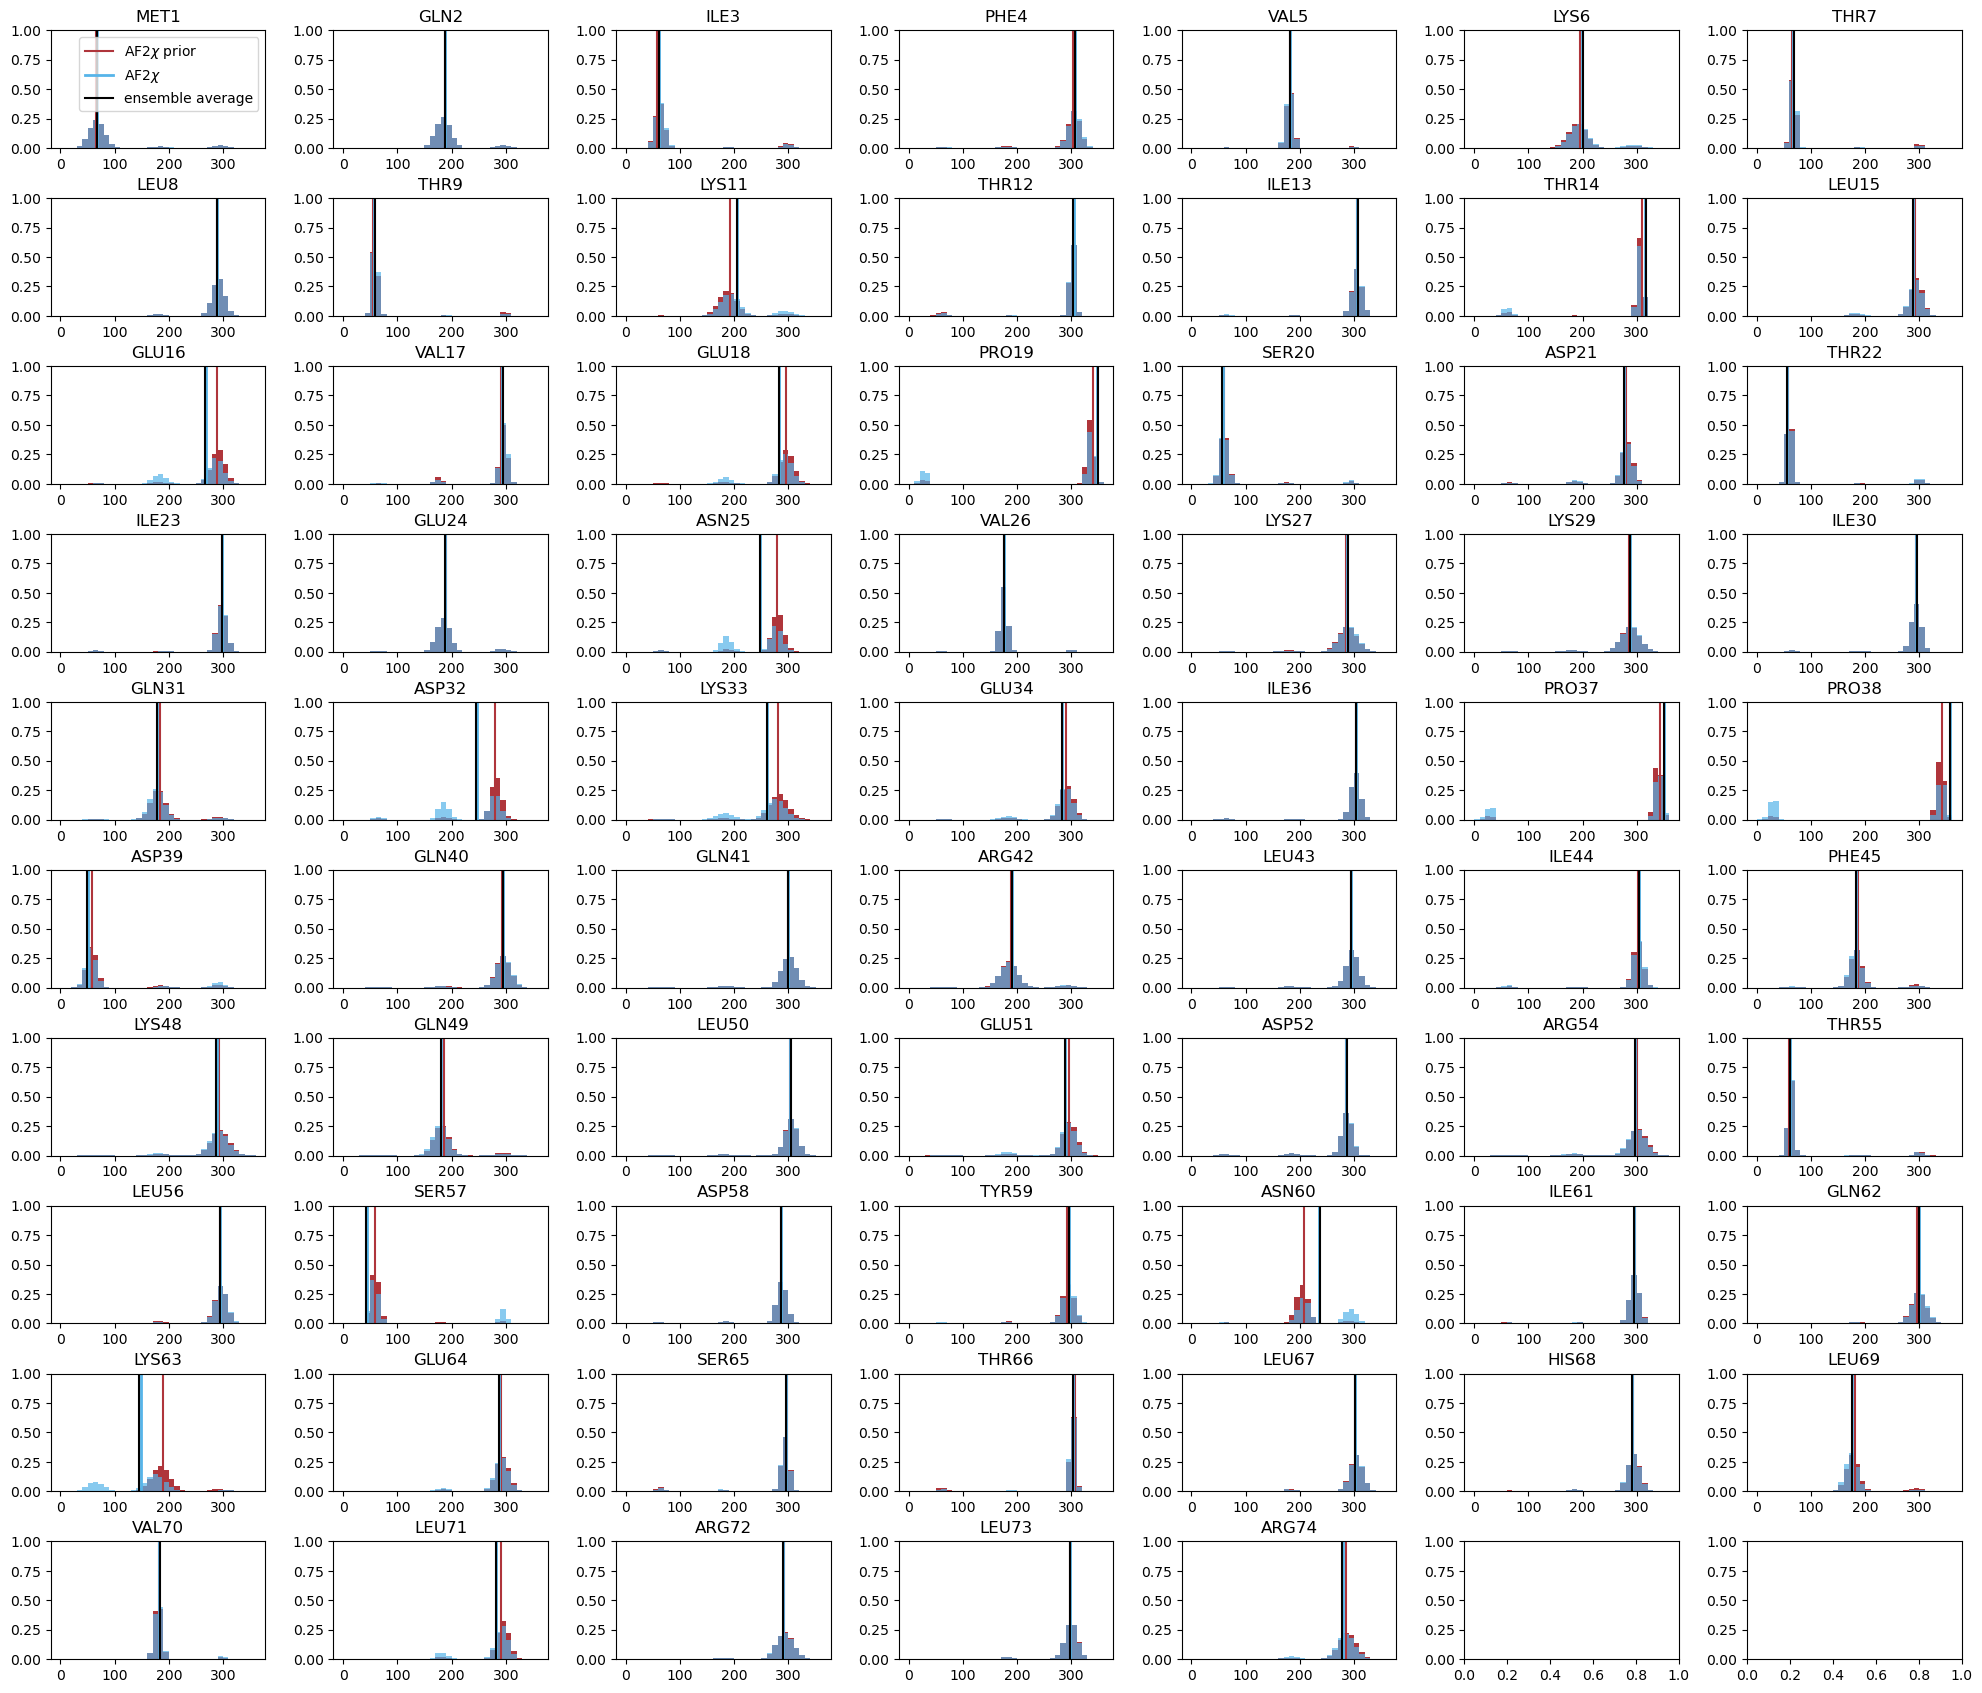

In [27]:
#### Fig S5

x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(10,7,figsize=(20,17))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
colors=['#56b4e9','#d55c00','#009e74','#f0e442','#000fff']
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=1)
            axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',label=r'AF2$\chi$ prior')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=2,label=r'AF2$\chi$')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(angles_vs_chitype[chi_sel][int(res[3:])-1])), color='k',label='ensemble average')

            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1
axs[0].legend()
plt.savefig('../figures/ubq_prior_vs_target_rewerighting.pdf',dpi=500)

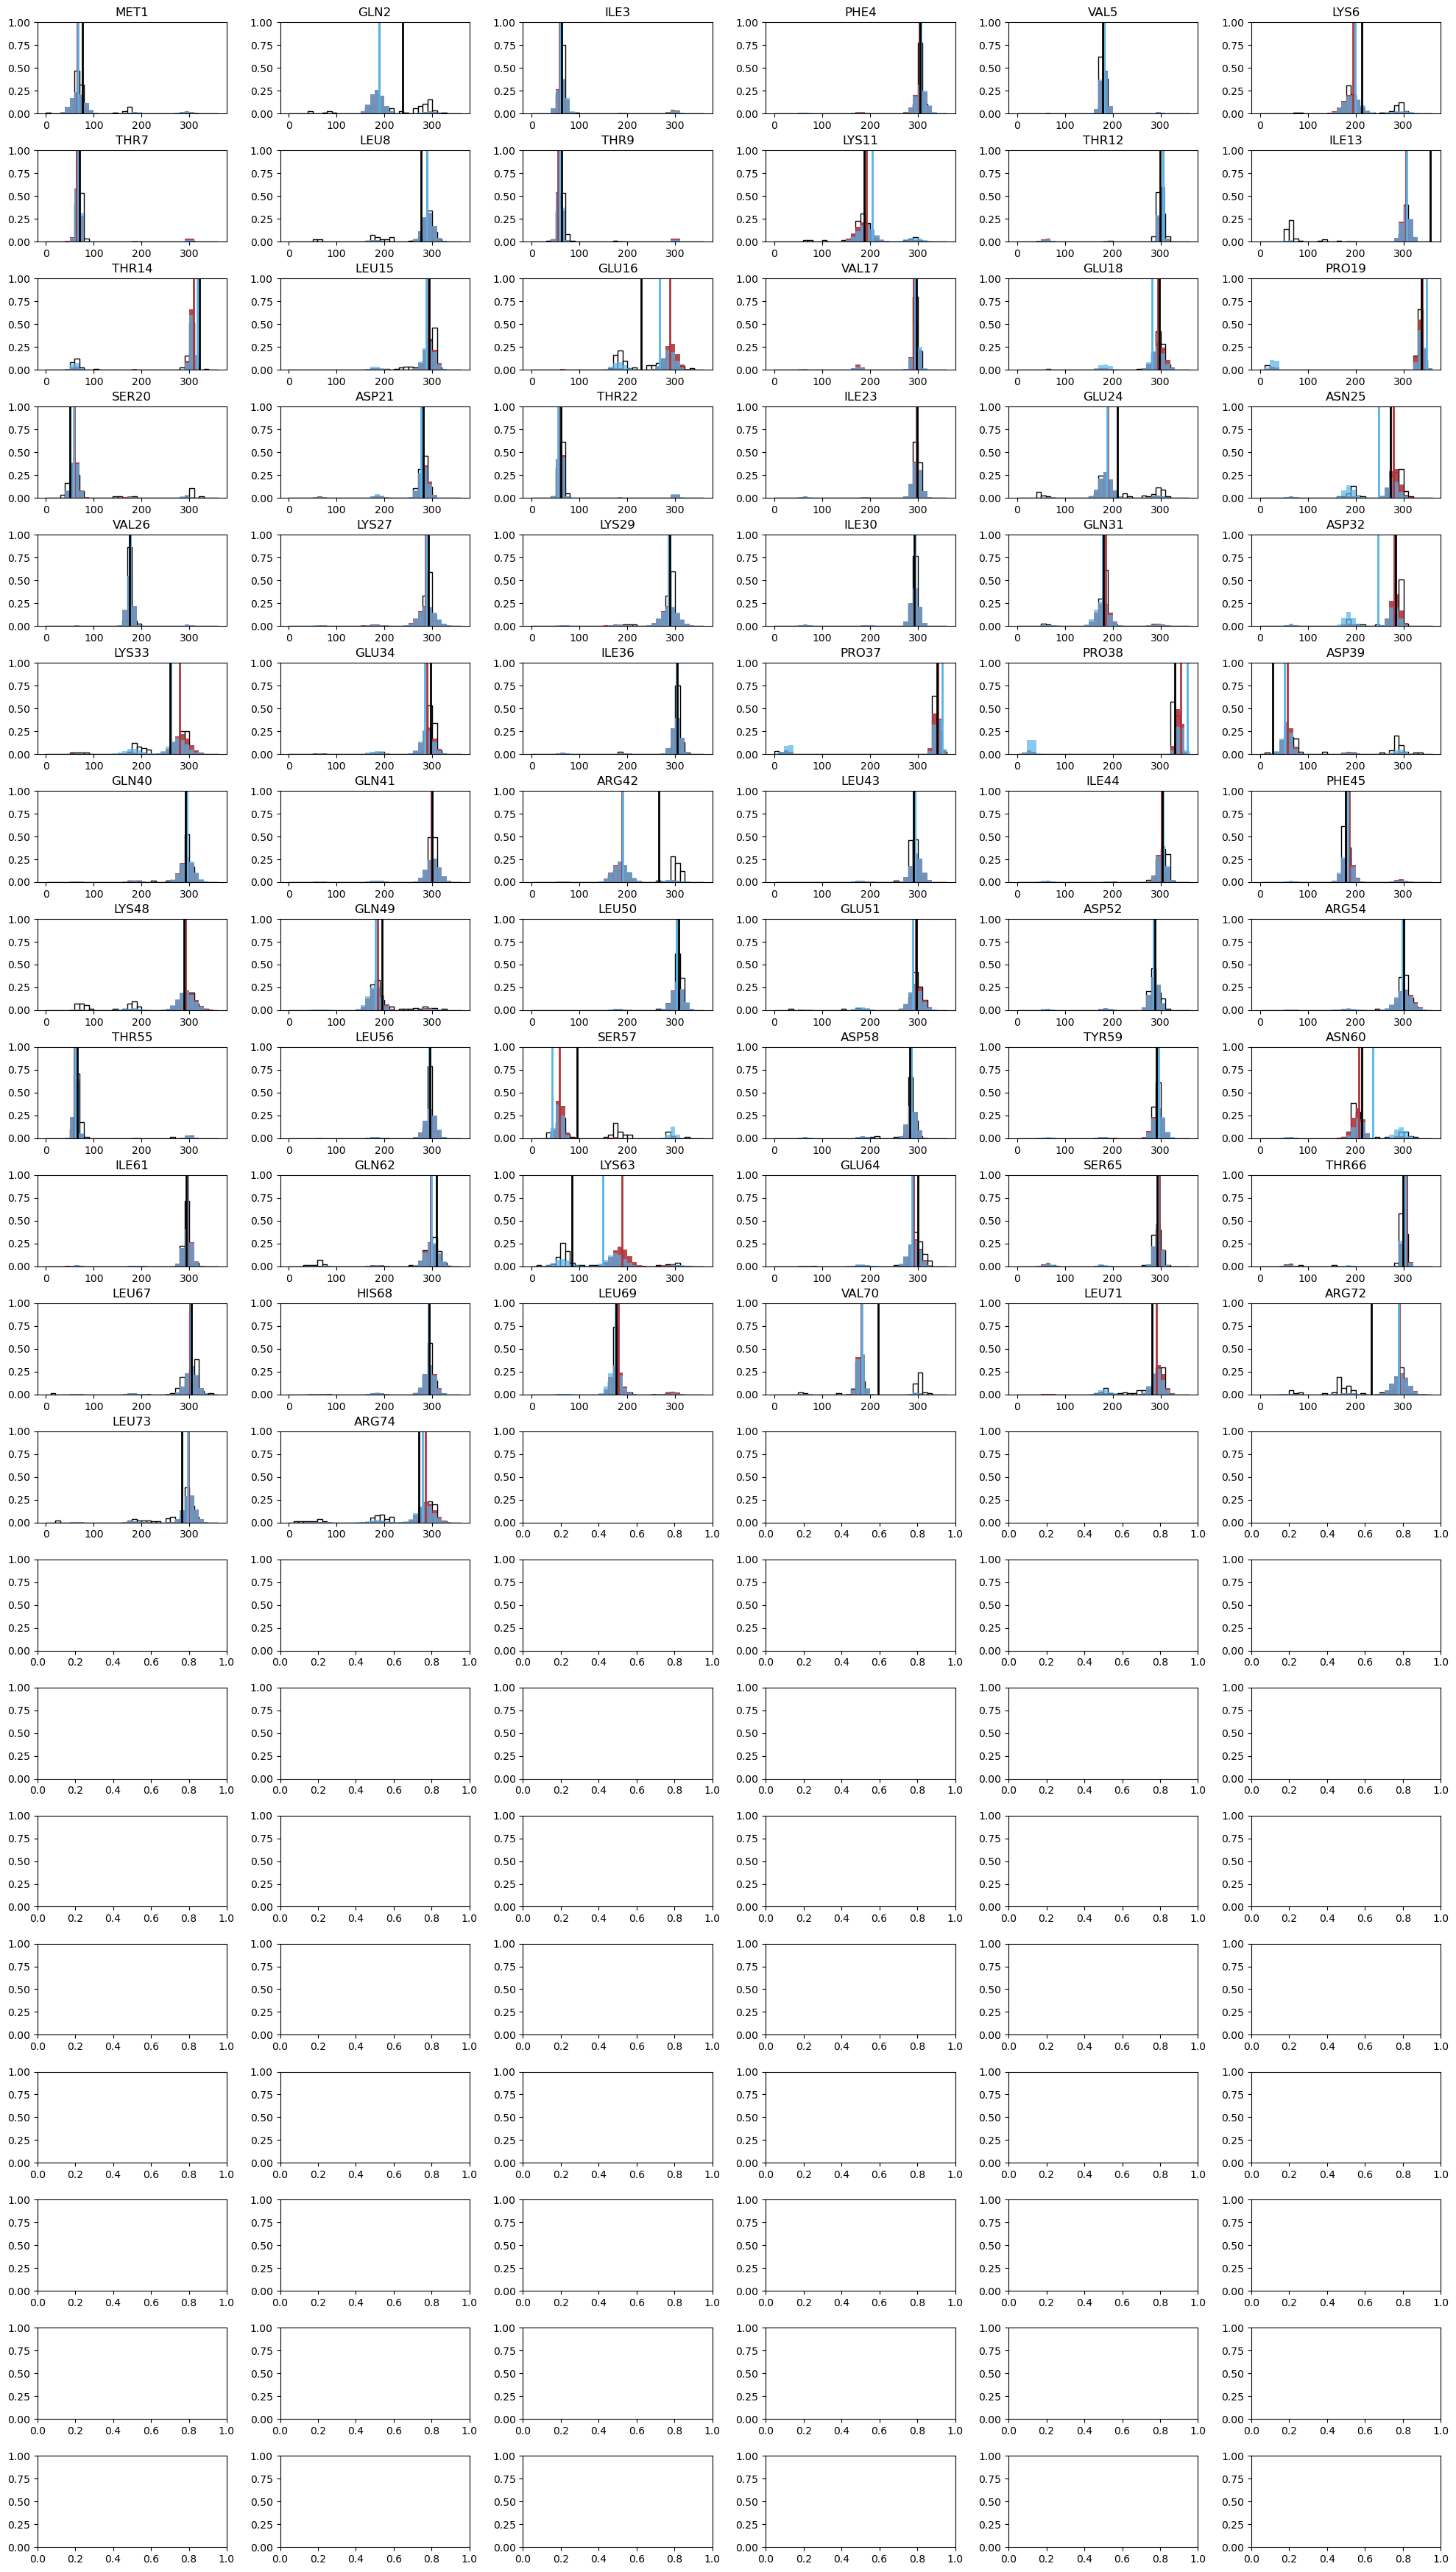

In [28]:
## all residues 
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(20,6,figsize=(20,35))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
            axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=2)


            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/ubq_rewe_vs_prior_on_pdb_ensemble.pdf',dpi=500)

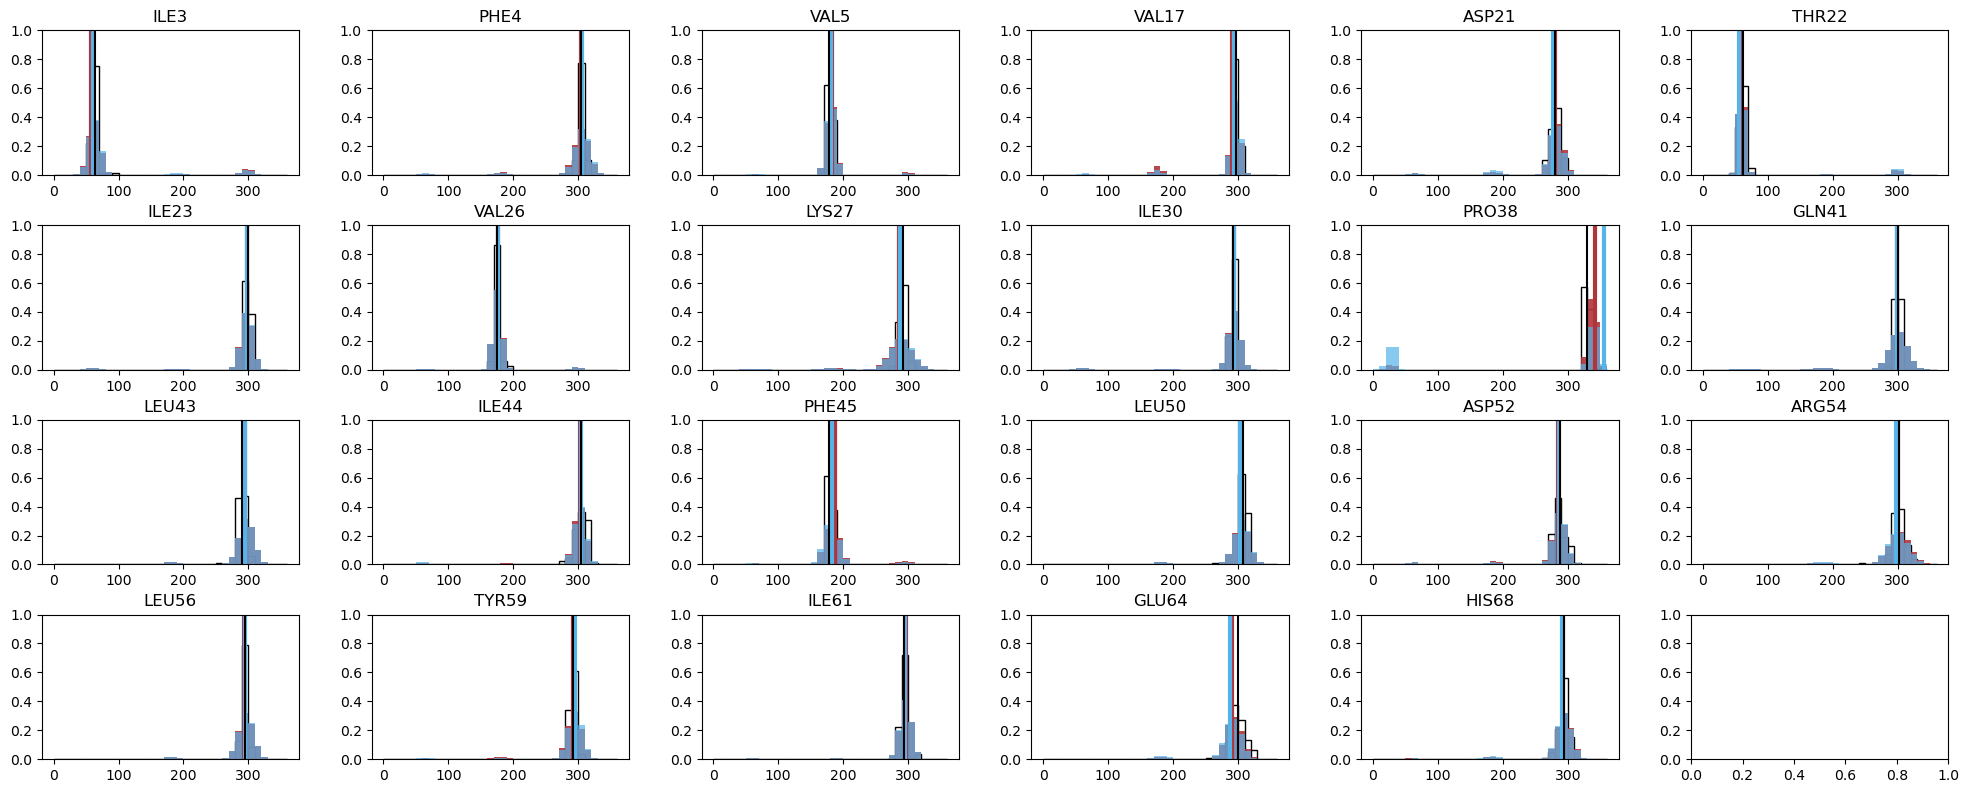

In [29]:
### Fig S6a -- only fixed 

x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(4,6,figsize=(20,8))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)

is_fixed={}


for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True
            

for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            if is_fixed[res]:
                axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
                axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
                axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
                
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=3)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=3)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=1.5)
    
    
                axs[idx_ax].set_ylim(0,1)
                axs[idx_ax].set_title(res)
                
                idx_ax+=1

plt.savefig('../figures/ubq_rewe_vs_prior_on_pdb_ensemble_fixed.pdf',dpi=500)

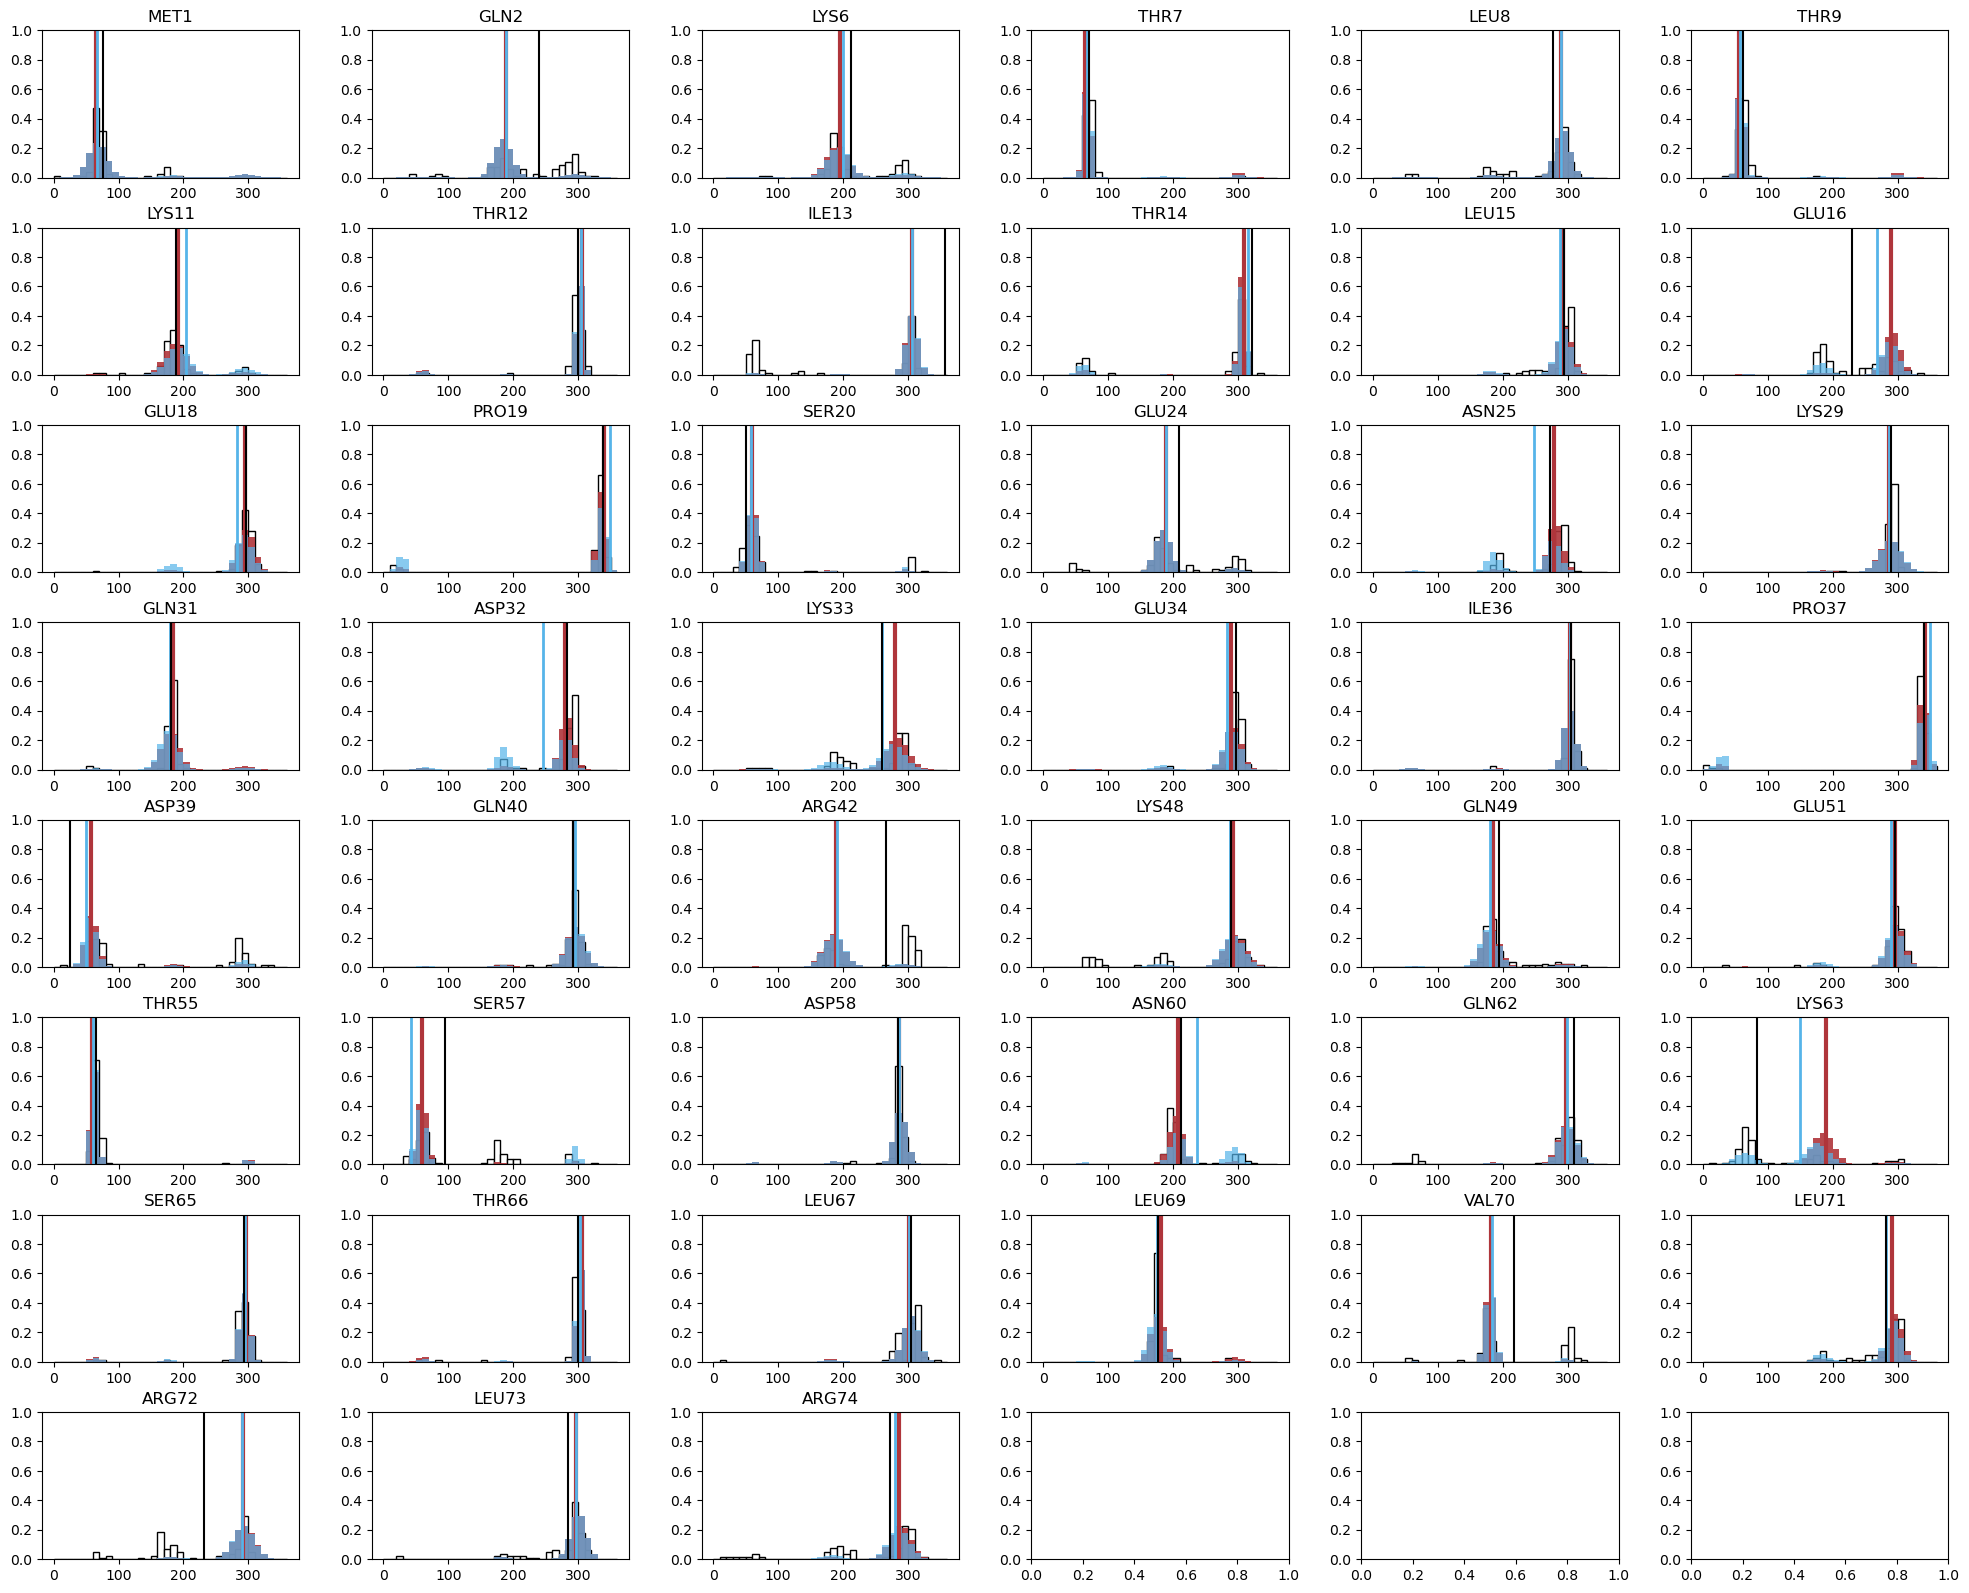

In [30]:
### Fig S6a -- only multi

x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(8,6,figsize=(20,16))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)

is_fixed={}


for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True
            

for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            if not is_fixed[res]:
                axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
                axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
                axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
                
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=3)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=2)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=1.5)
    
    
                axs[idx_ax].set_ylim(0,1)
                axs[idx_ax].set_title(res)
                
                idx_ax+=1

plt.savefig('../figures/ubq_rewe_vs_prior_on_pdb_ensemble_multi.pdf',dpi=500)

In [31]:
js_re=[]
js_prior=[]
js_top8000=[]
js_af2=[]
js_MD=[]
js_1xqq=[]

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        js_MD.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_1xqq.append(jensenshannon(pdb_1xqq_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_re.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
        js_prior.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
        js_top8000.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
        js_af2.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

In [32]:
is_fixed={}

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True

js_re_fixed=[]
js_MD_fixed=[]
js_1xqq_fixed=[]
js_prior_fixed=[]
js_top8000_fixed=[]
js_af2_fixed=[]

js_re_multi=[]
js_MD_multi=[]
js_1xqq_multi=[]
js_prior_multi=[]
js_top8000_multi=[]
js_af2_multi=[]

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        if is_fixed[res]:
            js_MD_fixed.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_1xqq_fixed.append(jensenshannon(pdb_1xqq_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_re_fixed.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
            js_prior_fixed.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
            js_top8000_fixed.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
            js_af2_fixed.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

        else:
            js_MD_multi.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_1xqq_multi.append(jensenshannon(pdb_1xqq_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_re_multi.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
            js_prior_multi.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
            js_top8000_multi.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
            js_af2_multi.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))


In [33]:
print('All(tot: ',len(js_top8000))
print('js_af2 - sum:',np.sum(js_af2),' mean: ', np.mean(js_af2),'std', np.std(js_af2))
print('js_top8000 - sum:',np.sum(js_top8000),' mean: ', np.mean(js_top8000),'std', np.std(js_top8000))
print('js_prior - sum:',np.sum(js_prior),' mean: ', np.mean(js_prior),'std', np.std(js_prior))
print('js_re - sum:',np.sum(js_re),' mean: ', np.mean(js_re),'std', np.std(js_re))
print('js_MD - sum:',np.sum(js_MD),' mean: ', np.mean(js_MD),'std', np.std(js_MD))
print('js_1xqq - sum:',np.sum(js_1xqq),' mean: ', np.mean(js_1xqq),'std', np.std(js_1xqq))

All(tot:  68
js_af2 - sum: 39.06407456530147  mean:  0.5744716847838451 std 0.13430556024963144
js_top8000 - sum: 32.04659590370407  mean:  0.4712734691721187 std 0.10637739697226514
js_prior - sum: 23.249074887851336  mean:  0.3418981601154608 std 0.08712601880430014
js_re - sum: 23.373798270327974  mean:  0.34373232750482313 std 0.08199944528723892
js_MD - sum: 25.03294398724981  mean:  0.3681315292242619 std 0.09821568860630087
js_1xqq - sum: 24.39781415046017  mean:  0.35879138456559073 std 0.09155210184960169


In [34]:
print('Fixed (tot: ',len(js_top8000_fixed))
print('js_af2 - sum:',np.sum(js_af2_fixed),' mean: ', np.mean(js_af2_fixed),'std', np.std(js_af2_fixed))
print('js_top8000 - sum:',np.sum(js_top8000_fixed),' mean: ', np.mean(js_top8000_fixed),'std', np.std(js_top8000_fixed))
print('js_prior - sum:',np.sum(js_prior_fixed),' mean: ', np.mean(js_prior_fixed),'std', np.std(js_prior_fixed))
print('js_re - sum:',np.sum(js_re_fixed),' mean: ', np.mean(js_re_fixed),'std', np.std(js_re_fixed))
print('js_MD - sum:',np.sum(js_MD_fixed),' mean: ', np.mean(js_MD_fixed),'std', np.std(js_MD_fixed))
print('js_1xqq - sum:',np.sum(js_1xqq_fixed),' mean: ', np.mean(js_1xqq_fixed),'std', np.std(js_1xqq_fixed))

Fixed (tot:  23
js_af2 - sum: 12.781615194100329  mean:  0.5557223997434926 std 0.15015209208477187
js_top8000 - sum: 12.412324506839727  mean:  0.5396662829060751 std 0.07566932121188288
js_prior - sum: 7.764921136543375  mean:  0.3376052668062337 std 0.08049181107454408
js_re - sum: 7.900690978686504  mean:  0.34350830342115235 std 0.08920104101100922
js_MD - sum: 8.107724463363216  mean:  0.35250975927666156 std 0.11547534278229594
js_1xqq - sum: 7.91267450332152  mean:  0.3440293262313704 std 0.08758322506947328


In [35]:
print('Multi (tot: ',len(js_top8000_multi))
print('js_af2 - sum:',np.sum(js_af2_multi),' mean: ', np.mean(js_af2_multi),'std', np.std(js_af2_multi))
print('js_top8000 - sum:',np.sum(js_top8000_multi),' mean: ', np.mean(js_top8000_multi),'std', np.std(js_top8000_multi))
print('js_prior- sum:',np.sum(js_prior_multi),' mean: ', np.mean(js_prior_multi),'std', np.std(js_prior_multi))
print('js_re - sum:',np.sum(js_re_multi),' mean: ', np.mean(js_re_multi),'std', np.std(js_re_multi))
print('js_MD - sum:',np.sum(js_MD_multi),' mean: ', np.mean(js_MD_multi),'std', np.std(js_MD_multi))
print('js_1xqq - sum:',np.sum(js_1xqq_multi),' mean: ', np.mean(js_1xqq_multi),'std', np.std(js_1xqq_multi))

Multi (tot:  45
js_af2 - sum: 26.28245937120114  mean:  0.5840546526933587 std 0.12434853288164405
js_top8000 - sum: 19.634271396864346  mean:  0.436317142152541 std 0.10276531966414518
js_prior- sum: 15.48415375130796  mean:  0.34409230558462134 std 0.09025004753804562
js_re - sum: 15.473107291641465  mean:  0.34384682870314365 std 0.0780622370068544
js_MD - sum: 16.925219523886597  mean:  0.37611598941970215 std 0.08702150000030784
js_1xqq - sum: 16.48513964713866  mean:  0.3663364366030813 std 0.09261134750631467


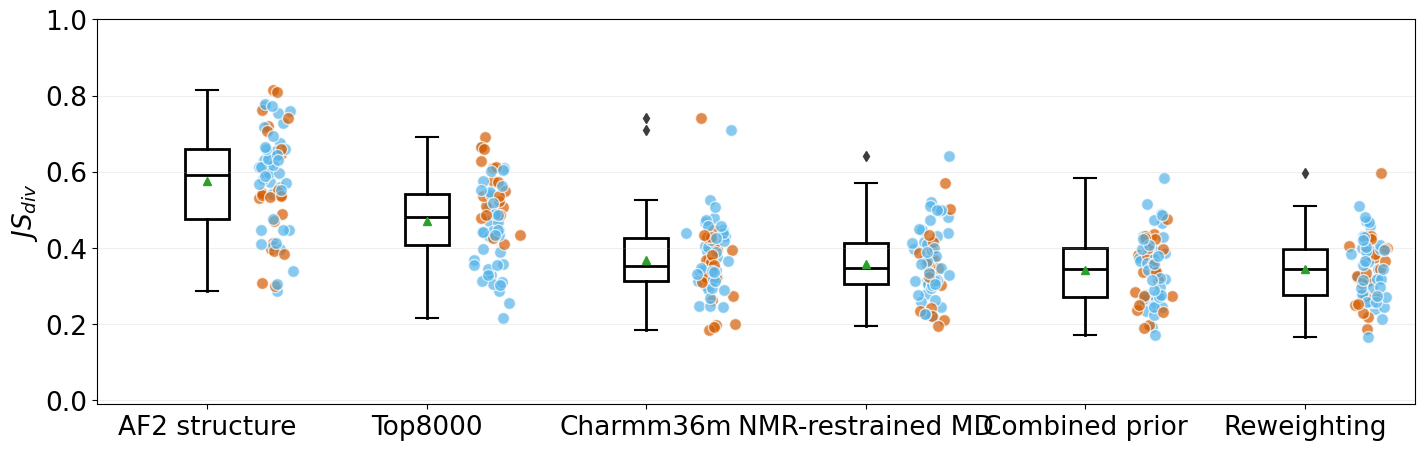

In [36]:
#### fig 3a

plot_boxplot_with_points(js_af2,js_top8000,js_MD,js_1xqq,js_prior,js_re,labels=['AF2 structure','Top8000','Charmm36m','NMR-restrained MD','Combined prior','Reweighting'],
                         colors=['#d55c00' if val else '#56b4e9' for val in list(is_fixed.values())],width=17,labelsize=19)
plt.savefig('../figures/ubq_chi1_js_all_and_ensemble_boxplots_points.pdf')

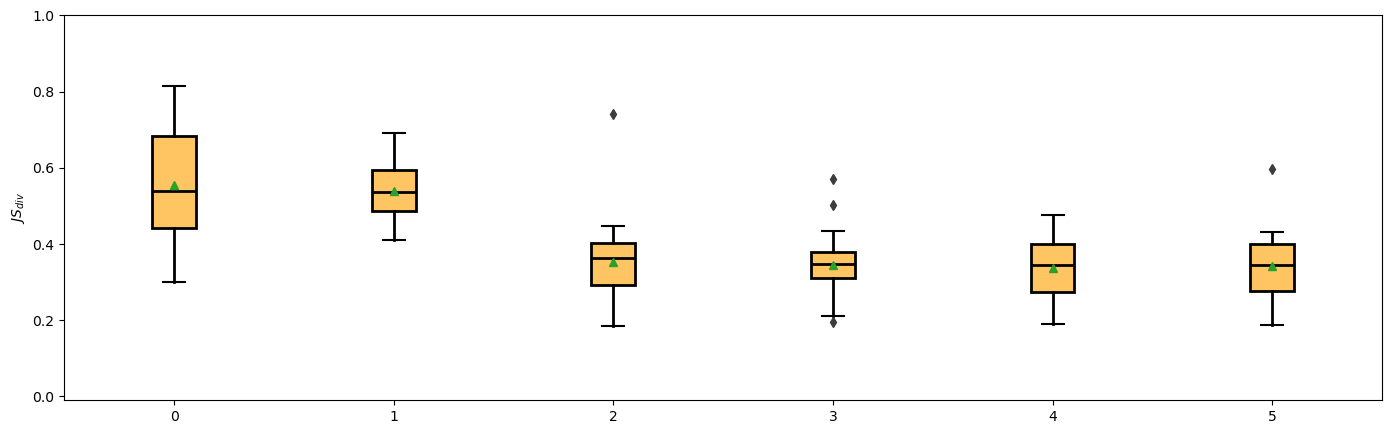

In [37]:
#### fig 3a

plot_boxplot(js_af2_fixed,js_top8000_fixed,js_MD_fixed,js_1xqq_fixed,js_prior_fixed,js_re_fixed,box_color='#ffc563',width=17)
plt.savefig('../figures/ubq_chi1_js_fixed_boxplots_points.pdf')

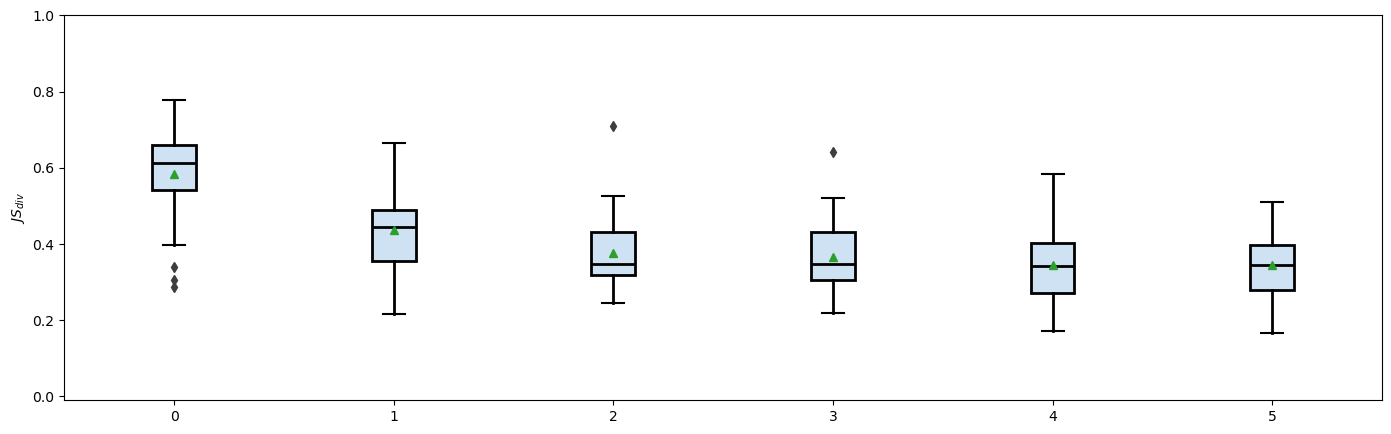

In [38]:
#### fig 3a

plot_boxplot(js_af2_multi,js_top8000_multi,js_MD_multi,js_1xqq_multi,js_prior_multi,js_re_multi,box_color='#cfe2f3',width=17)
plt.savefig('../figures/ubq_chi1_js_multi_boxplots_points.pdf')

### chi2

In [39]:
chi_sel='chi2'

In [40]:
pdb_ensemble_angles=all_chis_pdb_ensemble[chi_sel]

prior_distributions=all_chis_priori[chi_sel]

reweighted_distributions=all_chis_fitted[chi_sel]

MD_ensemble_angles=all_chis_MD_ensemble[chi_sel]

pdb_1xqq_ensemble_angles= all_chis_1xqq_ensemble[chi_sel]

In [41]:
layer_chi=4
angles_collected=[]

input_file='../data/af2chi_data/af2chi_runs_ILDNproteins/UBQ/output/1UBI_1_Chain_A_UBIQUITIN_Homo_sapiens__9606__rank_001_sc_angles.npy'

angles_npy=np.load(input_file,allow_pickle=True)

angles_appended=(circmean(np.arctan2(angles_npy[-1][:,layer_chi,0],angles_npy[-1][:,layer_chi,1]).reshape(-1,1),low=0,high=2*np.pi,axis=1))
angles_appended=np.array(angles_appended)

In [42]:
## remove pro chi2 - not predicted by top8000
pdb_ensemble_angles = {key: value for key, value in pdb_ensemble_angles.items() if 'PRO' not in key}


In [43]:
struct_angles={}
struct_distributions={}
for res in pdb_ensemble_angles.keys():
    struct_angles[res]=np.rad2deg(angles_appended[int(res[3:])-1])
    struct_distributions[res]= gaussian(dihedral_angles, 10, struct_angles[res] ,1.25)

In [44]:
pdb_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_ensemble_angles[key]]
    
    pdb_ensemble_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [45]:
MD_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    MD_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in MD_ensemble_angles[key]]
    
    MD_ensemble_angles_distr[key]=np.histogram(MD_degr_conv,bins=x_range)[0]/len(MD_degr_conv)

In [46]:
pdb_1xqq_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    pdb_1xqq_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_1xqq_ensemble_angles[key]]
    
    pdb_1xqq_ensemble_angles_distr[key]=np.histogram(pdb_1xqq_degr_conv,bins=x_range)[0]/len(pdb_1xqq_degr_conv)

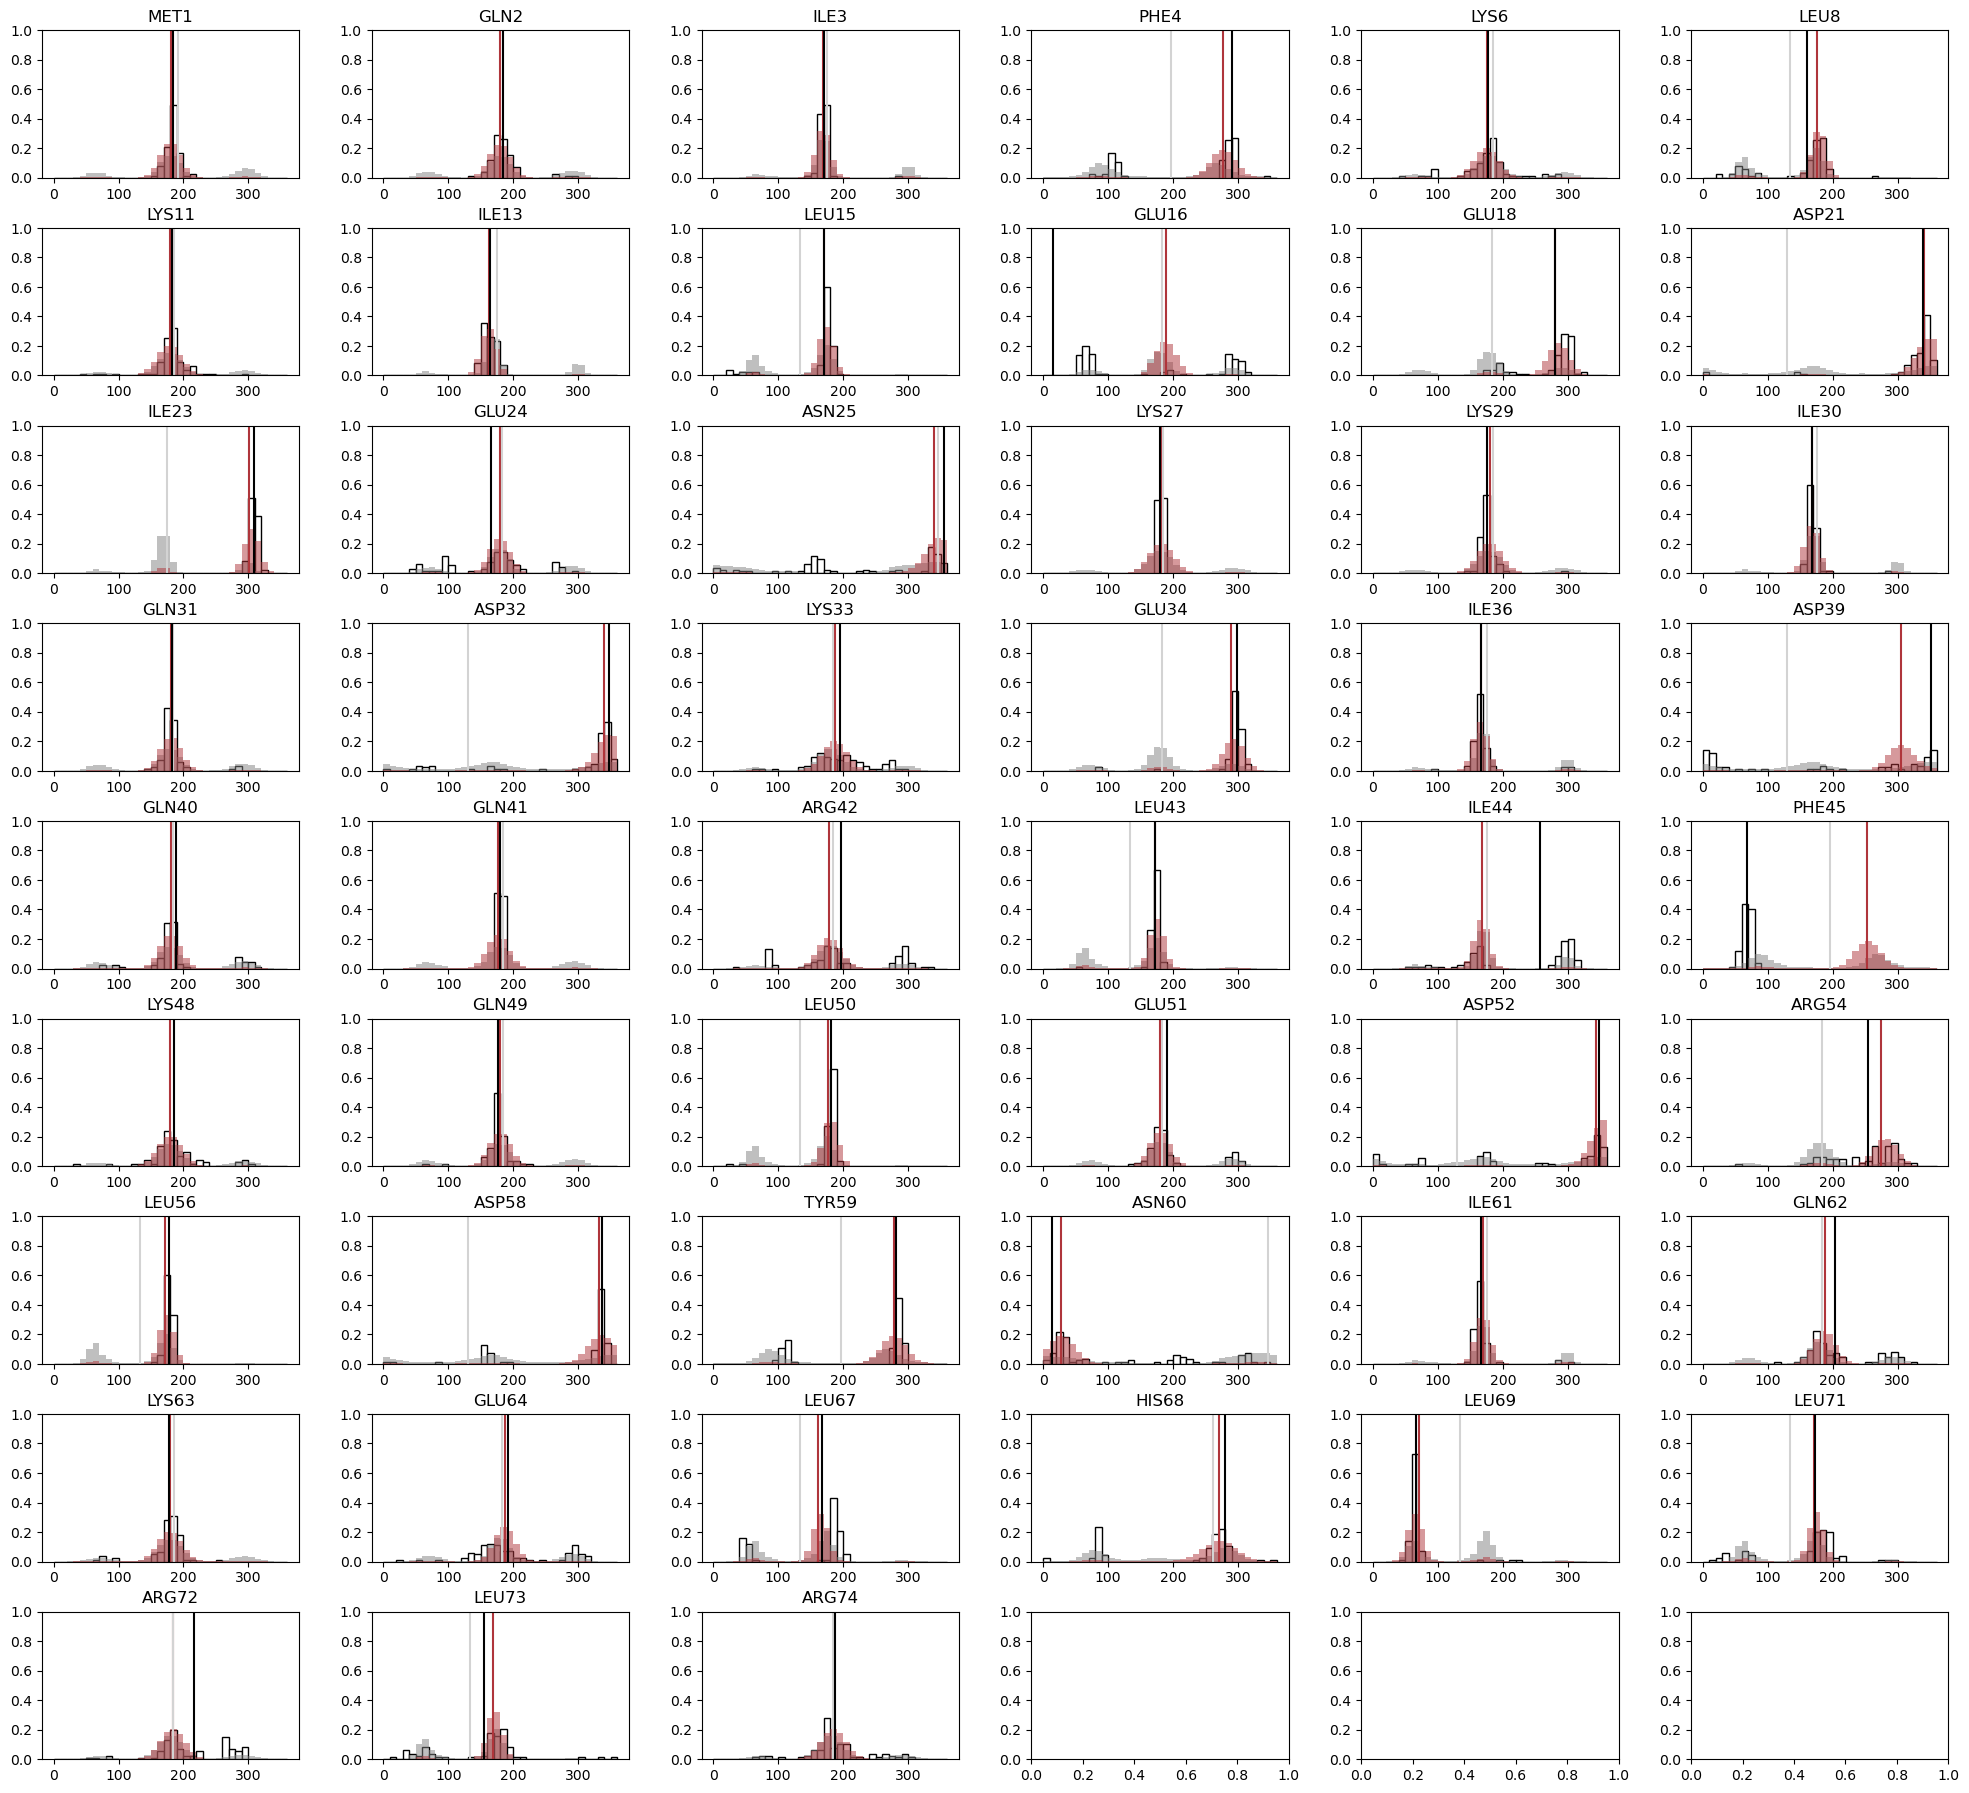

In [47]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(9,6,figsize=(20,18))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
colors=['#56b4e9','#d55c00','#009e74','#f0e442','#000fff']
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.5)
            axs[idx_ax].bar(x,top8000_prior[res[:3]+'_'+chi_sel].values,color='gray',width=10,zorder=-10,alpha=0.5)
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=top8000_prior[res[:3]+'_'+chi_sel].values))), color='lightgray')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k')

            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

# plt.savefig('../figures/ubq_prior_vs_top8000_on_pdb_ensemble_chi2.pdf',dpi=500)

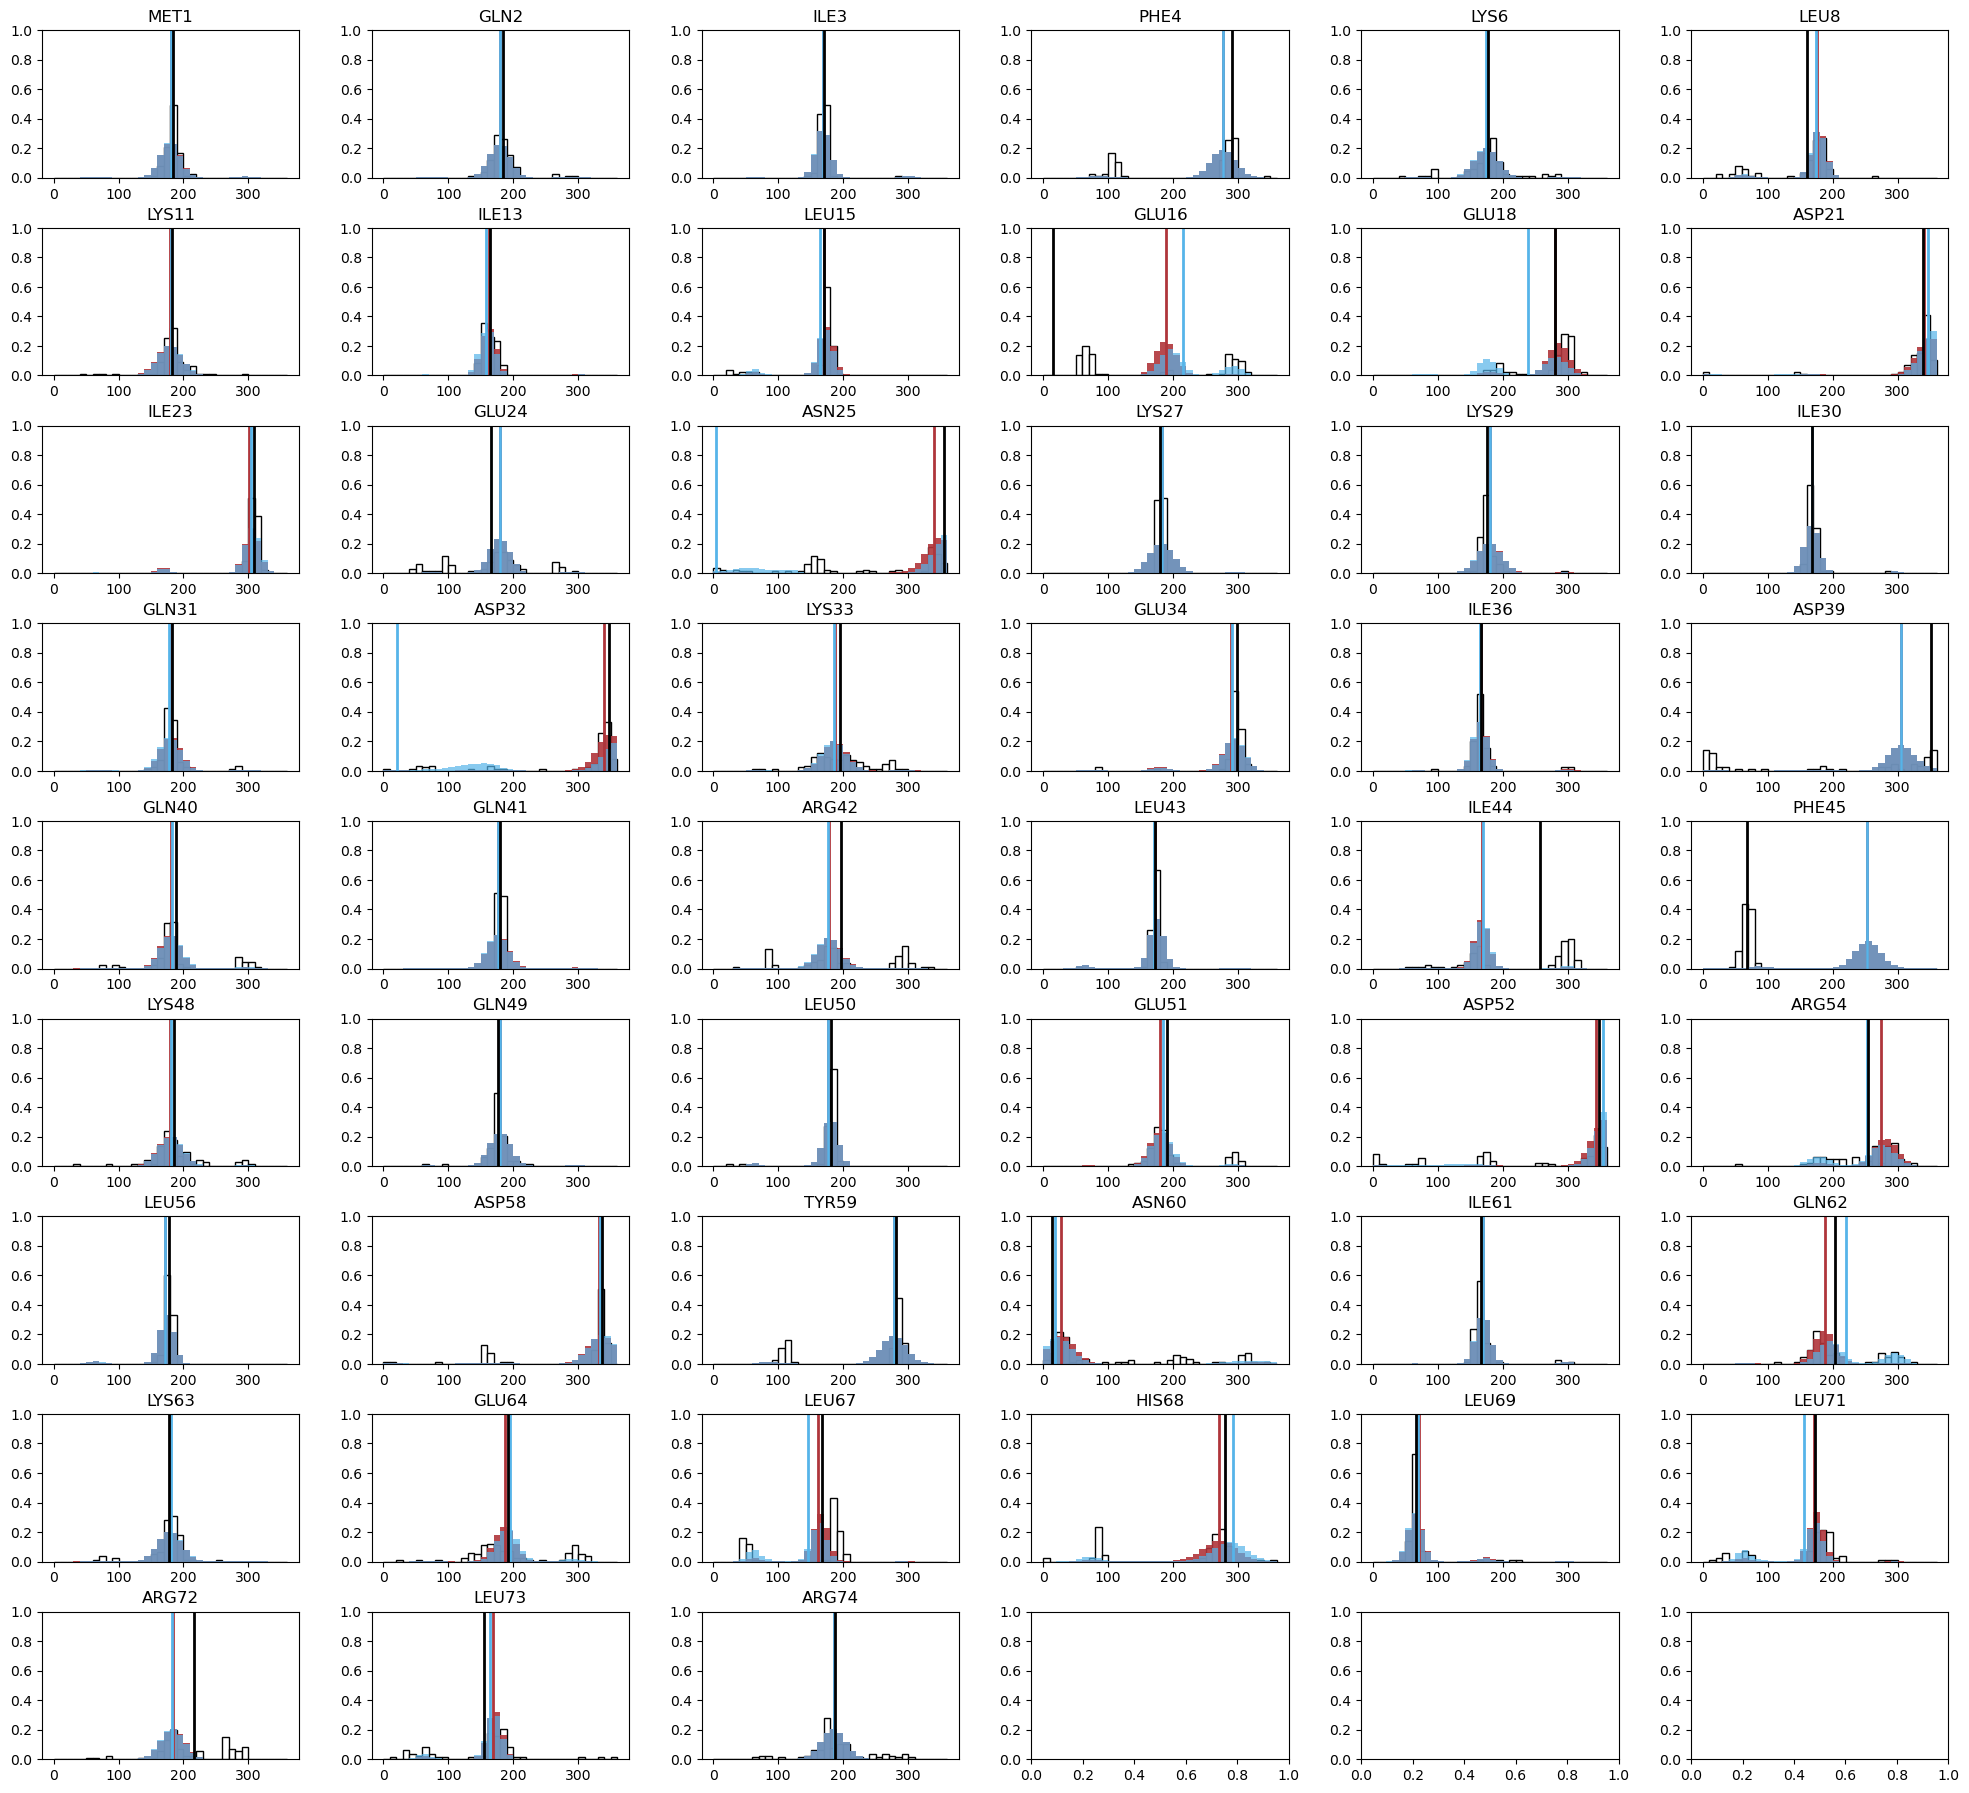

In [48]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(9,6,figsize=(20,18))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
            axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=2)


            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

# plt.savefig('../figures/ubq_rewe_vs_prior_on_pdb_ensemble_chi2.pdf',dpi=500)

In [49]:
js_re=[]
js_prior=[]
js_top8000=[]
js_af2=[]
js_MD=[]
js_1xqq=[]

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        js_MD.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_1xqq.append(jensenshannon(pdb_1xqq_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_re.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
        js_prior.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
        js_top8000.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
        js_af2.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

In [50]:
print('All(tot: ',len(js_top8000))
print('js_af2 - sum:',np.sum(js_af2),' mean: ', np.mean(js_af2),'std',np.std(js_af2))
print('js_top8000 - sum:',np.sum(js_top8000),' mean: ', np.mean(js_top8000),'std',np.std(js_top8000))
print('js_prior - sum:',np.sum(js_prior),' mean: ', np.mean(js_prior),'std',np.std(js_prior))
print('js_re - sum:',np.sum(js_re),' mean: ', np.mean(js_re),'std',np.std(js_re))
print('js_MD - sum:',np.sum(js_MD),' mean: ', np.mean(js_MD),'std',np.std(js_MD))
print('js_1xqq - sum:',np.sum(js_1xqq),' mean: ', np.mean(js_1xqq),'std',np.std(js_1xqq))

All(tot:  51
js_af2 - sum: 31.541812100433614  mean:  0.6184669039300709 std 0.12462438583853928
js_top8000 - sum: 22.898235423985636  mean:  0.44898500831344385 std 0.10913941642566757
js_prior - sum: 19.52124995380695  mean:  0.3827696069373912 std 0.12404386597099495
js_re - sum: 19.605662389380587  mean:  0.3844247527329527 std 0.11962330437237496
js_MD - sum: 22.47466290088521  mean:  0.44067966472323944 std 0.09878003291690808
js_1xqq - sum: 20.914708386765916  mean:  0.4100923213091356 std 0.1322335763120937


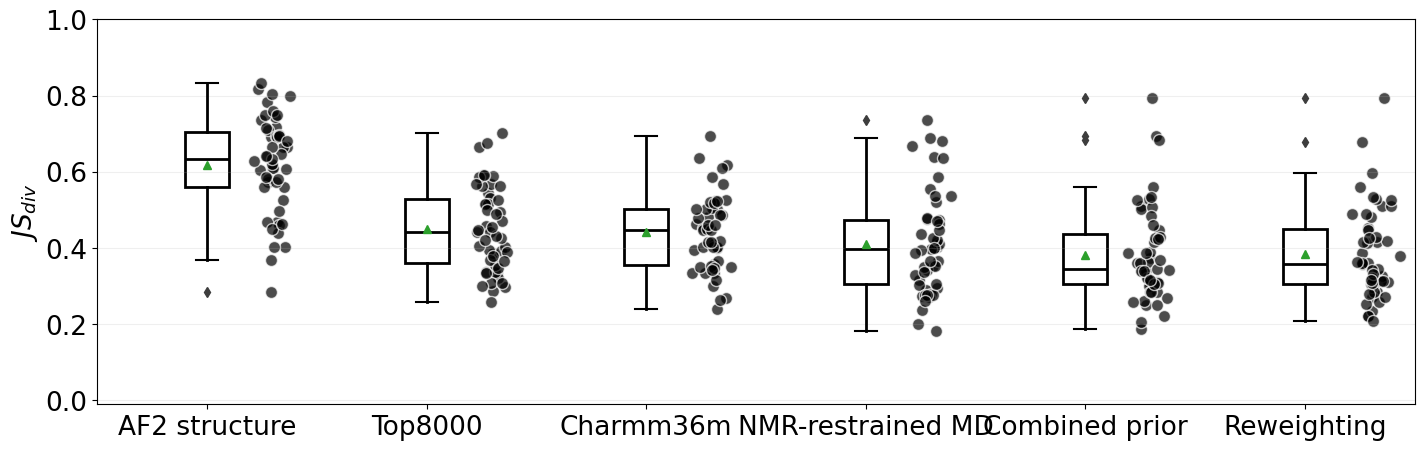

In [51]:
#### Fig 3b


plot_boxplot_with_points(js_af2,js_top8000,js_MD,js_1xqq,js_prior,js_re,labels=['AF2 structure','Top8000','Charmm36m','NMR-restrained MD','Combined prior','Reweighting'],
                         colors=['k' if val else 'k' for val in list(is_fixed.values())],width=17,labelsize=19)
plt.savefig('../figures/ubq_chi2_js_all_and_ensemble_boxplots_points.pdf')

## HEWL


In [52]:
hewl_seq='KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL'

In [53]:
keys_chi1=[]
for idx,letter in enumerate(ubq_seq):
    keys_chi1.append(alphabetAA_1L_3L[letter].upper()+str(idx+1))

### load all chis prior

In [54]:
with open('../data/af2chi_data/af2chi_runs_ILDNproteins/HEWL/output/6LYT_1_Chain_A_HEN_EGG_WHITE_LYSOZYME_Gallus_gallus__9031__rank_001_sc_pops_priori.json') as json_in:
    all_chis_priori=json.load(json_in)

### load all chis prior

In [55]:
with open('../data/af2chi_data/af2chi_runs_ILDNproteins/HEWL/output/6LYT_1_Chain_A_HEN_EGG_WHITE_LYSOZYME_Gallus_gallus__9031__rank_001_sc_pops_fitted.json') as json_in:
    all_chis_fitted=json.load(json_in)

### load all pdb ensemble

In [56]:
with open('../data/struct_data/hewl__pdbs_chis_seqid99.json') as json_in:
    all_chis_pdb_ensemble=json.load(json_in)

### load MD

In [57]:
with open('../data/MD_data/MD_charmm36m/HEWL_chis.pkl','rb') as pkl_in:
    all_chis_MD_ensemble=pickle.load(pkl_in)

## Comparisons

In [58]:
x=[i for i in range(5,360,10)]
x_range=[i for i in range(0,365,10)]
print(len(x_range),len(x))

37 36


### chi1

In [59]:
chi_sel='chi1'

In [60]:
pdb_ensemble_angles=all_chis_pdb_ensemble[chi_sel]

prior_distributions=all_chis_priori[chi_sel]

reweighted_distributions=all_chis_fitted[chi_sel]

MD_ensemble_angles=all_chis_MD_ensemble[chi_sel]

In [61]:
len(pdb_ensemble_angles['LYS1'])

211

In [62]:
layer_chi=3
angles_collected=[]

input_file='../data/af2chi_data/af2chi_runs_ILDNproteins/HEWL/output/6LYT_1_Chain_A_HEN_EGG_WHITE_LYSOZYME_Gallus_gallus__9031__rank_001_sc_angles.npy'

angles_npy=np.load(input_file,allow_pickle=True)

angles_appended=(circmean(np.arctan2(angles_npy[-1][:,layer_chi,0],angles_npy[-1][:,layer_chi,1]).reshape(-1,1),low=0,high=2*np.pi,axis=1))
angles_appended=np.array(angles_appended)

In [63]:
struct_angles={}
struct_distributions={}
for res in pdb_ensemble_angles.keys():
    struct_angles[res]=np.rad2deg(angles_appended[int(res[3:])-1])
    struct_distributions[res]= gaussian(dihedral_angles, 10, struct_angles[res] ,1.25)

In [64]:
pdb_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_ensemble_angles[key]]
    
    pdb_ensemble_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [65]:
for key in pdb_ensemble_angles_distr.keys():
    if len(pdb_ensemble_angles_distr[key]) <10:
        print(key)

In [66]:
MD_ensemble_angles_distr={}

for key in MD_ensemble_angles.keys():
    
    MD_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in MD_ensemble_angles[key]]
    
    MD_ensemble_angles_distr[key]=np.histogram(MD_degr_conv,bins=x_range)[0]/len(MD_degr_conv)

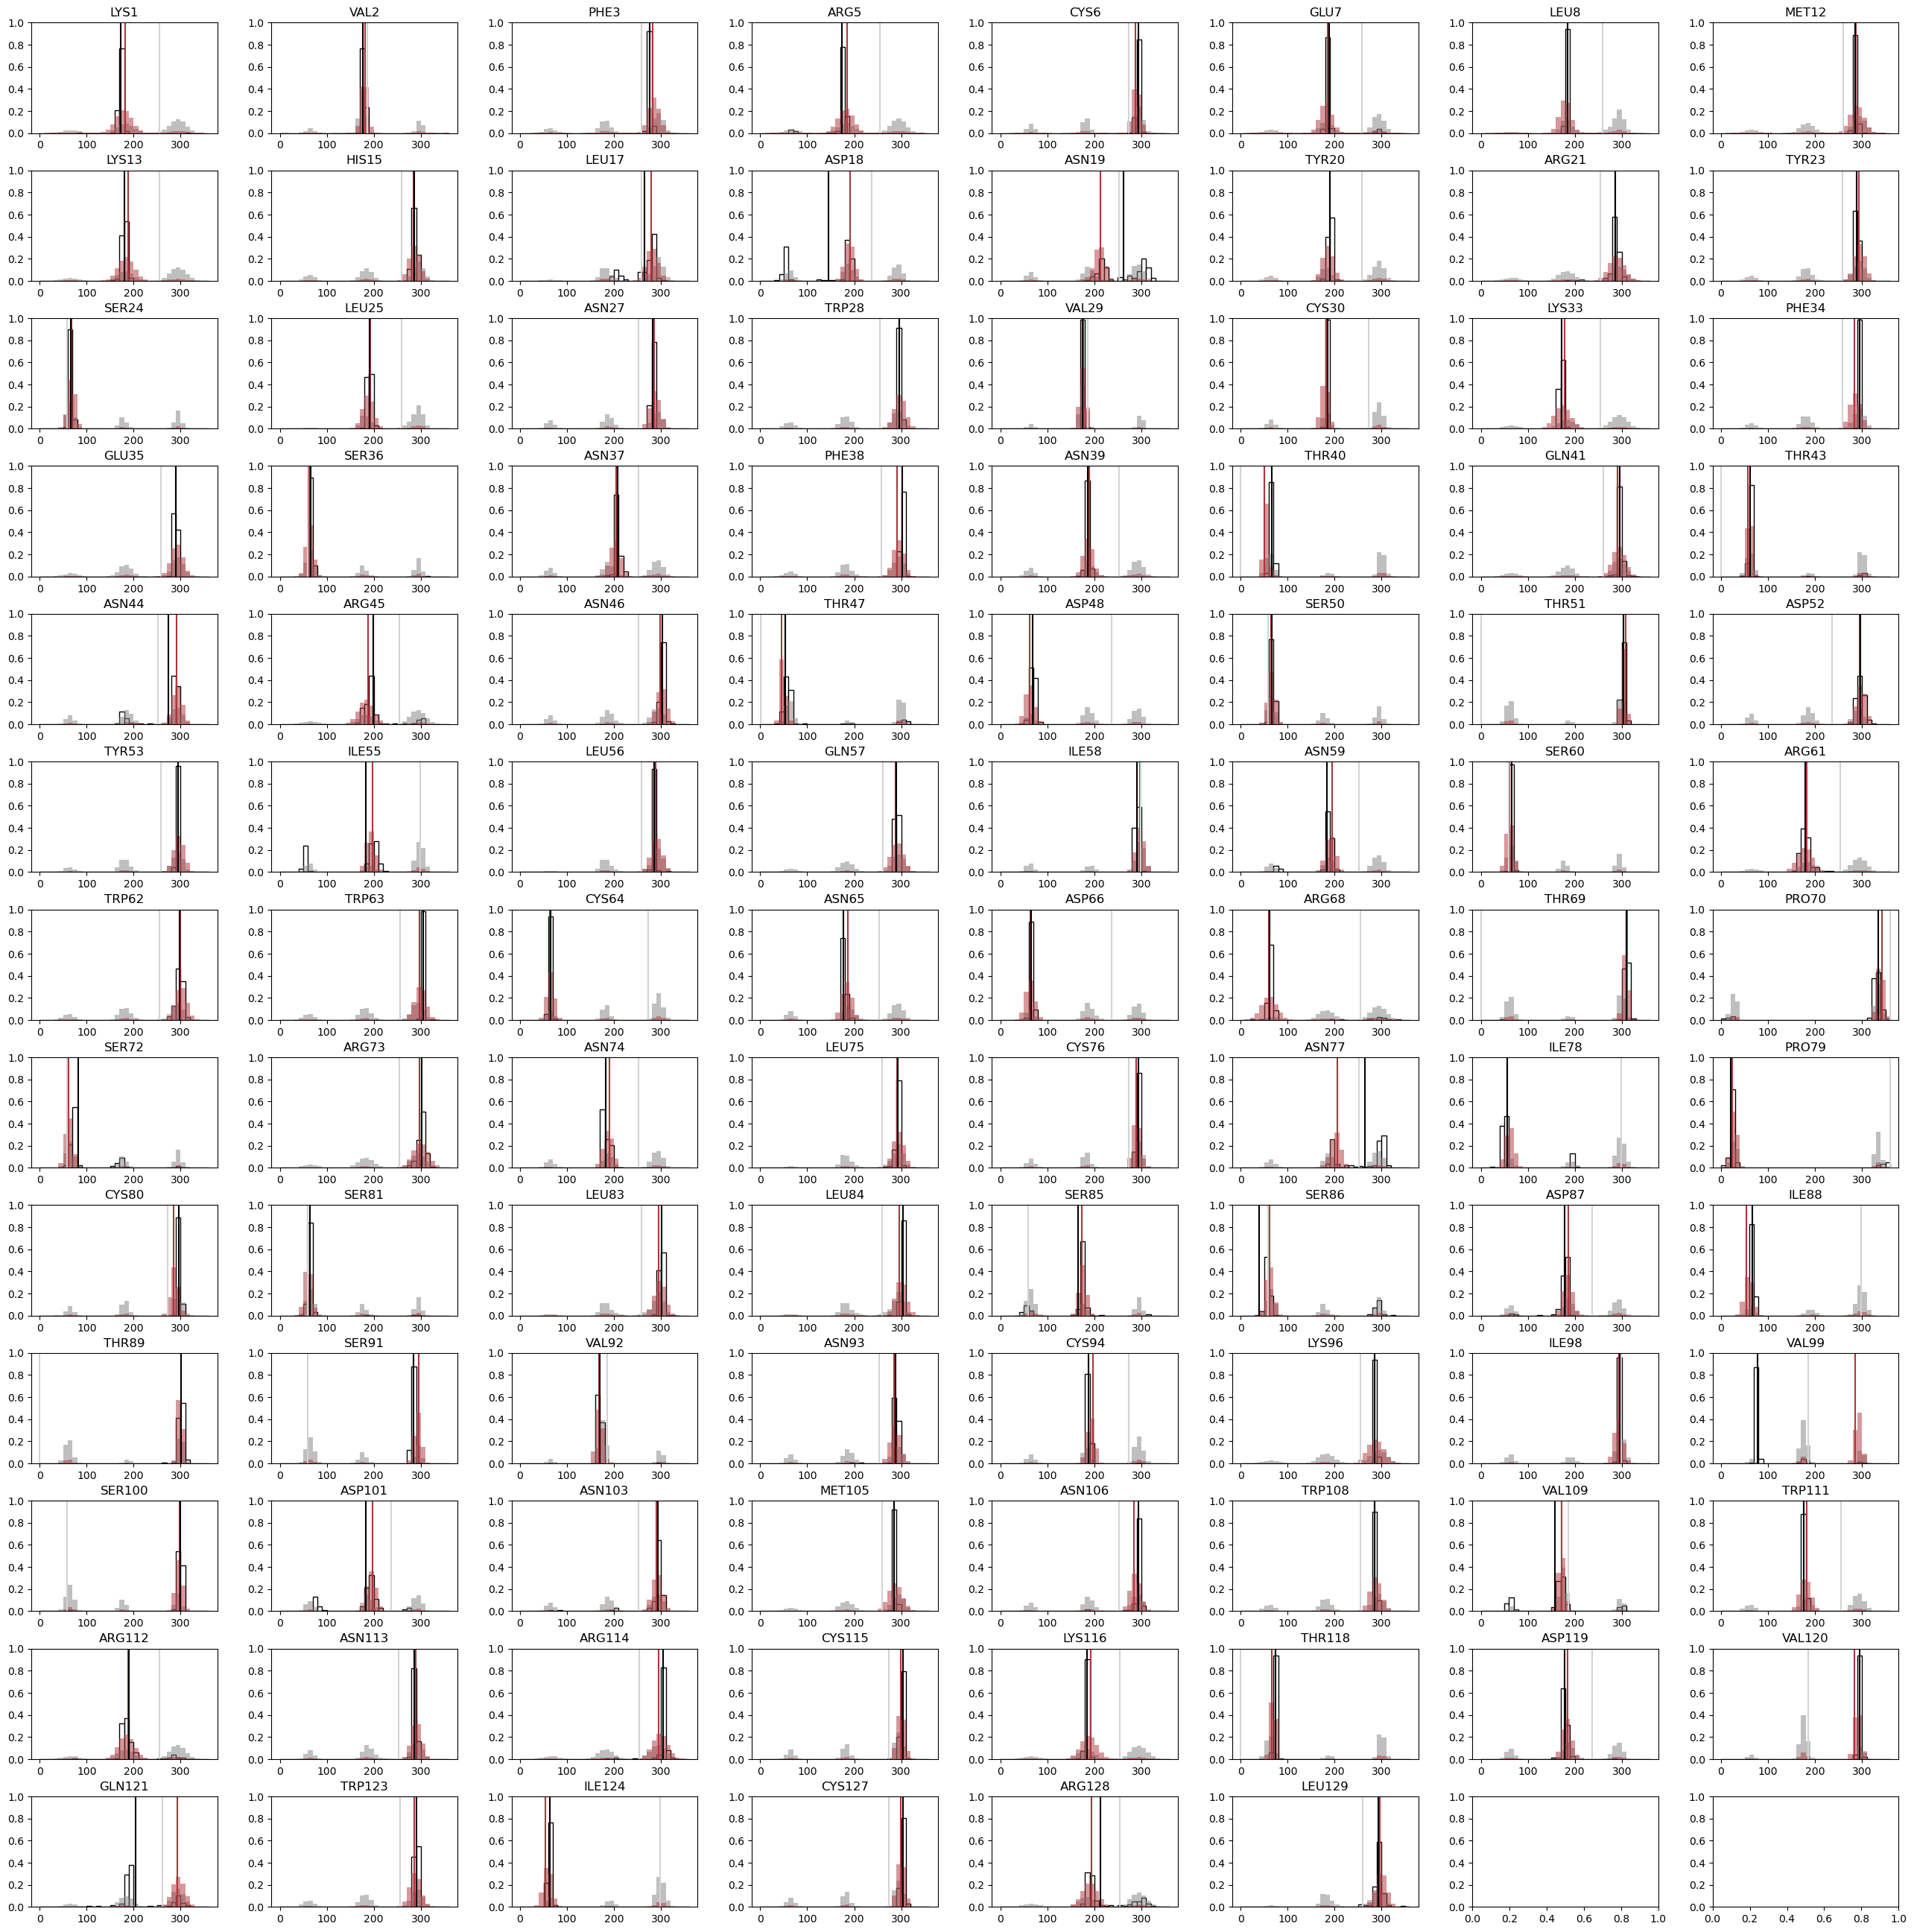

In [67]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(13,8,figsize=(26,26))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
colors=['#56b4e9','#d55c00','#009e74','#f0e442','#000fff']
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.5)
            axs[idx_ax].bar(x,top8000_prior[res[:3]+'_'+chi_sel].values,color='gray',width=10,zorder=-10,alpha=0.5)
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=top8000_prior[res[:3]+'_'+chi_sel].values))), color='lightgray')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k')

            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/hewl_prior_vs_top8000_on_pdb_ensemble.pdf',dpi=500)

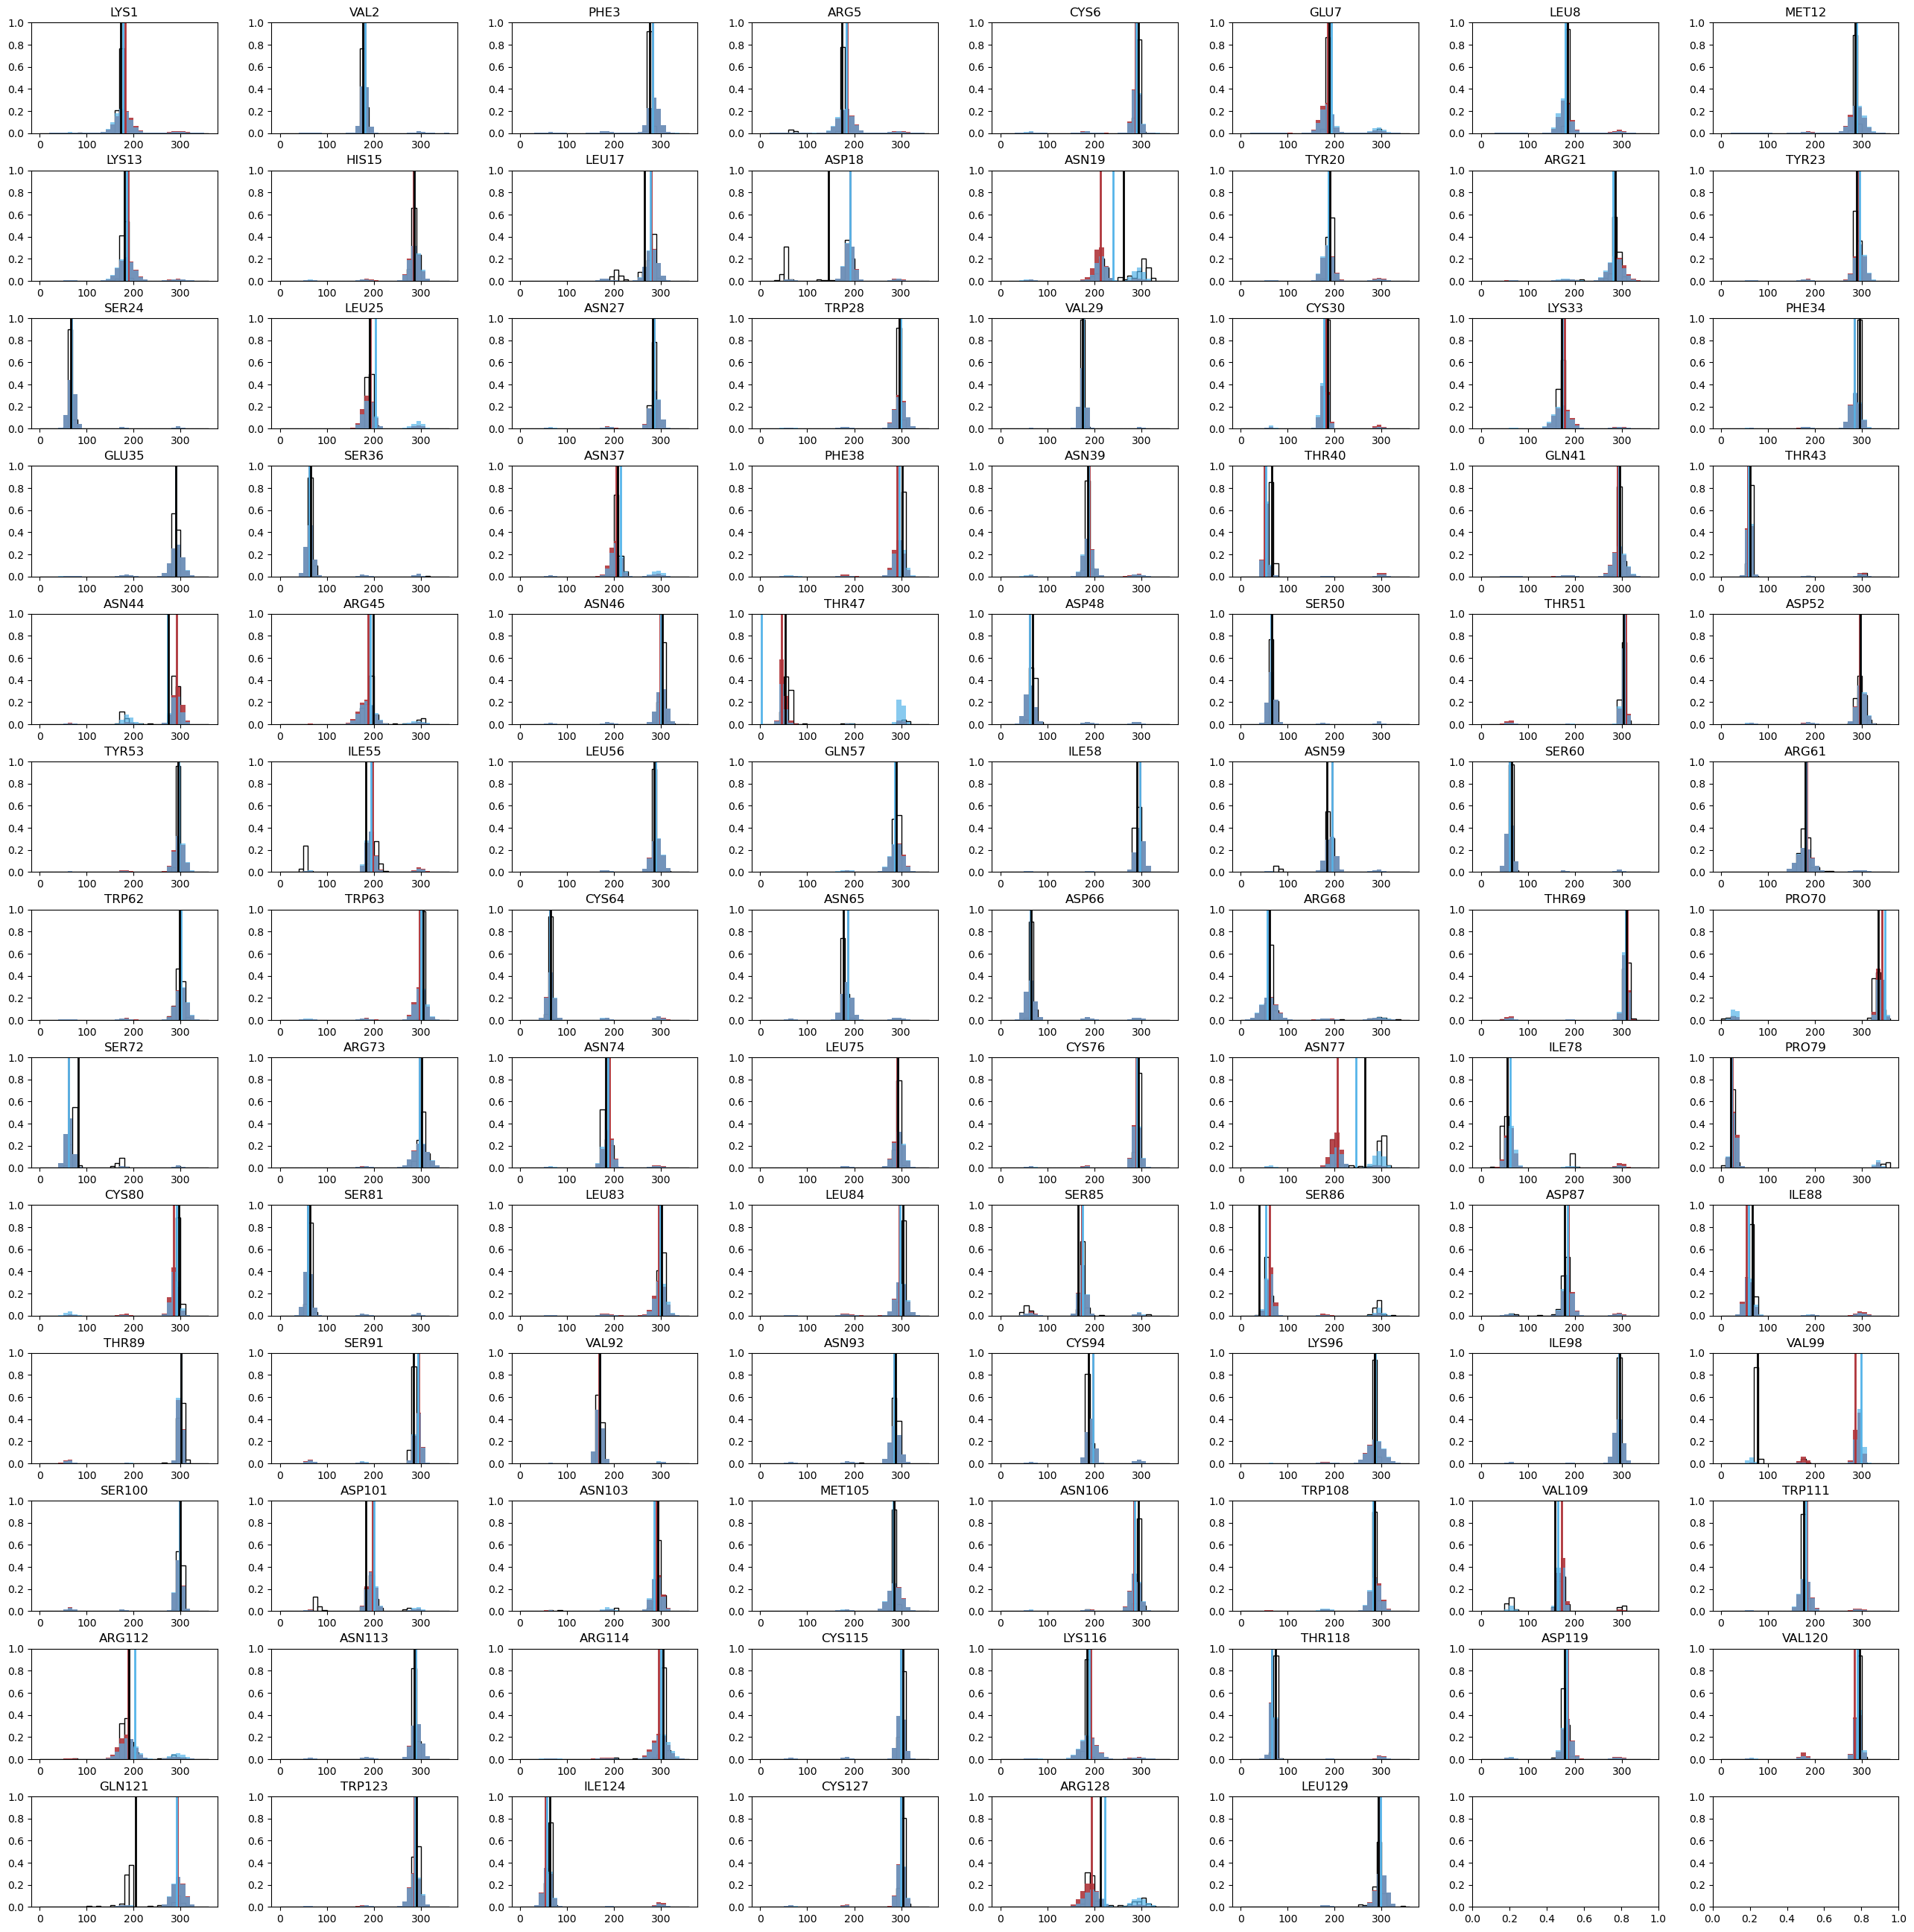

In [68]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(13,8,figsize=(26,26))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
            axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=2)


            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/hewl_rewe_vs_prior_on_pdb_ensemble.pdf',dpi=500)

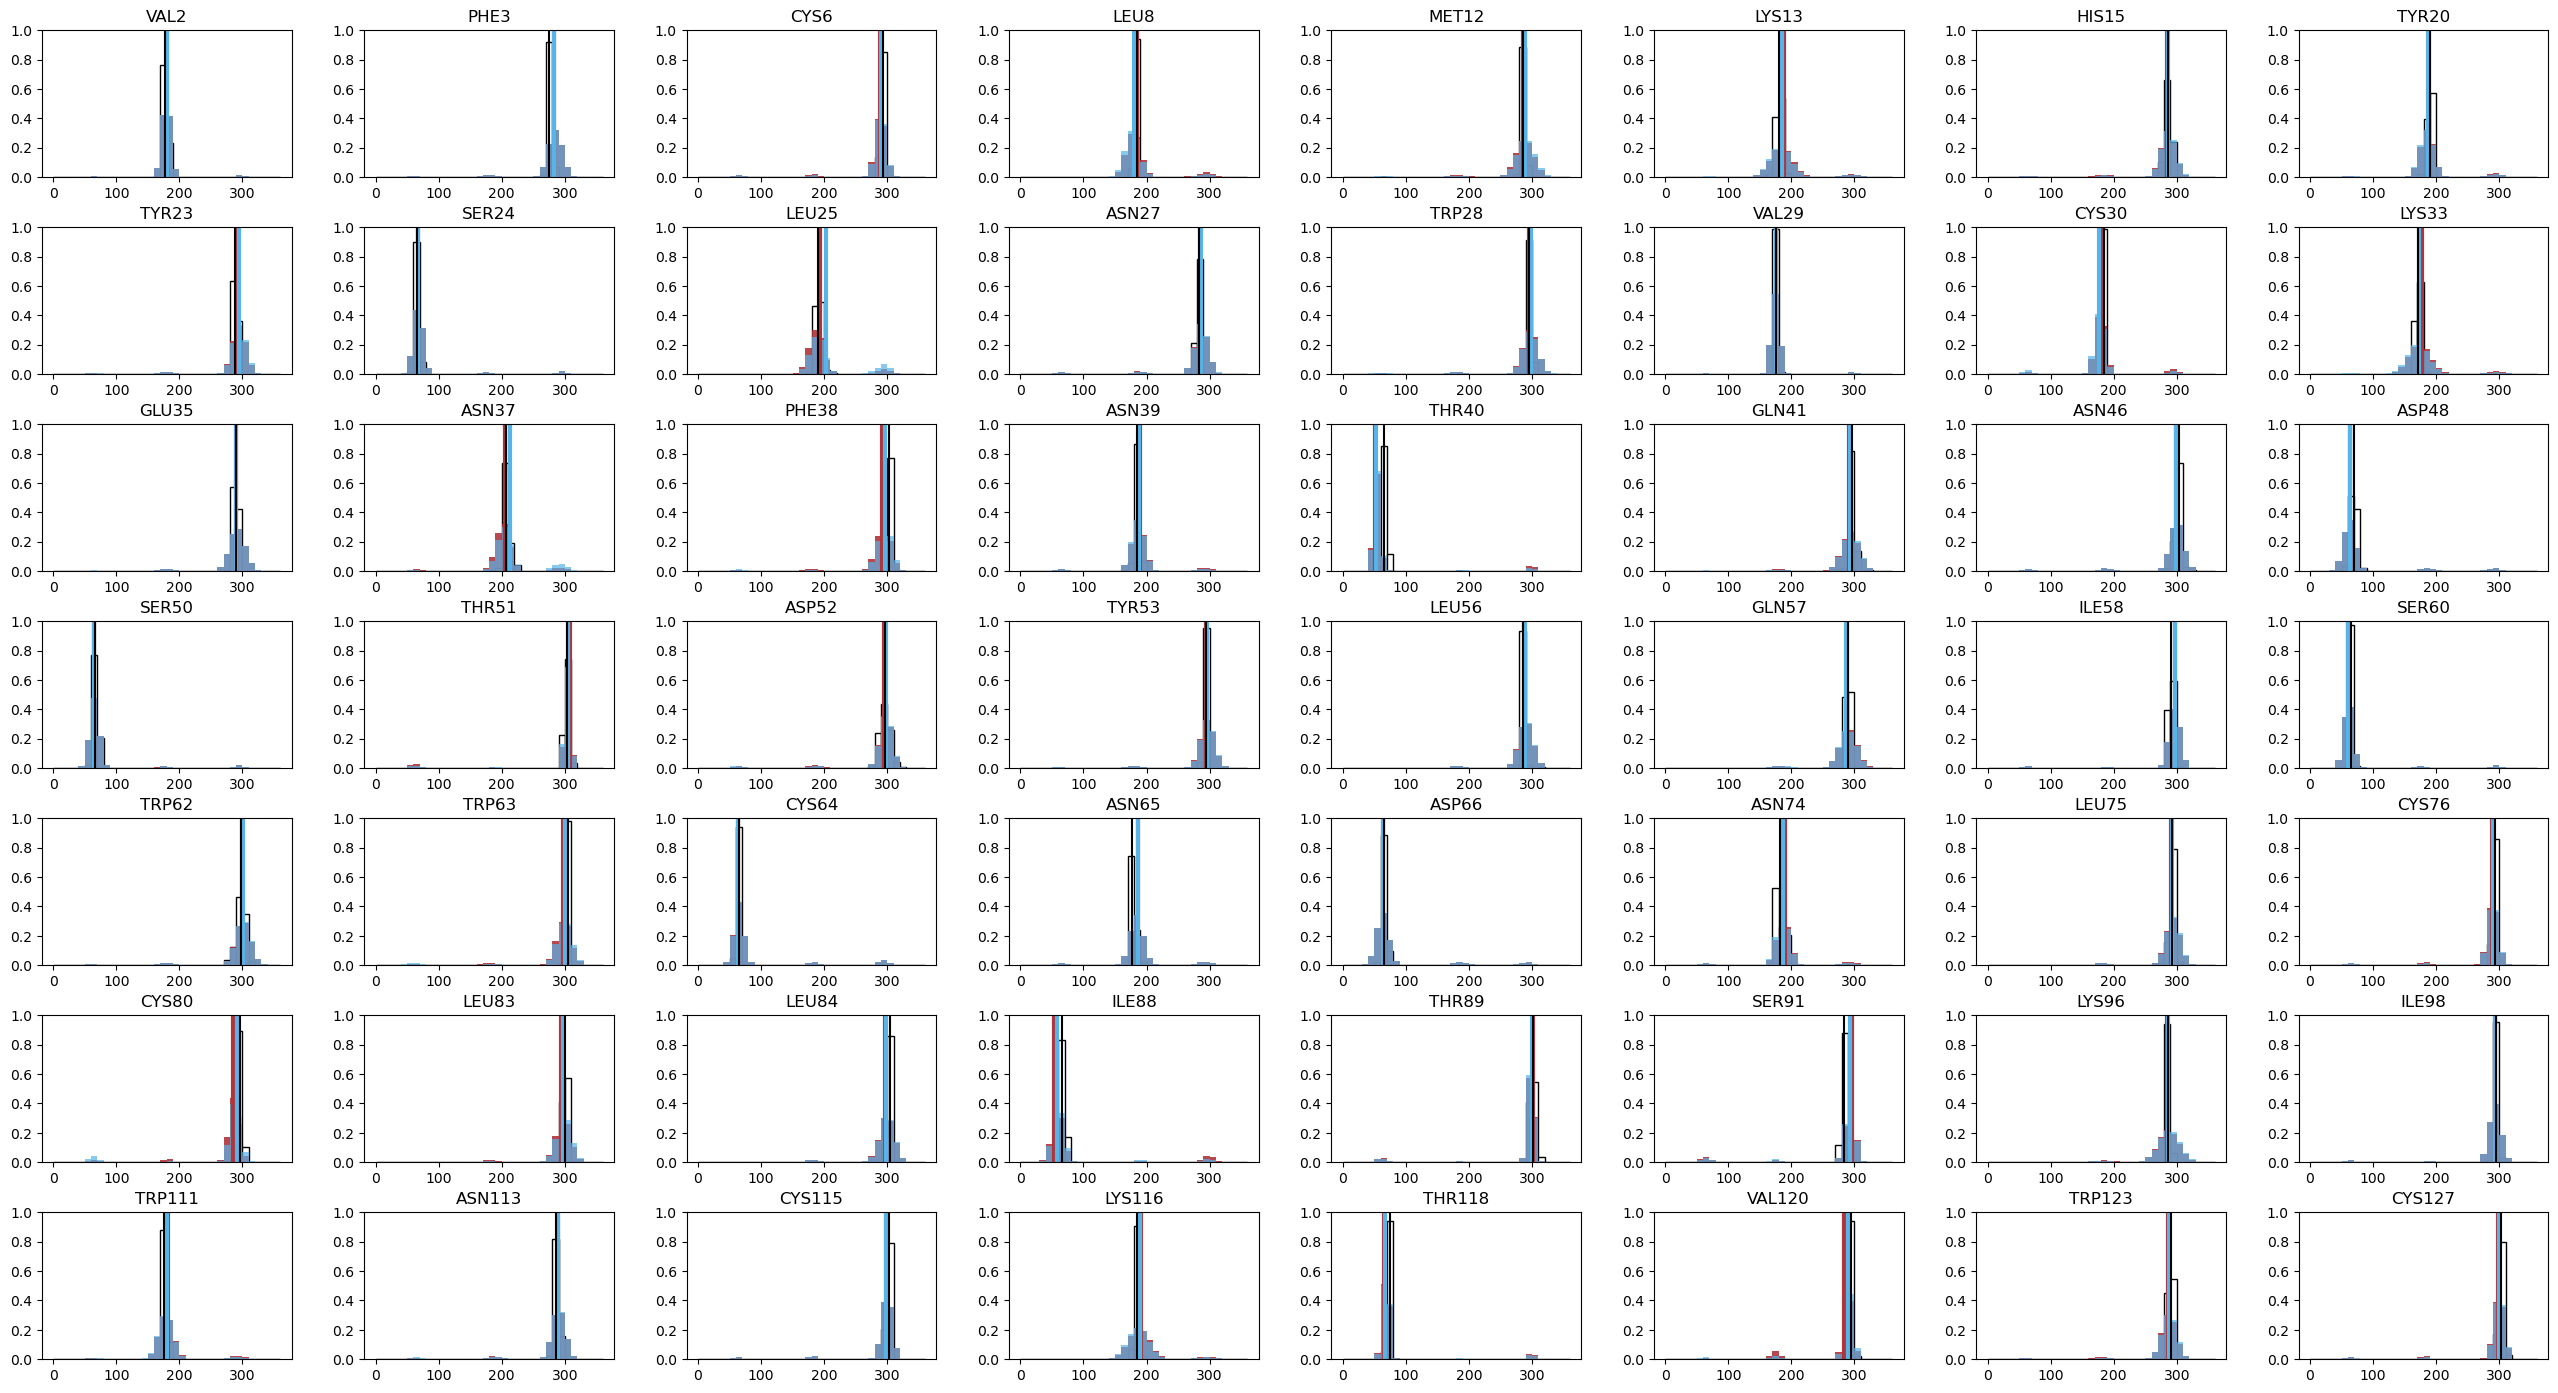

In [69]:
###Fig S8
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(7,8,figsize=(26,14))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)

is_fixed={}


for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True
            

for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            if is_fixed[res]:
                axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
                axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
                axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
                
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=3)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=3)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=1.5)
    
    
                axs[idx_ax].set_ylim(0,1)
                axs[idx_ax].set_title(res)
                
                idx_ax+=1

plt.savefig('../figures/hewl_rewe_vs_prior_on_pdb_ensemble_fixed.pdf',dpi=500)

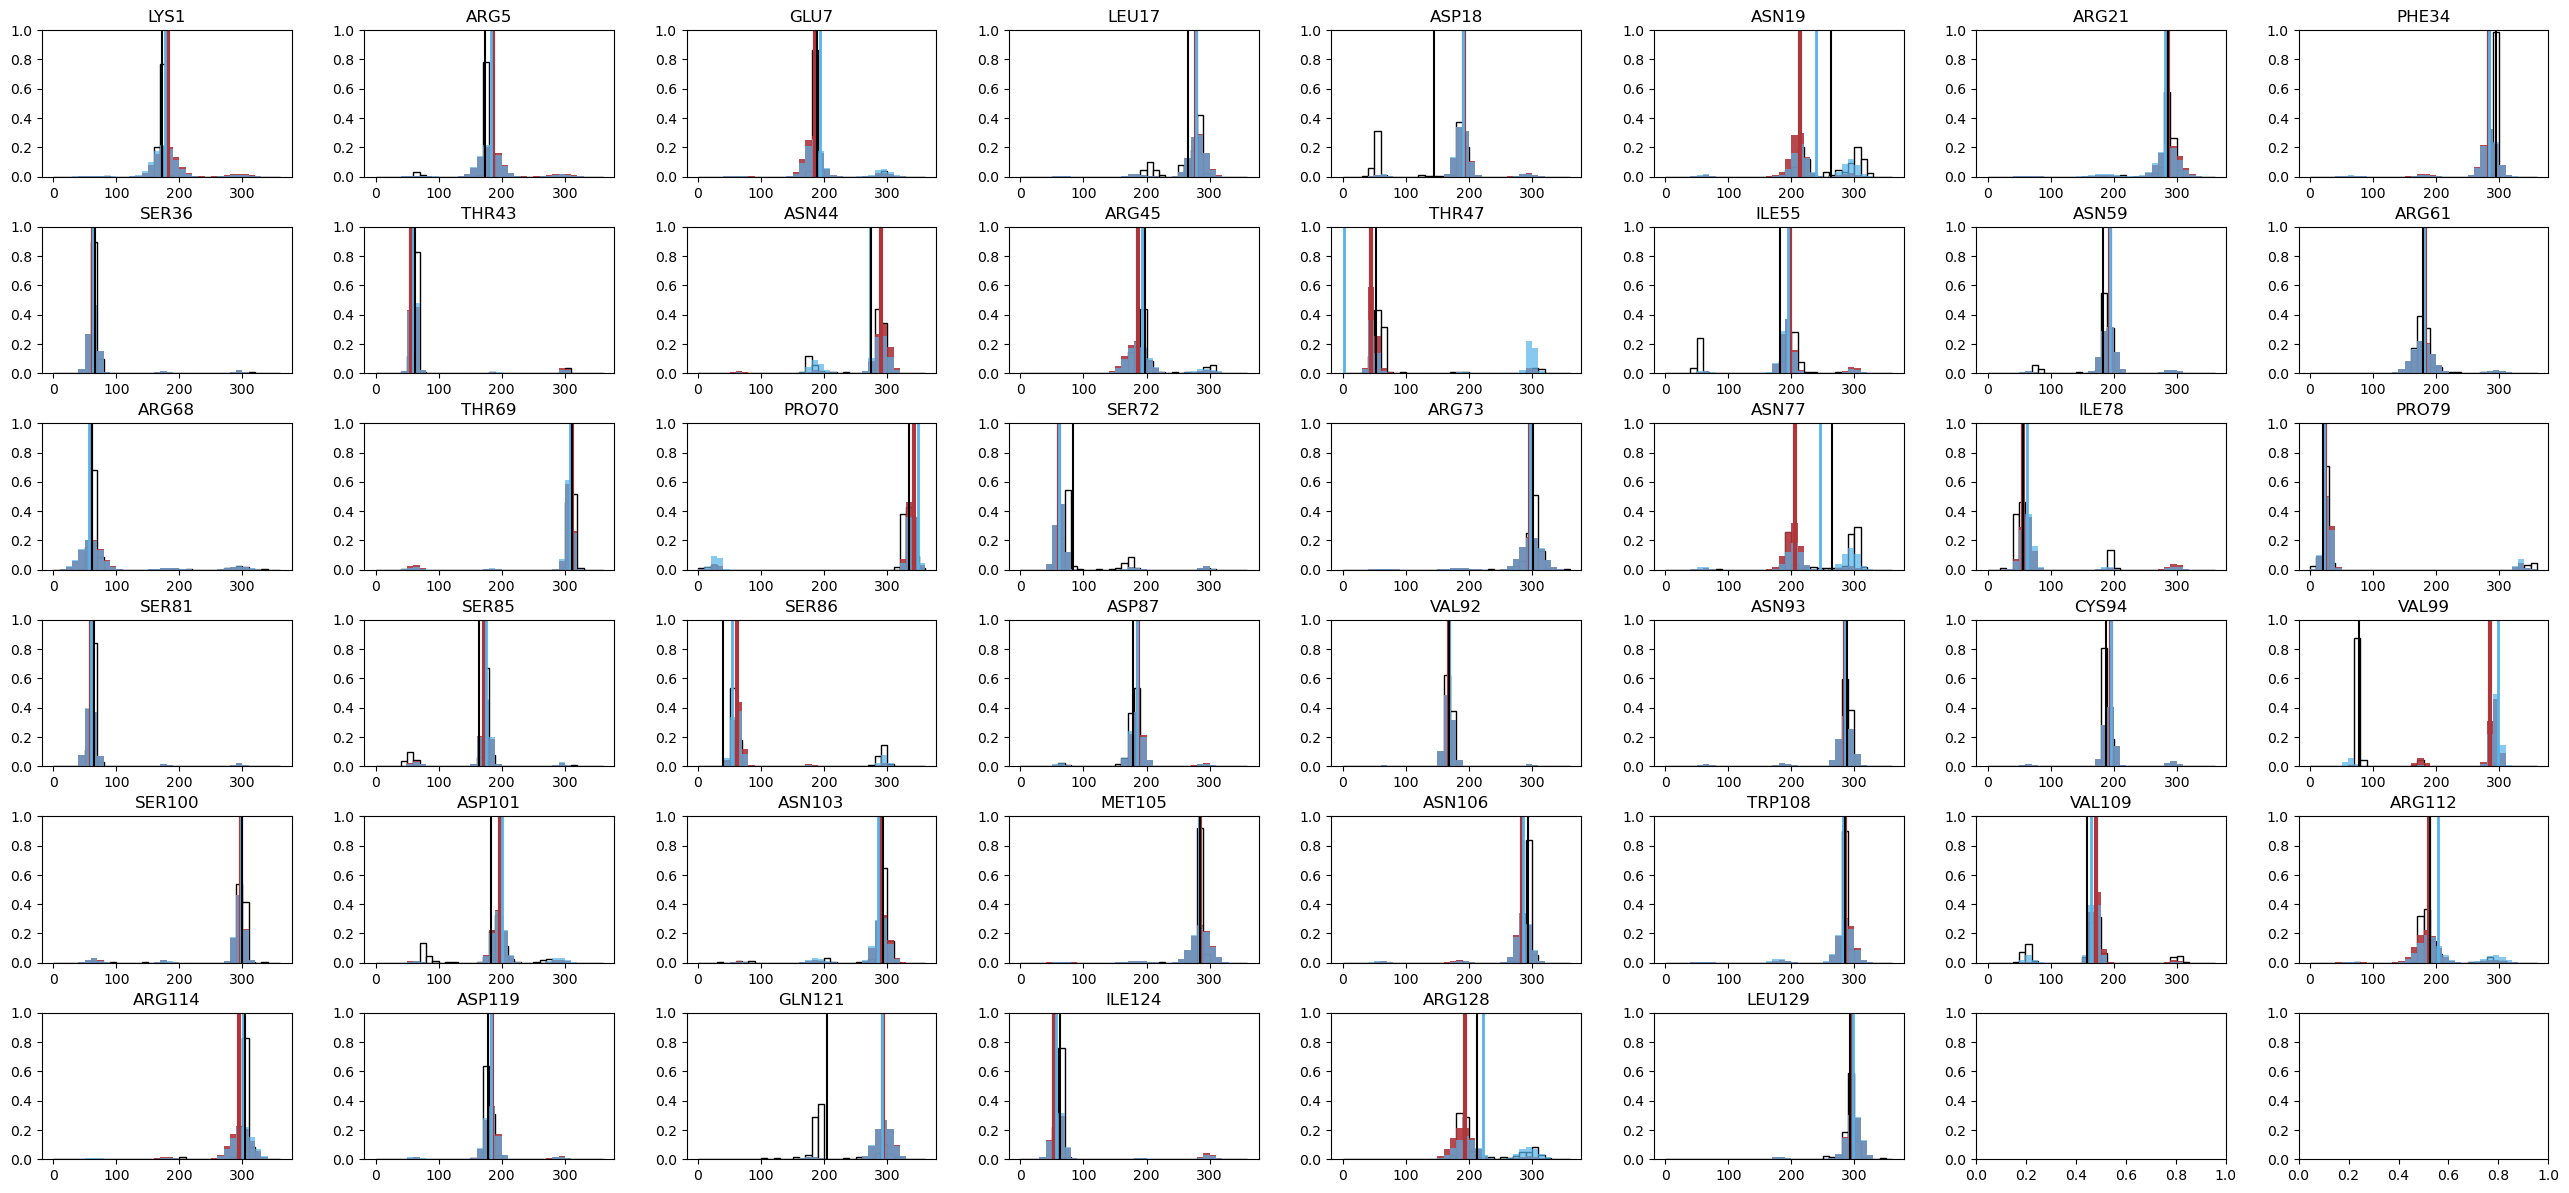

In [70]:
###Fig S8

x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(6,8,figsize=(26,12))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)

is_fixed={}


for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True
            

for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            if not is_fixed[res]:
                axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
                axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
                axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
                
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=3)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=2)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=1.5)
    
    
                axs[idx_ax].set_ylim(0,1)
                axs[idx_ax].set_title(res)
                
                idx_ax+=1

plt.savefig('../figures/hewl_rewe_vs_prior_on_pdb_ensemble_multi.pdf',dpi=500)

In [71]:
js_re=[]
js_prior=[]
js_top8000=[]
js_af2=[]
js_MD=[]

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        js_MD.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_re.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
        js_prior.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
        js_top8000.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
        js_af2.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

In [72]:
is_fixed={}

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True

js_re_fixed=[]
js_MD_fixed=[]
js_prior_fixed=[]
js_top8000_fixed=[]
js_af2_fixed=[]

js_re_multi=[]
js_MD_multi=[]
js_prior_multi=[]
js_top8000_multi=[]
js_af2_multi=[]

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        if is_fixed[res]:
            js_MD_fixed.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_re_fixed.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
            js_prior_fixed.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
            js_top8000_fixed.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
            js_af2_fixed.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

        else:
            js_MD_multi.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_re_multi.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
            js_prior_multi.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
            js_top8000_multi.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
            js_af2_multi.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))


In [73]:
print('All(tot: ',len(js_top8000))
print('js_af2 - sum:',np.sum(js_af2),' mean: ', np.mean(js_af2),'std', np.std(js_af2))
print('js_top8000 - sum:',np.sum(js_top8000),' mean: ', np.mean(js_top8000),'std', np.std(js_top8000))
print('js_prior - sum:',np.sum(js_prior),' mean: ', np.mean(js_prior),'std', np.std(js_prior))
print('js_re - sum:',np.sum(js_re),' mean: ', np.mean(js_re),'std', np.std(js_re))
print('js_MD - sum:',np.sum(js_MD),' mean: ', np.mean(js_MD),'std', np.std(js_MD))

All(tot:  102
js_af2 - sum: 51.79880064670833  mean:  0.5078313788892973 std 0.21587177361566676
js_top8000 - sum: 59.60739917273726  mean:  0.584386266399385 std 0.08965381456352683
js_prior - sum: 43.30792542135707  mean:  0.42458750413095164 std 0.10057817866692068
js_re - sum: 42.60961614381885  mean:  0.41774133474332203 std 0.10198155702782463
js_MD - sum: 48.85901917691414  mean:  0.4790099919305308 std 0.14492968113176494


In [74]:
print('Fixed (tot: ',len(js_top8000_fixed))
print('js_af2 - sum:',np.sum(js_af2_fixed),' mean: ', np.mean(js_af2_fixed),'std', np.std(js_af2_fixed))
print('js_top8000 - sum:',np.sum(js_top8000_fixed),' mean: ', np.mean(js_top8000_fixed),'std', np.std(js_top8000_fixed))
print('js_prior - sum:',np.sum(js_prior_fixed),' mean: ', np.mean(js_prior_fixed),'std', np.std(js_prior_fixed))
print('js_re - sum:',np.sum(js_re_fixed),' mean: ', np.mean(js_re_fixed),'std', np.std(js_re_fixed))
print('js_MD - sum:',np.sum(js_MD_fixed),' mean: ', np.mean(js_MD_fixed),'std', np.std(js_MD_fixed))

Fixed (tot:  56
js_af2 - sum: 26.3860527222108  mean:  0.4711795128966214 std 0.2372740564934226
js_top8000 - sum: 34.41952764582879  mean:  0.6146344222469428 std 0.07040388795176475
js_prior - sum: 24.588998952968936  mean:  0.43908926701730244 std 0.09385945723436252
js_re - sum: 24.3558418673423  mean:  0.43492574763111247 std 0.09350917434112137
js_MD - sum: 26.181483100130865  mean:  0.4675264839309083 std 0.14667037044785985


In [75]:
print('Multi (tot: ',len(js_top8000_multi))
print('js_af2 - sum:',np.sum(js_af2_multi),' mean: ', np.mean(js_af2_multi),'std', np.std(js_af2_multi))
print('js_top8000 - sum:',np.sum(js_top8000_multi),' mean: ', np.mean(js_top8000_multi),'std', np.std(js_top8000_multi))
print('js_prior- sum:',np.sum(js_prior_multi),' mean: ', np.mean(js_prior_multi),'std', np.std(js_prior_multi))
print('js_re - sum:',np.sum(js_re_multi),' mean: ', np.mean(js_re_multi),'std', np.std(js_re_multi))
print('js_MD - sum:',np.sum(js_MD_multi),' mean: ', np.mean(js_MD_multi),'std', np.std(js_MD_multi))

Multi (tot:  46
js_af2 - sum: 25.412747924497527  mean:  0.5524510418369027 std 0.1765435387622844
js_top8000 - sum: 25.187871526908463  mean:  0.5475624244980101 std 0.09653424774690399
js_prior- sum: 18.718926468388126  mean:  0.40693318409539403 std 0.10553976756358645
js_re - sum: 18.253774276476555  mean:  0.3968211799234034 std 0.10779339496881343
js_MD - sum: 22.677536076783284  mean:  0.49298991471268006 std 0.14152987669312106


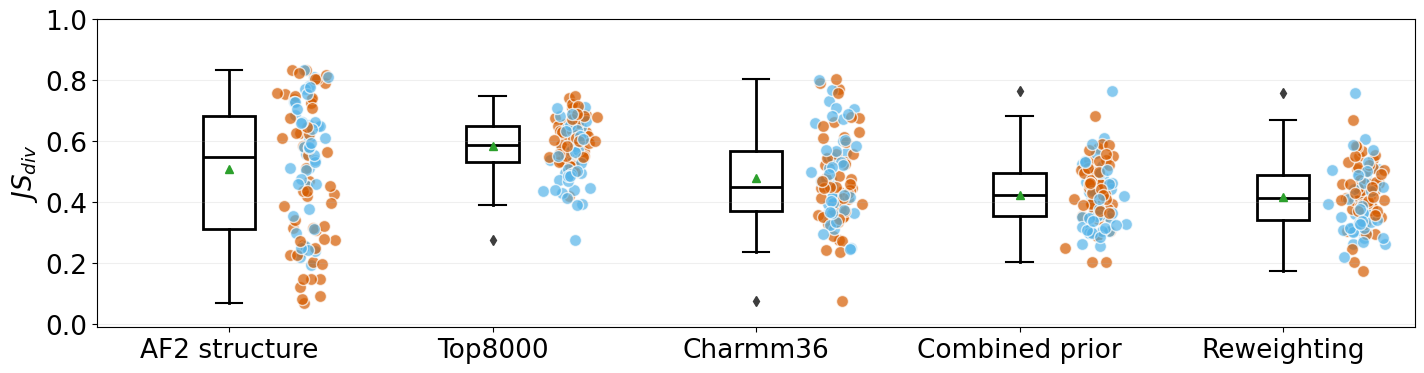

In [76]:
#Fig S7a

plot_boxplot_with_points(js_af2,js_top8000,js_MD,js_prior,js_re,labels=['AF2 structure','Top8000','Charmm36','Combined prior','Reweighting'],
                         colors=['#d55c00' if val else '#56b4e9' for val in list(is_fixed.values())],width=17,height=4,labelsize=19)
plt.savefig('../figures/hewl_chi1_js_all_and_ensemble_boxplots_points.pdf')

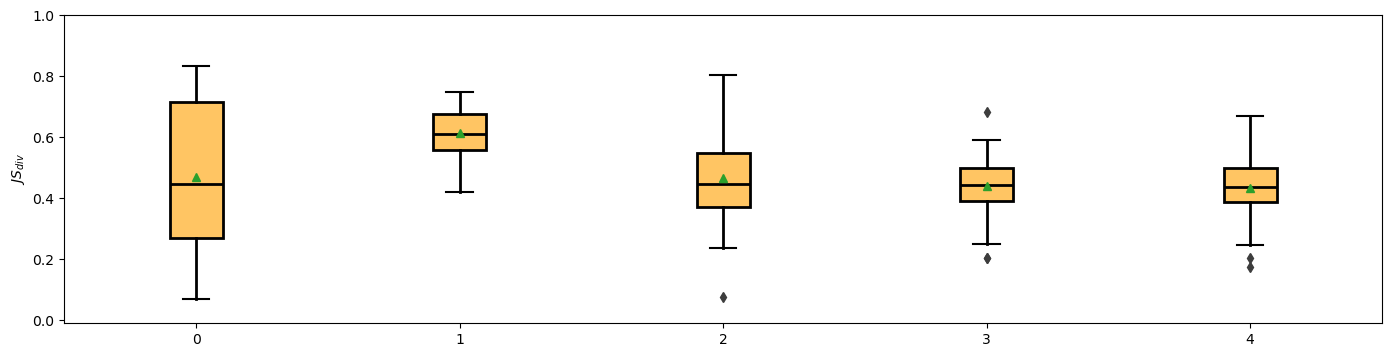

In [77]:
#Fig S7a

plot_boxplot(js_af2_fixed,js_top8000_fixed,js_MD_fixed,js_prior_fixed,js_re_fixed,box_color='#ffc563',width=17,height=4)
plt.savefig('../figures/hewl_chi1_js_fixed_boxplots_points.pdf')

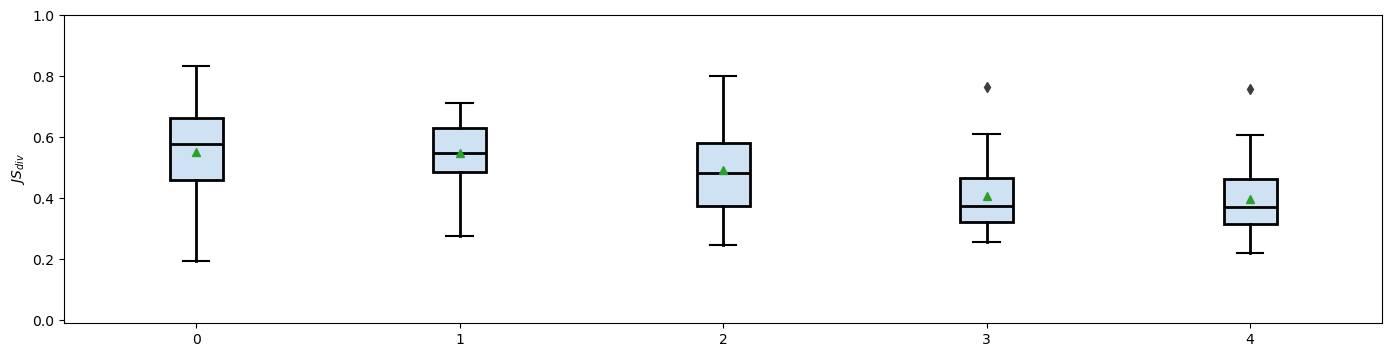

In [78]:
#Fig S7a

plot_boxplot(js_af2_multi,js_top8000_multi,js_MD_multi,js_prior_multi,js_re_multi,box_color='#cfe2f3',width=17,height=4)
plt.savefig('../figures/hewl_chi1_js_multi_boxplots_points.pdf')

### chi2

In [79]:
chi_sel='chi2'

In [80]:
layer_chi=4
angles_collected=[]

input_file='../data/af2chi_data/af2chi_runs_ILDNproteins/HEWL/output/6LYT_1_Chain_A_HEN_EGG_WHITE_LYSOZYME_Gallus_gallus__9031__rank_001_sc_angles.npy'

angles_npy=np.load(input_file,allow_pickle=True)

angles_appended=(circmean(np.arctan2(angles_npy[-1][:,layer_chi,0],angles_npy[-1][:,layer_chi,1]).reshape(-1,1),low=0,high=2*np.pi,axis=1))
angles_appended=np.array(angles_appended)

In [81]:
pdb_ensemble_angles=all_chis_pdb_ensemble[chi_sel]

prior_distributions=all_chis_priori[chi_sel]

reweighted_distributions=all_chis_fitted[chi_sel]

MD_ensemble_angles=all_chis_MD_ensemble[chi_sel]

In [82]:
## emove pro chi2 - not predicted by top8000
pdb_ensemble_angles = {key: value for key, value in pdb_ensemble_angles.items() if 'PRO' not in key}


In [83]:
struct_angles={}
struct_distributions={}
for res in pdb_ensemble_angles.keys():
    if res[:3] !='PRO':

        struct_angles[res]=np.rad2deg(angles_appended[int(res[3:])-1])
        struct_distributions[res]= gaussian(dihedral_angles, 2.5, struct_angles[res] , 1.25)

In [84]:
pdb_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_ensemble_angles[key]]
    
    pdb_ensemble_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [85]:
MD_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys(): ##chi fr chi2
    
    MD_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in MD_ensemble_angles[key]]
    
    MD_ensemble_angles_distr[key]=np.histogram(MD_degr_conv,bins=x_range)[0]/len(MD_degr_conv)

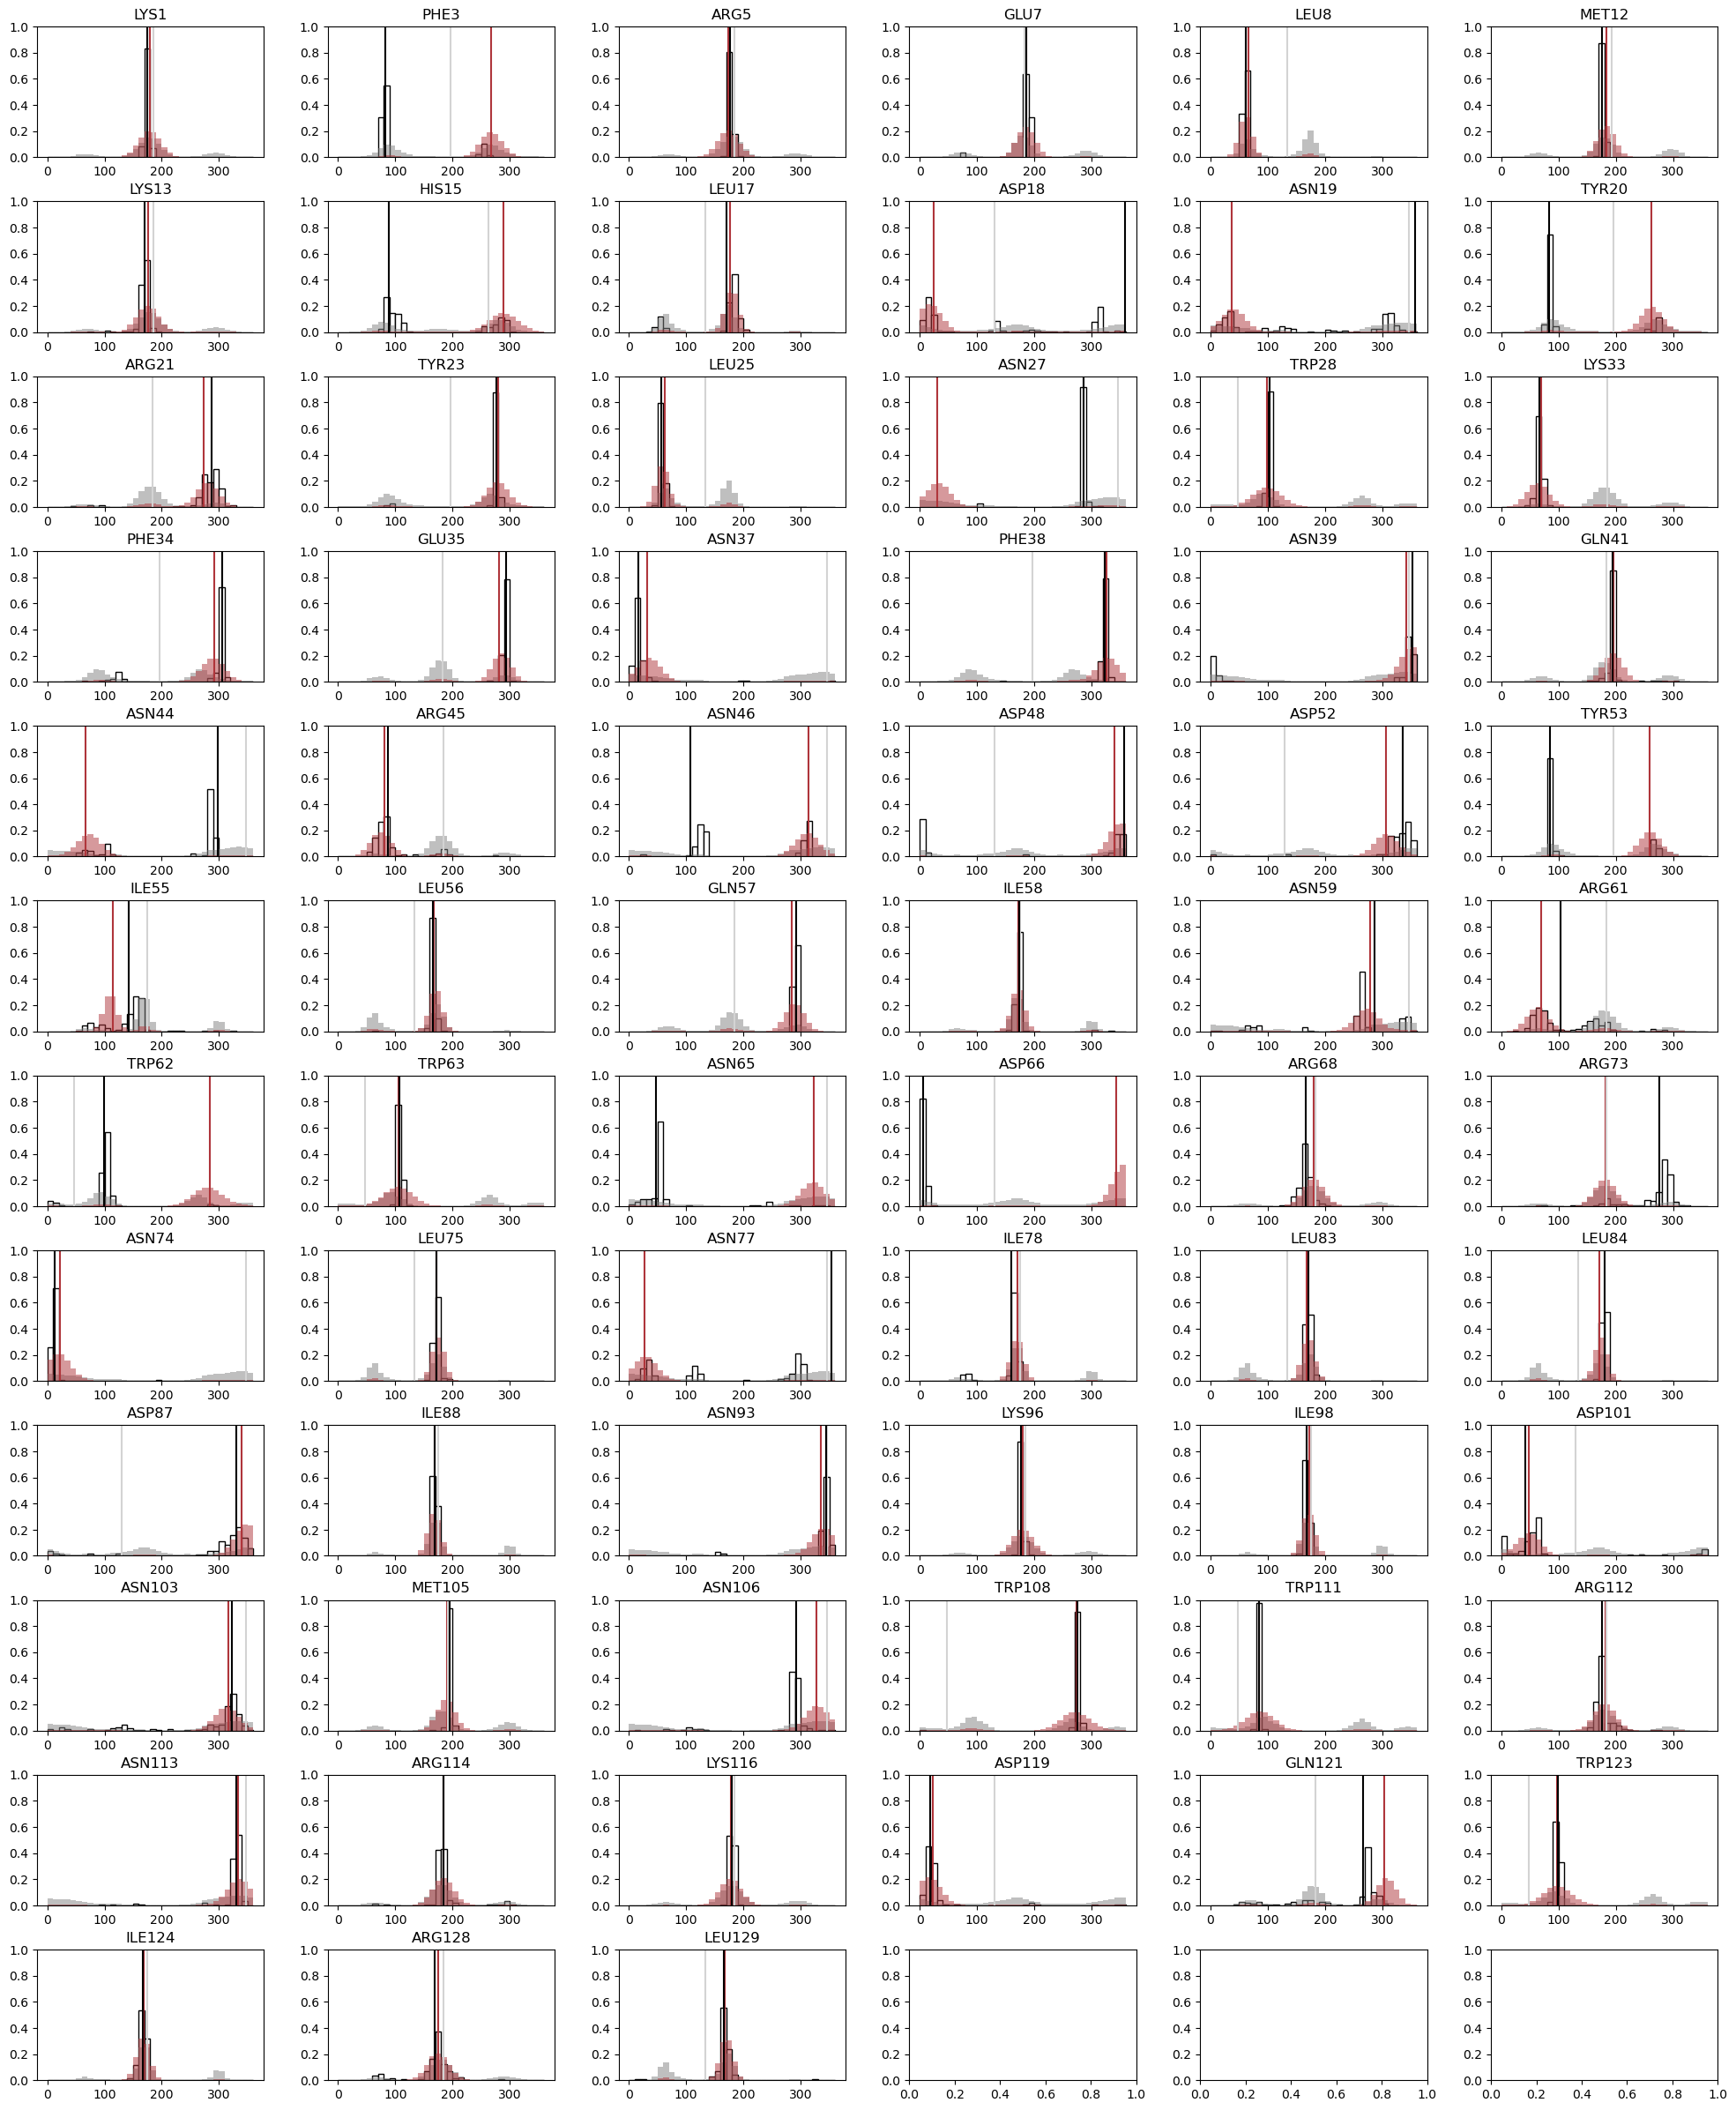

In [86]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(12,6,figsize=(20,24))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
colors=['#56b4e9','#d55c00','#009e74','#f0e442','#000fff']
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.5)
            axs[idx_ax].bar(x,top8000_prior[res[:3]+'_'+chi_sel].values,color='gray',width=10,zorder=-10,alpha=0.5)
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=top8000_prior[res[:3]+'_'+chi_sel].values))), color='lightgray')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k')

            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/hewl_prior_vs_top8000_on_pdb_ensemble_chi2.pdf',dpi=500)

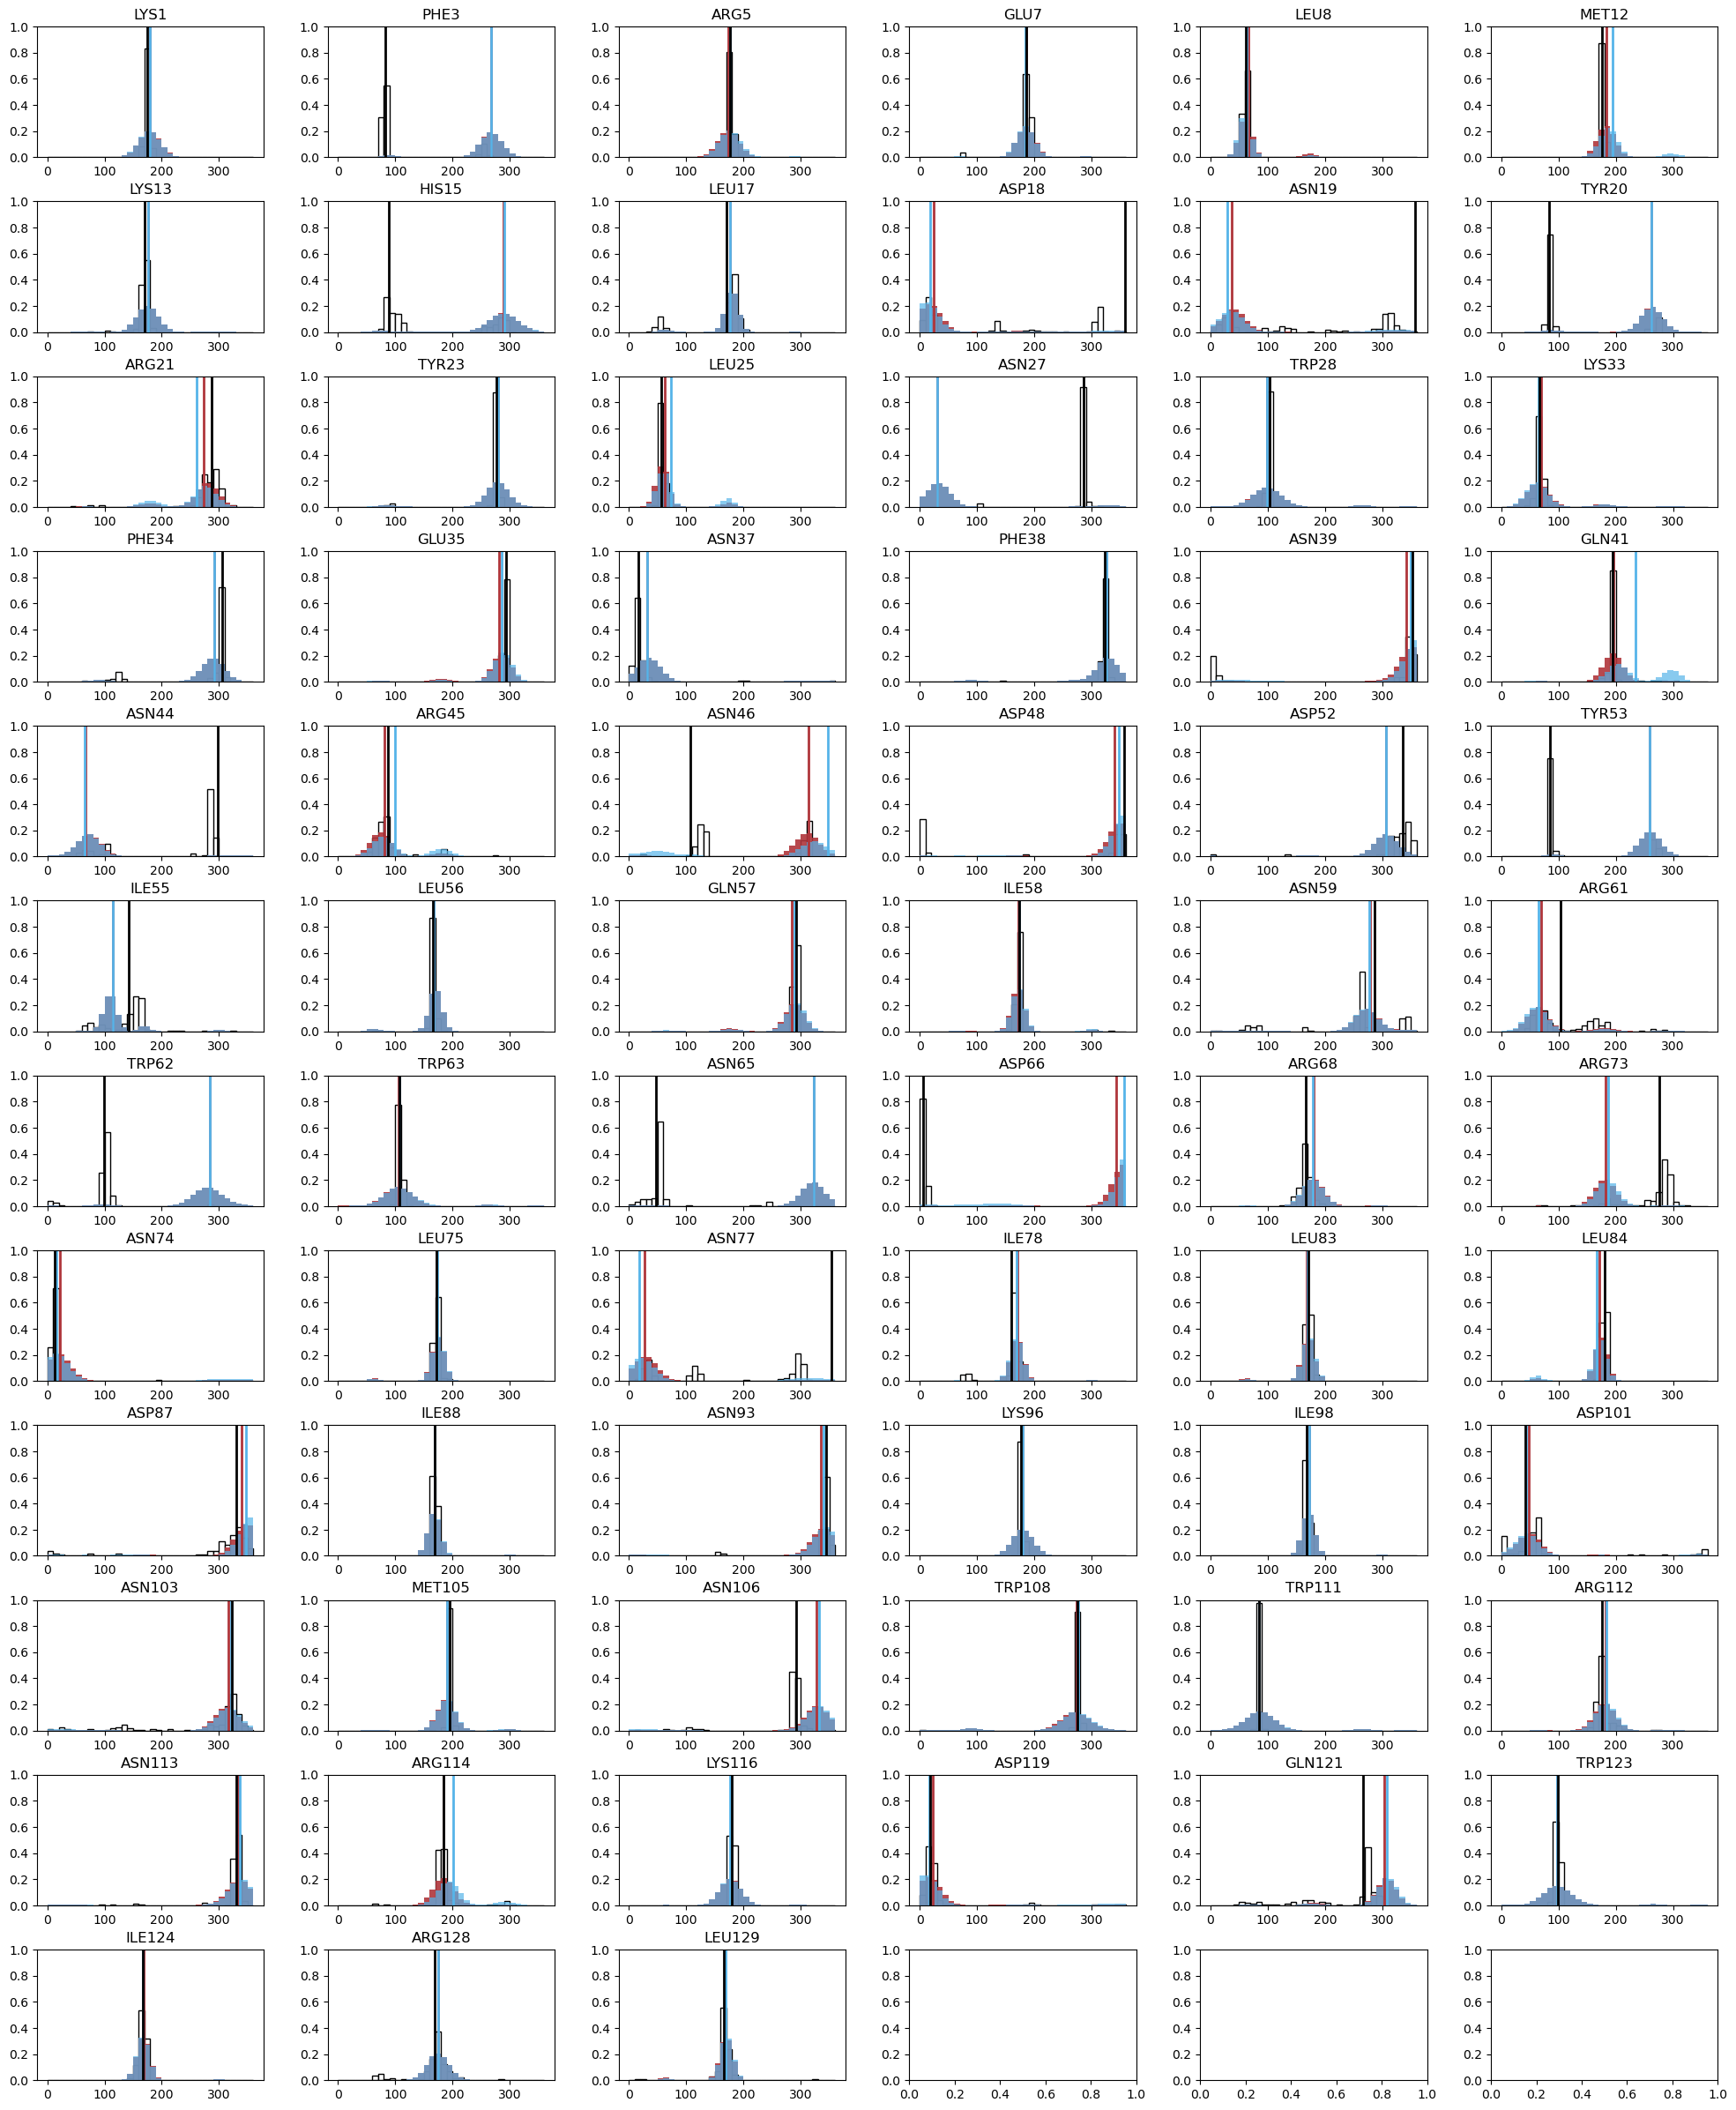

In [87]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(12,6,figsize=(20,24))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
            axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=2)


            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/hewl_rewe_vs_prior_on_pdb_ensemble_chi2.pdf',dpi=500)

In [88]:
js_re=[]
js_prior=[]
js_top8000=[]
js_af2=[]
js_MD=[]

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        js_MD.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_re.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
        js_prior.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
        js_top8000.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
        js_af2.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

In [89]:
print('All(tot: ',len(js_top8000))
print('js_af2 - sum:',np.sum(js_af2),' mean: ', np.mean(js_af2),'std',np.std(js_af2))
print('js_top8000 - sum:',np.sum(js_top8000),' mean: ', np.mean(js_top8000),'std',np.std(js_top8000))
print('js_prior - sum:',np.sum(js_prior),' mean: ', np.mean(js_prior),'std',np.std(js_prior))
print('js_re - sum:',np.sum(js_re),' mean: ', np.mean(js_re),'std',np.std(js_re))
print('js_MD - sum:',np.sum(js_MD),' mean: ', np.mean(js_MD),'std',np.std(js_MD))

All(tot:  69
js_af2 - sum: 43.193703516384524  mean:  0.6259957031360076 std 0.18013385193630913
js_top8000 - sum: 39.985694775934554  mean:  0.5795028228396312 std 0.10080635734989861
js_prior - sum: 34.581228470119115  mean:  0.5011772242046248 std 0.12994782813961334
js_re - sum: 34.80896464107773  mean:  0.5044777484214163 std 0.1277477888975322
js_MD - sum: 37.00892042807641  mean:  0.5363611656242958 std 0.12444762552214453


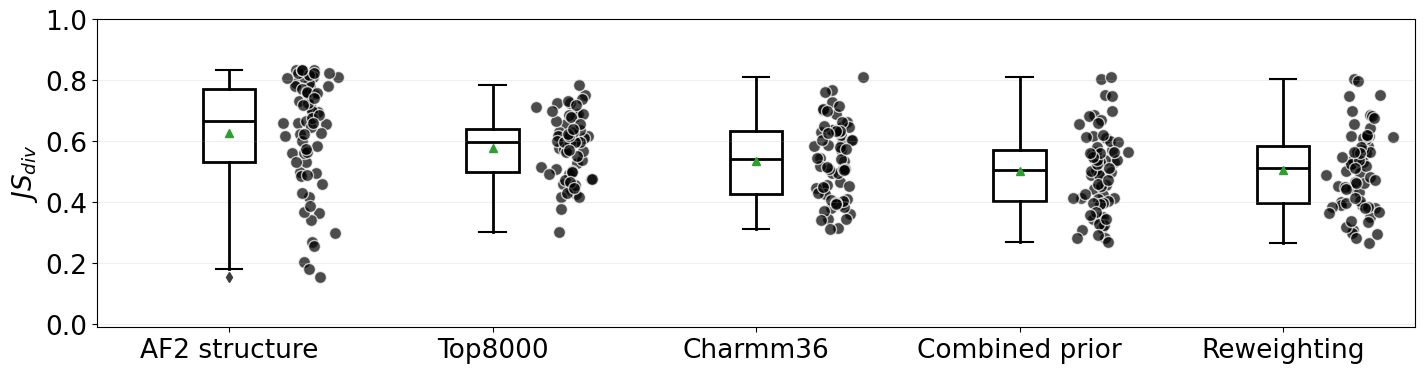

In [90]:
#Fig S7b

plot_boxplot_with_points(js_af2,js_top8000,js_MD,js_prior,js_re,labels=['AF2 structure','Top8000','Charmm36','Combined prior','Reweighting'],
                         colors=['k' if val else 'k' for val in list(is_fixed.values())],width=17,labelsize=19,height=4)
plt.savefig('../figures/hewl_chi2_js_all_and_ensemble_boxplots_points.pdf')

## BPTI

In [91]:
btpi_seq='RPDFCLEPPYTGPCKARIIRYFYNAKAGLCQTFVYGGCRAKRNNFKSAEDCMRTCGGA'

In [92]:
keys_chi1=[]
for idx,letter in enumerate(btpi_seq):
    keys_chi1.append(alphabetAA_1L_3L[letter].upper()+str(idx+1))

### load all chis prior

In [93]:
with open('../data/af2chi_data/af2chi_runs_ILDNproteins/BPTI/output/5PTI_1_Chain_A_TRYPSIN_INHIBITOR_Bos_taurus__9913__rank_001_sc_pops_priori.json') as json_in:
    all_chis_priori=json.load(json_in)

### load all chis posterior

In [94]:
with open('../data/af2chi_data/af2chi_runs_ILDNproteins/BPTI/output/5PTI_1_Chain_A_TRYPSIN_INHIBITOR_Bos_taurus__9913__rank_001_sc_pops_fitted.json') as json_in:
    all_chis_fitted=json.load(json_in)

### load all pdb ensemble

In [95]:
with open('../data/struct_data//btpi__pdbs_chis_seqid99.json') as json_in:
    all_chis_pdb_ensemble=json.load(json_in)

### load MD

In [96]:
with open('../data/MD_data/MD_charmm36m/BPTI_chis.pkl','rb') as pkl_in:
    all_chis_MD_ensemble=pickle.load(pkl_in)

## Comparisons

In [97]:
x=[i for i in range(5,360,10)]
x_range=[i for i in range(0,365,10)]
print(len(x_range),len(x))

37 36


### chi1

In [98]:
chi_sel='chi1'

In [99]:
pdb_ensemble_angles=all_chis_pdb_ensemble[chi_sel]

prior_distributions=all_chis_priori[chi_sel]

reweighted_distributions=all_chis_fitted[chi_sel]

MD_ensemble_angles=all_chis_MD_ensemble[chi_sel]

In [100]:
layer_chi=3
angles_collected=[]

input_file='../data/af2chi_data/af2chi_runs_ILDNproteins/BPTI/output/5PTI_1_Chain_A_TRYPSIN_INHIBITOR_Bos_taurus__9913__rank_001_sc_angles.npy'

angles_npy=np.load(input_file,allow_pickle=True)

angles_appended=(circmean(np.arctan2(angles_npy[-1][:,layer_chi,0],angles_npy[-1][:,layer_chi,1]).reshape(-1,1),low=0,high=2*np.pi,axis=1))
angles_appended=np.array(angles_appended)

In [101]:
struct_angles={}
struct_distributions={}
for res in pdb_ensemble_angles.keys():
    struct_angles[res]=np.rad2deg(angles_appended[int(res[3:])-1])
    struct_distributions[res]= gaussian(dihedral_angles, 10, struct_angles[res] ,1.25)

In [102]:
pdb_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_ensemble_angles[key]]
    
    pdb_ensemble_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [103]:
for key in pdb_ensemble_angles_distr.keys():
    if len(pdb_ensemble_angles_distr[key]) <10:
        print(key)

In [104]:
MD_ensemble_angles_distr={}

for key in MD_ensemble_angles.keys():
    
    MD_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in MD_ensemble_angles[key]]
    
    MD_ensemble_angles_distr[key]=np.histogram(MD_degr_conv,bins=x_range)[0]/len(MD_degr_conv)

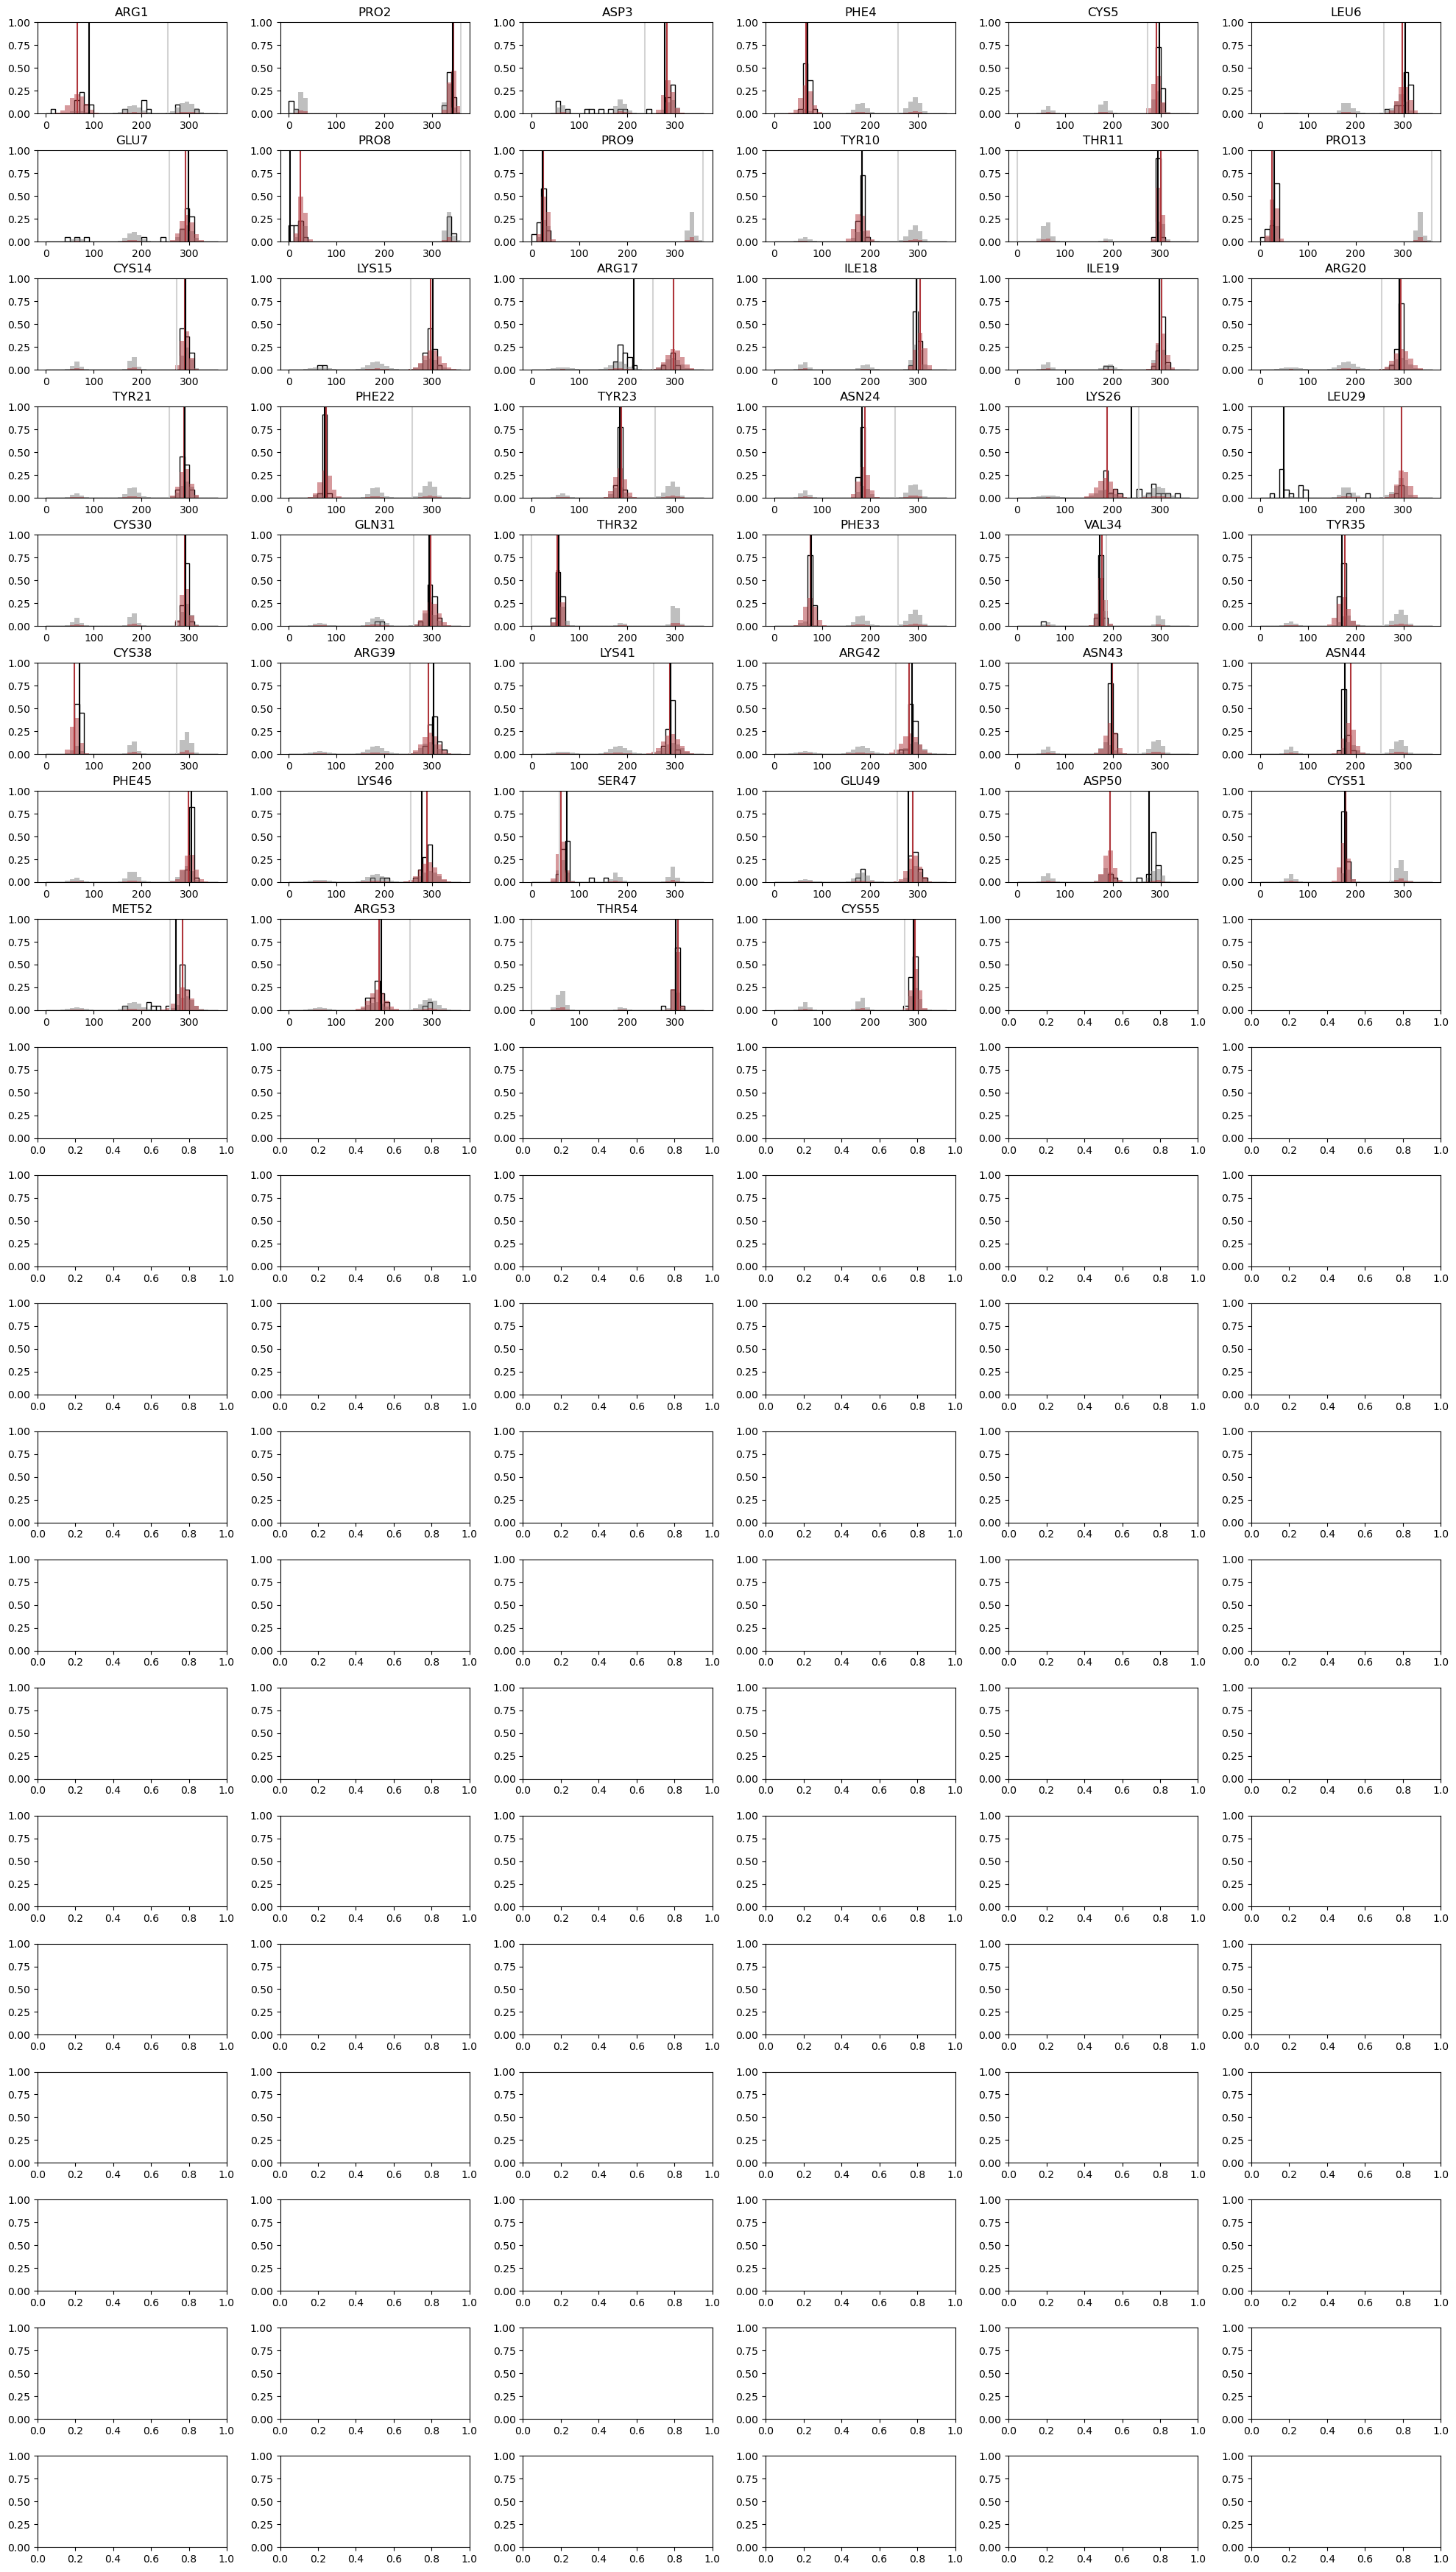

In [105]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(20,6,figsize=(20,35))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
colors=['#56b4e9','#d55c00','#009e74','#f0e442','#000fff']
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.5)
            axs[idx_ax].bar(x,top8000_prior[res[:3]+'_'+chi_sel].values,color='gray',width=10,zorder=-10,alpha=0.5)
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=top8000_prior[res[:3]+'_'+chi_sel].values))), color='lightgray')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k')

            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/bpti_prior_vs_top8000_on_pdb_ensemble.pdf',dpi=500)

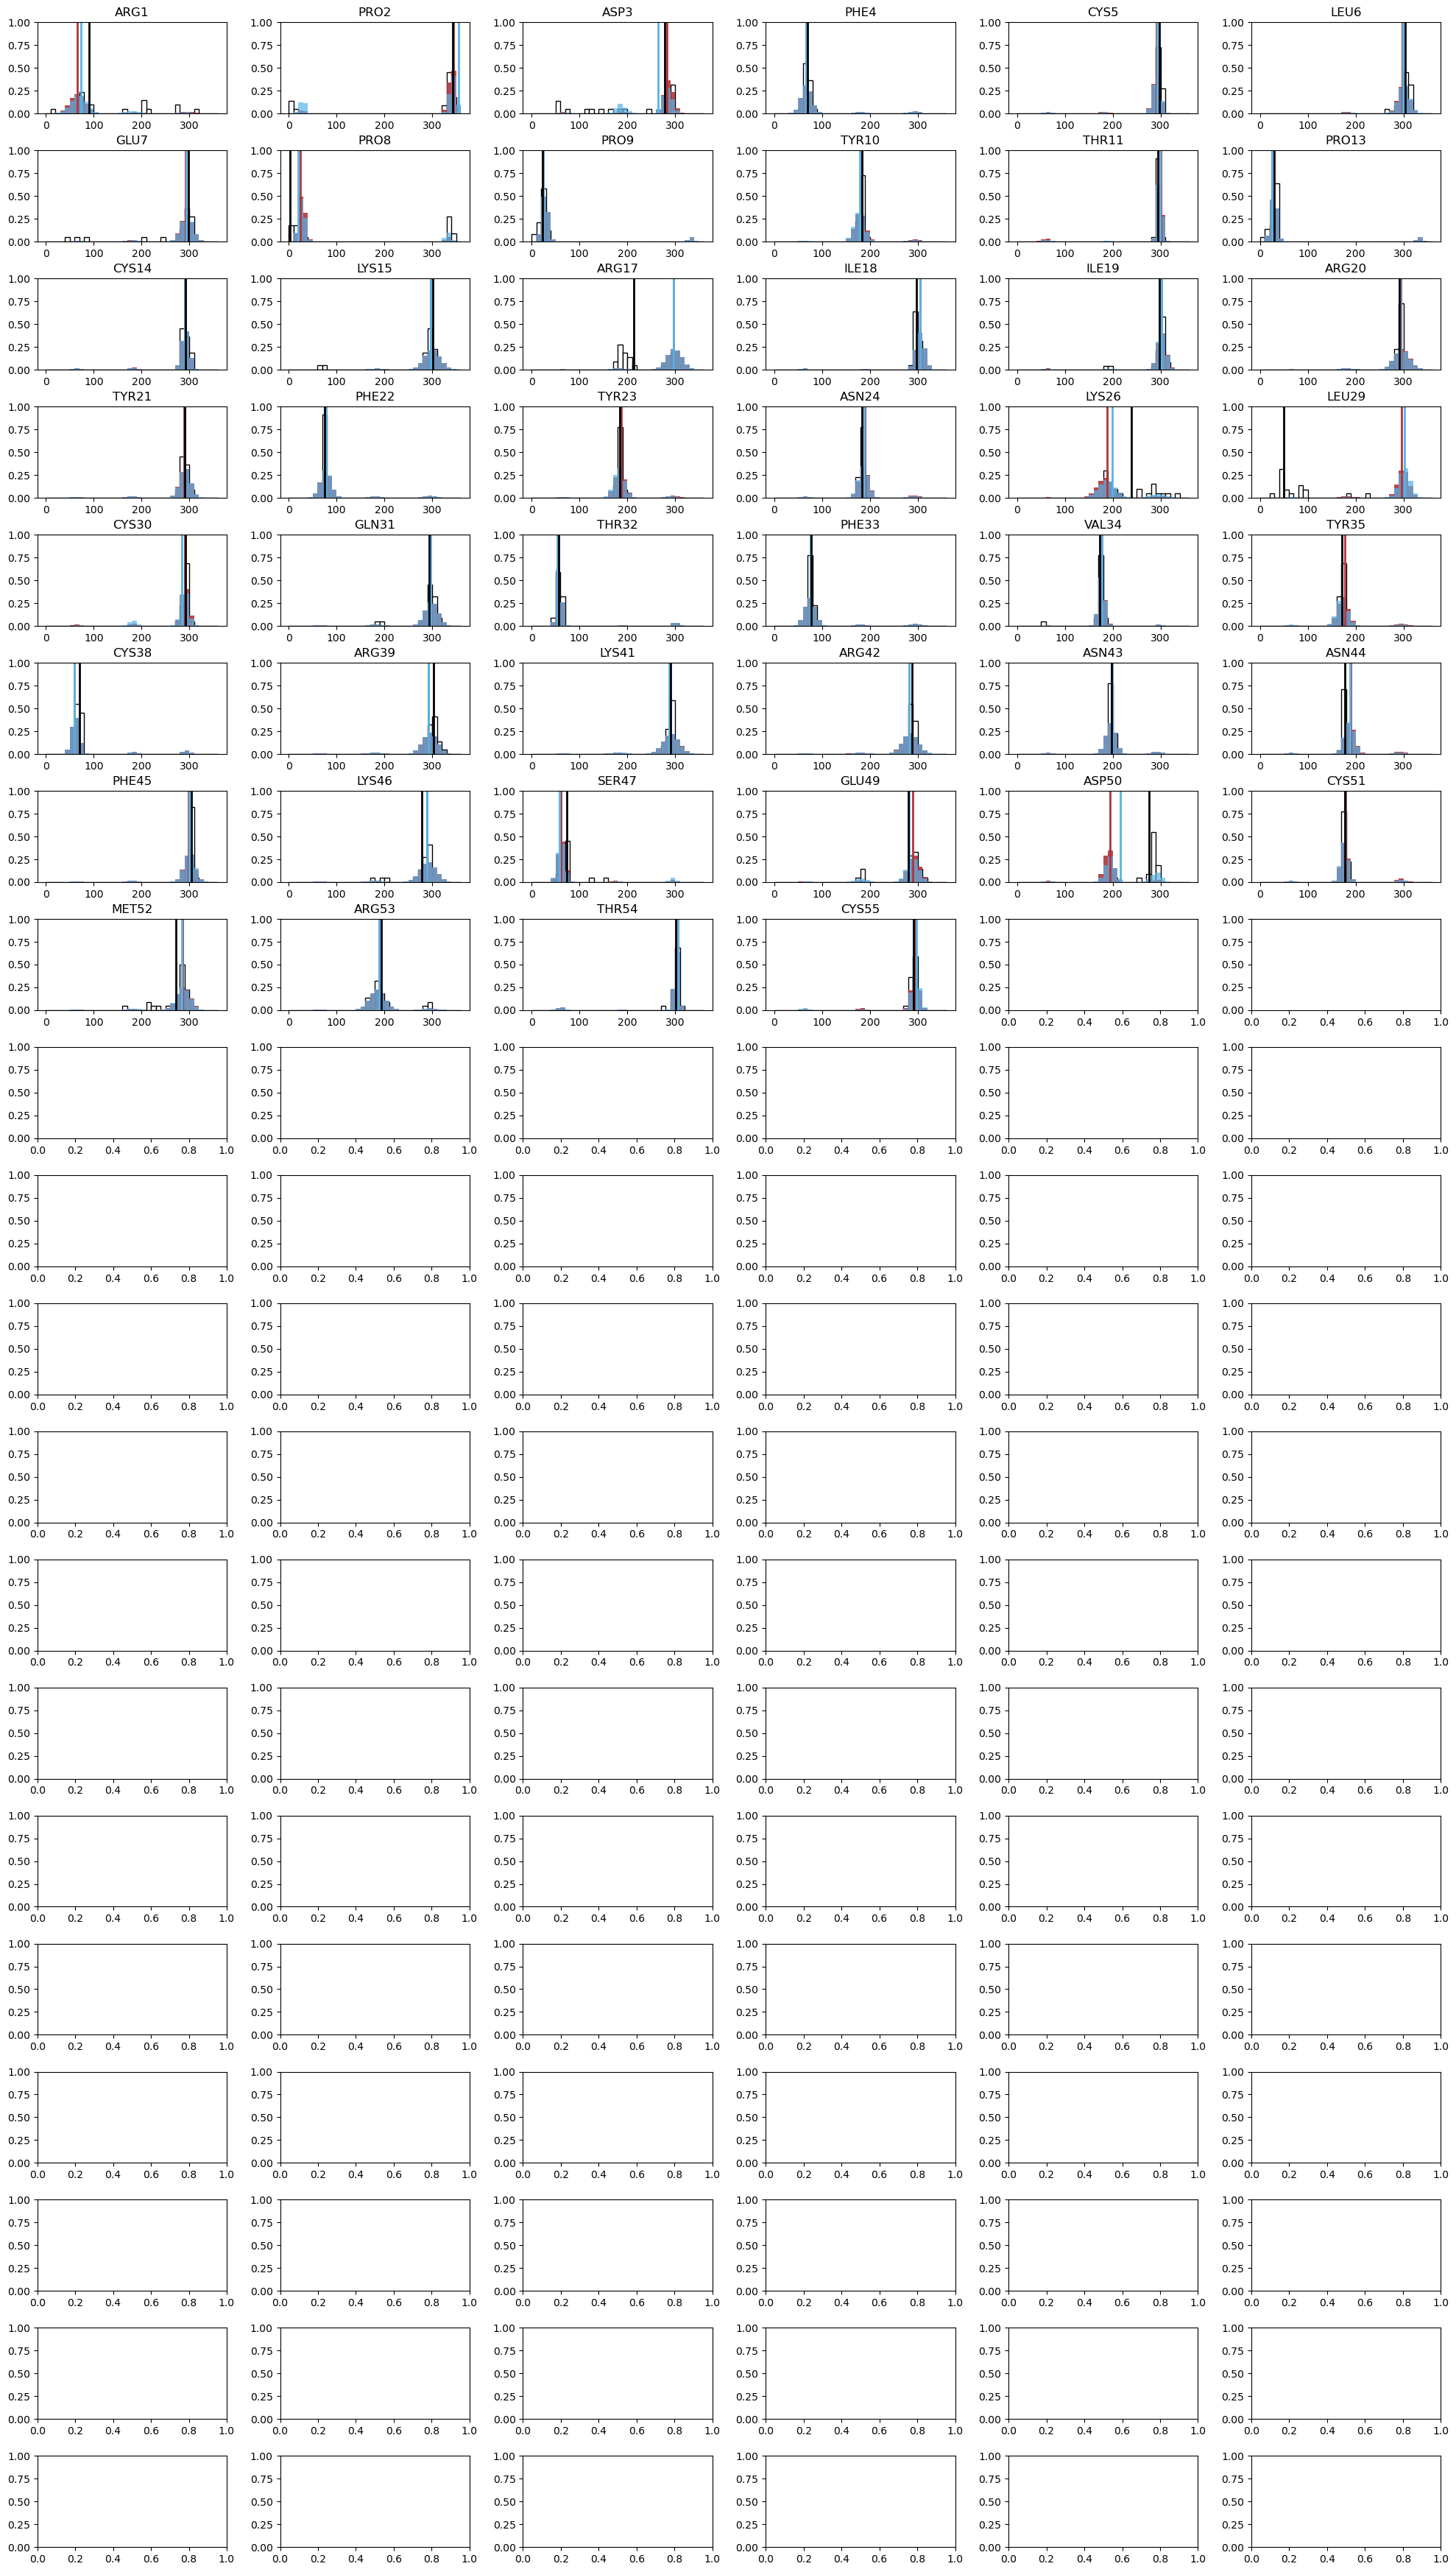

In [106]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(20,6,figsize=(20,35))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
            axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=2)


            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/bpti_rewe_vs_prior_on_pdb_ensemble.pdf',dpi=500)

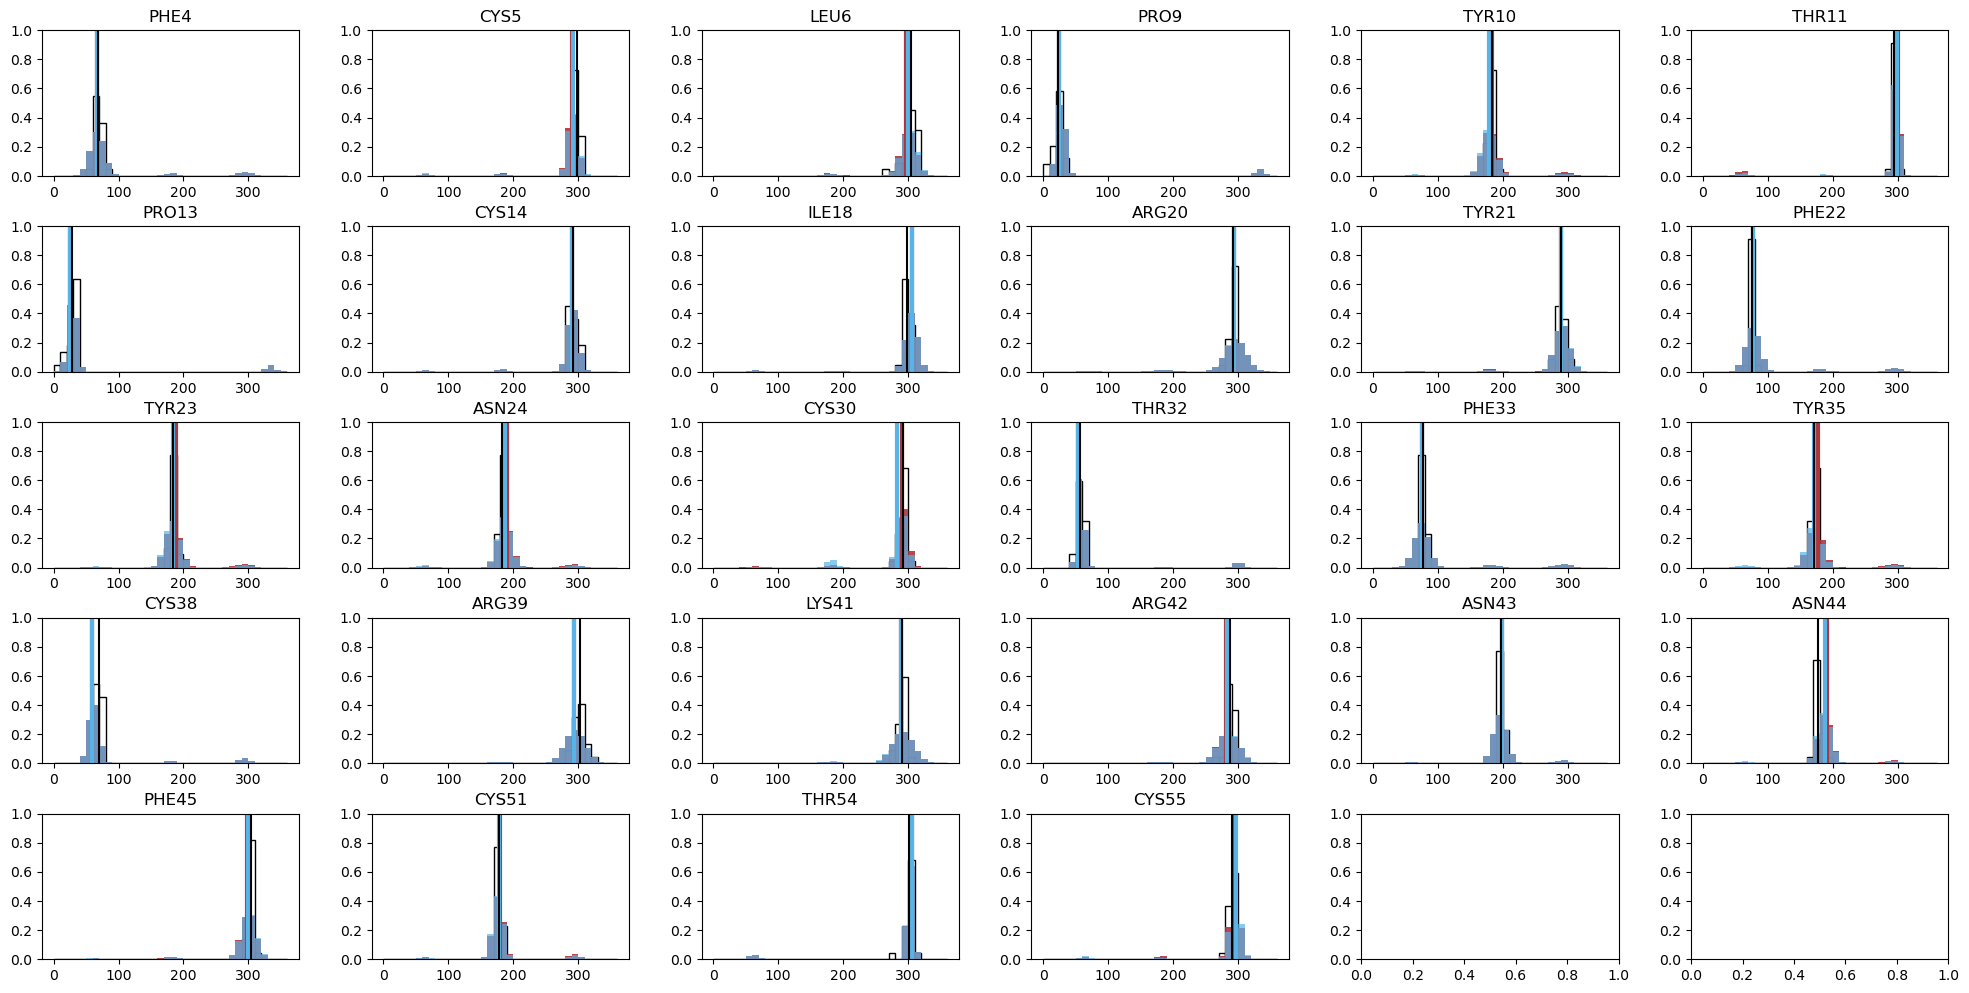

In [107]:
###Fig S9

x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(5,6,figsize=(20,10))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)

is_fixed={}


for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True
            

for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            if is_fixed[res]:
                axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
                axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
                axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
                
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=3)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=3)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=1.5)
    
    
                axs[idx_ax].set_ylim(0,1)
                axs[idx_ax].set_title(res)
                
                idx_ax+=1

#plt.savefig('../figures/bpti_rewe_vs_prior_on_pdb_ensemble_fixed.pdf',dpi=500)

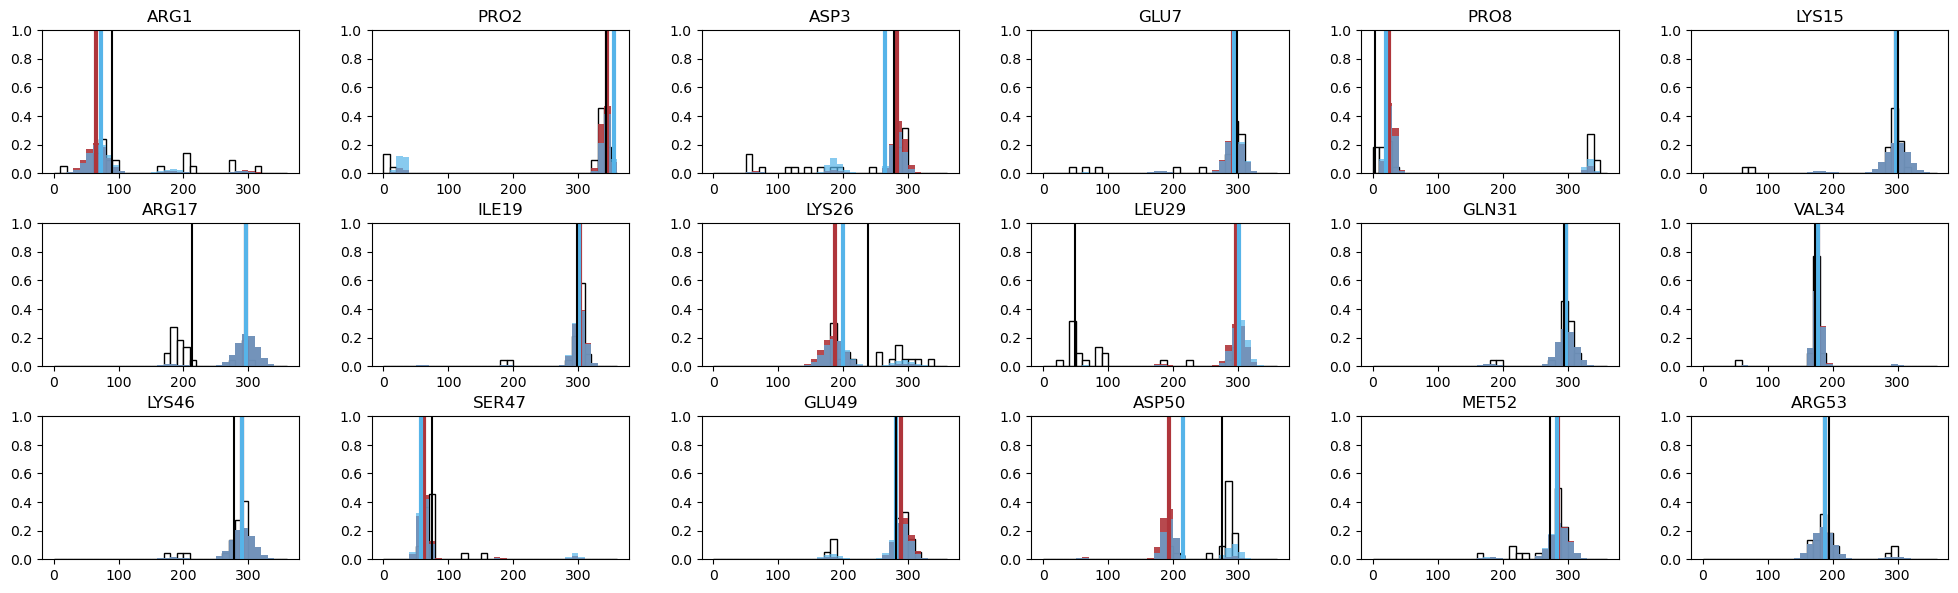

In [108]:
###Fig S9

x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(3,6,figsize=(20,6))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)

is_fixed={}


for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True
            

for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            if not is_fixed[res]:
                axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
                axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
                axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
                
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=3)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=3)
                axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=1.5)
    
    
                axs[idx_ax].set_ylim(0,1)
                axs[idx_ax].set_title(res)
                
                idx_ax+=1

#plt.savefig('../figures/bpti_rewe_vs_prior_on_pdb_ensemble_multi.pdf',dpi=500)

In [109]:
js_re=[]
js_prior=[]
js_top8000=[]
js_af2=[]
js_MD=[]

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        js_MD.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_re.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
        js_prior.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
        js_top8000.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
        js_af2.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

In [110]:
is_fixed={}

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        red_pop=rot_pop_rebinned_to_three(pdb_ensemble_angles_distr[res])
        if np.count_nonzero(red_pop)>1:
            is_fixed[res]=False
        else:
            is_fixed[res]=True

js_re_fixed=[]
js_MD_fixed=[]
js_prior_fixed=[]
js_top8000_fixed=[]
js_af2_fixed=[]

js_re_multi=[]
js_MD_multi=[]
js_prior_multi=[]
js_top8000_multi=[]
js_af2_multi=[]

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        if is_fixed[res]:
            js_MD_fixed.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_re_fixed.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
            js_prior_fixed.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
            js_top8000_fixed.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
            js_af2_fixed.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

        else:
            js_MD_multi.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
            js_re_multi.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
            js_prior_multi.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
            js_top8000_multi.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
            js_af2_multi.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))


In [111]:
print('All(tot: ',len(js_top8000))
print('js_af2 - sum:',np.sum(js_af2),' mean: ', np.mean(js_af2),'std',np.std(js_af2))
print('js_top8000 - sum:',np.sum(js_top8000),' mean: ', np.mean(js_top8000),'std',np.std(js_top8000))
print('js_prior - sum:',np.sum(js_prior),' mean: ', np.mean(js_prior),'std',np.std(js_prior))
print('js_re - sum:',np.sum(js_re),' mean: ', np.mean(js_re),'std',np.std(js_re))
print('js_MD - sum:',np.sum(js_MD),' mean: ', np.mean(js_MD),'std',np.std(js_MD))

All(tot:  46
js_af2 - sum: 26.112440046378836  mean:  0.5676617401386703 std 0.16368729821172598
js_top8000 - sum: 25.408866170553836  mean:  0.5523666558816052 std 0.10100547960707242
js_prior - sum: 18.3839201300964  mean:  0.3996504376107913 std 0.10869623857466999
js_re - sum: 18.223693920310954  mean:  0.39616725913719464 std 0.10172658285972754
js_MD - sum: 18.93485648807011  mean:  0.4116273149580459 std 0.12452459140230177


In [112]:
print('Fixed (tot: ',len(js_top8000_fixed))
print('js_af2 - sum:',np.sum(js_af2_fixed),' mean: ', np.mean(js_af2_fixed),'std',np.std(js_af2_fixed))
print('js_top8000 - sum:',np.sum(js_top8000_fixed),' mean: ', np.mean(js_top8000_fixed),'std',np.std(js_top8000_fixed))
print('js_prior - sum:',np.sum(js_prior_fixed),' mean: ', np.mean(js_prior_fixed),'std',np.std(js_prior_fixed))
print('js_re - sum:',np.sum(js_re_fixed),' mean: ', np.mean(js_re_fixed),'std',np.std(js_re_fixed))
print('js_MD - sum:',np.sum(js_MD_fixed),' mean: ', np.mean(js_MD_fixed),'std',np.std(js_MD_fixed))

Fixed (tot:  28
js_af2 - sum: 15.052547931460923  mean:  0.5375909975521759 std 0.1820218948660577
js_top8000 - sum: 16.673475664226356  mean:  0.5954812737223698 std 0.08950429094821119
js_prior - sum: 10.46009012656222  mean:  0.3735746473772221 std 0.08608100453000994
js_re - sum: 10.42753748999722  mean:  0.37241205321418647 std 0.08329997223085137
js_MD - sum: 10.896636535365749  mean:  0.38916559054877675 std 0.13200820702787333


In [113]:
print('Multi (tot: ',len(js_top8000_multi))
print('js_af2 - sum:',np.sum(js_af2_multi),' mean: ', np.mean(js_af2_multi),'std',np.std(js_af2_multi))
print('js_top8000 - sum:',np.sum(js_top8000_multi),' mean: ', np.mean(js_top8000_multi),'std',np.std(js_top8000_multi))
print('js_prior- sum:',np.sum(js_prior_multi),' mean: ', np.mean(js_prior_multi),'std',np.std(js_prior_multi))
print('js_re - sum:',np.sum(js_re_multi),' mean: ', np.mean(js_re_multi),'std',np.std(js_re_multi))
print('js_MD - sum:',np.sum(js_MD_multi),' mean: ', np.mean(js_MD_multi),'std',np.std(js_MD_multi))

Multi (tot:  18
js_af2 - sum: 11.059892114917913  mean:  0.6144384508287729 std 0.1154948791328075
js_top8000 - sum: 8.73539050632748  mean:  0.4852994725737489 std 0.07887258225042551
js_prior- sum: 7.923830003534185  mean:  0.4402127779741214 std 0.12634869073934102
js_re - sum: 7.796156430313735  mean:  0.43311980168409636 std 0.11579517358570601
js_MD - sum: 8.038219952704361  mean:  0.4465677751502423 std 0.10253960537699403


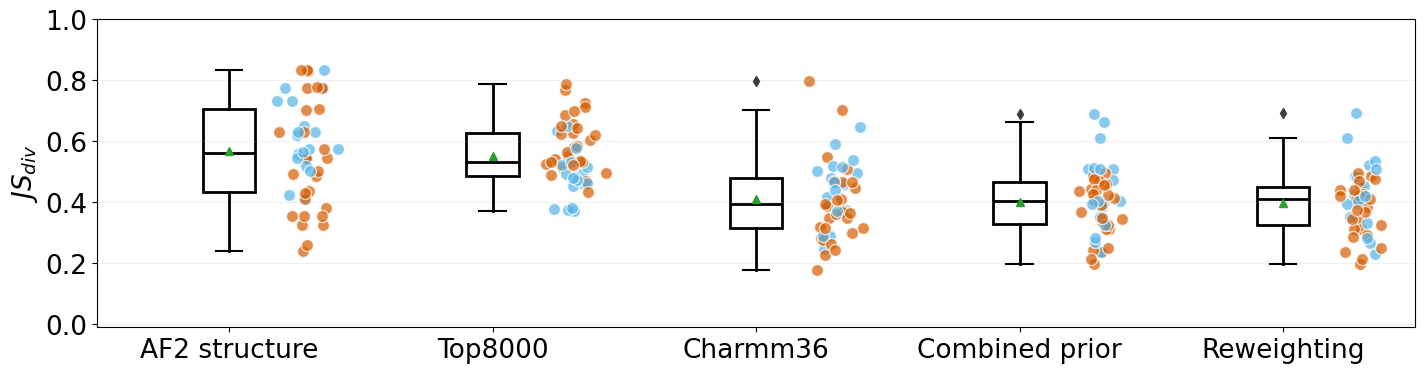

In [114]:
#Fig S7c

plot_boxplot_with_points(js_af2,js_top8000,js_MD,js_prior,js_re,labels=['AF2 structure','Top8000','Charmm36','Combined prior','Reweighting'],colors=['#d55c00' if val else '#56b4e9' for val in list(is_fixed.values())],width=17,labelsize=19,height=4)
plt.savefig('../figures/bpti_chi1_js_all_and_ensemble_boxplots_points.pdf')

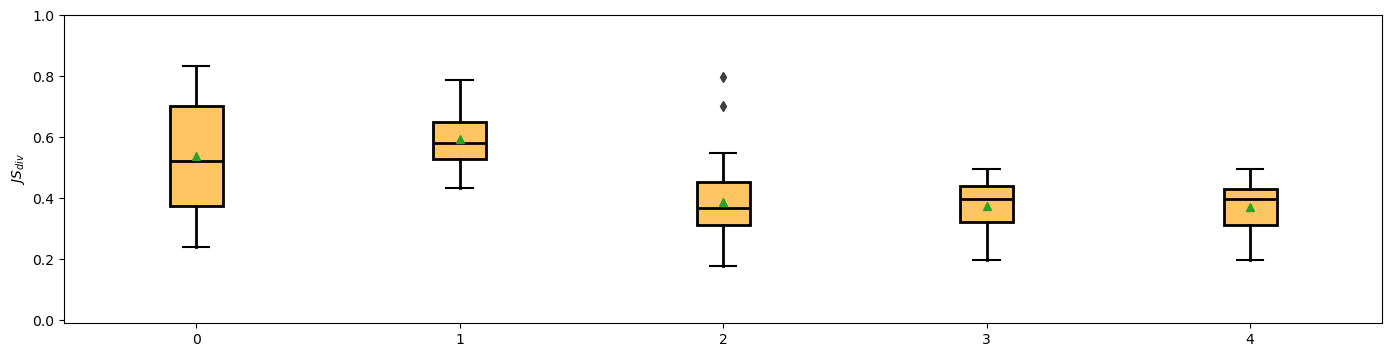

In [115]:
#Fig S7c

plot_boxplot(js_af2_fixed,js_top8000_fixed,js_MD_fixed,js_prior_fixed,js_re_fixed,box_color='#ffc563',width=17,height=4)
plt.savefig('../figures/bpti_chi1_js_fixed_boxplots_points.pdf')

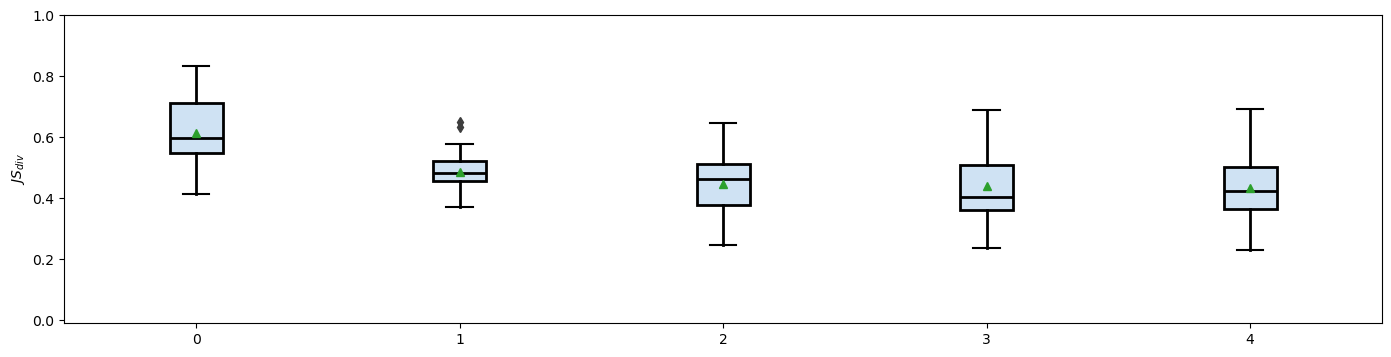

In [116]:
#Fig S7c

plot_boxplot(js_af2_multi,js_top8000_multi,js_MD_multi,js_prior_multi,js_re_multi,box_color='#cfe2f3',width=17,height=4)
plt.savefig('../figures/bpti_chi1_js_multi_boxplots_points.pdf')

### chi2

In [117]:
chi_sel='chi2'

In [118]:
layer_chi=4
angles_collected=[]

input_file='../data/af2chi_data/af2chi_runs_ILDNproteins/BPTI/output/5PTI_1_Chain_A_TRYPSIN_INHIBITOR_Bos_taurus__9913__rank_001_sc_angles.npy'

angles_npy=np.load(input_file,allow_pickle=True)

angles_appended=(circmean(np.arctan2(angles_npy[-1][:,layer_chi,0],angles_npy[-1][:,layer_chi,1]).reshape(-1,1),low=0,high=2*np.pi,axis=1))
angles_appended=np.array(angles_appended)

In [119]:
pdb_ensemble_angles=all_chis_pdb_ensemble[chi_sel]

prior_distributions=all_chis_priori[chi_sel]

reweighted_distributions=all_chis_fitted[chi_sel]

MD_ensemble_angles=all_chis_MD_ensemble[chi_sel]

In [120]:
## emove pro chi2 - not predicted by top8000
pdb_ensemble_angles = {key: value for key, value in pdb_ensemble_angles.items() if 'PRO' not in key}


In [121]:
struct_angles={}
struct_distributions={}
for res in pdb_ensemble_angles.keys():
    if res[:3] !='PRO':

        struct_angles[res]=np.rad2deg(angles_appended[int(res[3:])-1])
        struct_distributions[res]= gaussian(dihedral_angles, 2.5, struct_angles[res] , 1.25)

In [122]:
pdb_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys():
    
    pdb_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in pdb_ensemble_angles[key]]
    
    pdb_ensemble_angles_distr[key]=np.histogram(pdb_degr_conv,bins=x_range)[0]/len(pdb_degr_conv)

In [123]:
MD_ensemble_angles_distr={}

for key in pdb_ensemble_angles.keys(): ##chi fr chi2
    
    MD_degr_conv = [np.rad2deg(circmean(ang,np.deg2rad(-5),np.deg2rad(355))) for ang in MD_ensemble_angles[key]]
    
    MD_ensemble_angles_distr[key]=np.histogram(MD_degr_conv,bins=x_range)[0]/len(MD_degr_conv)

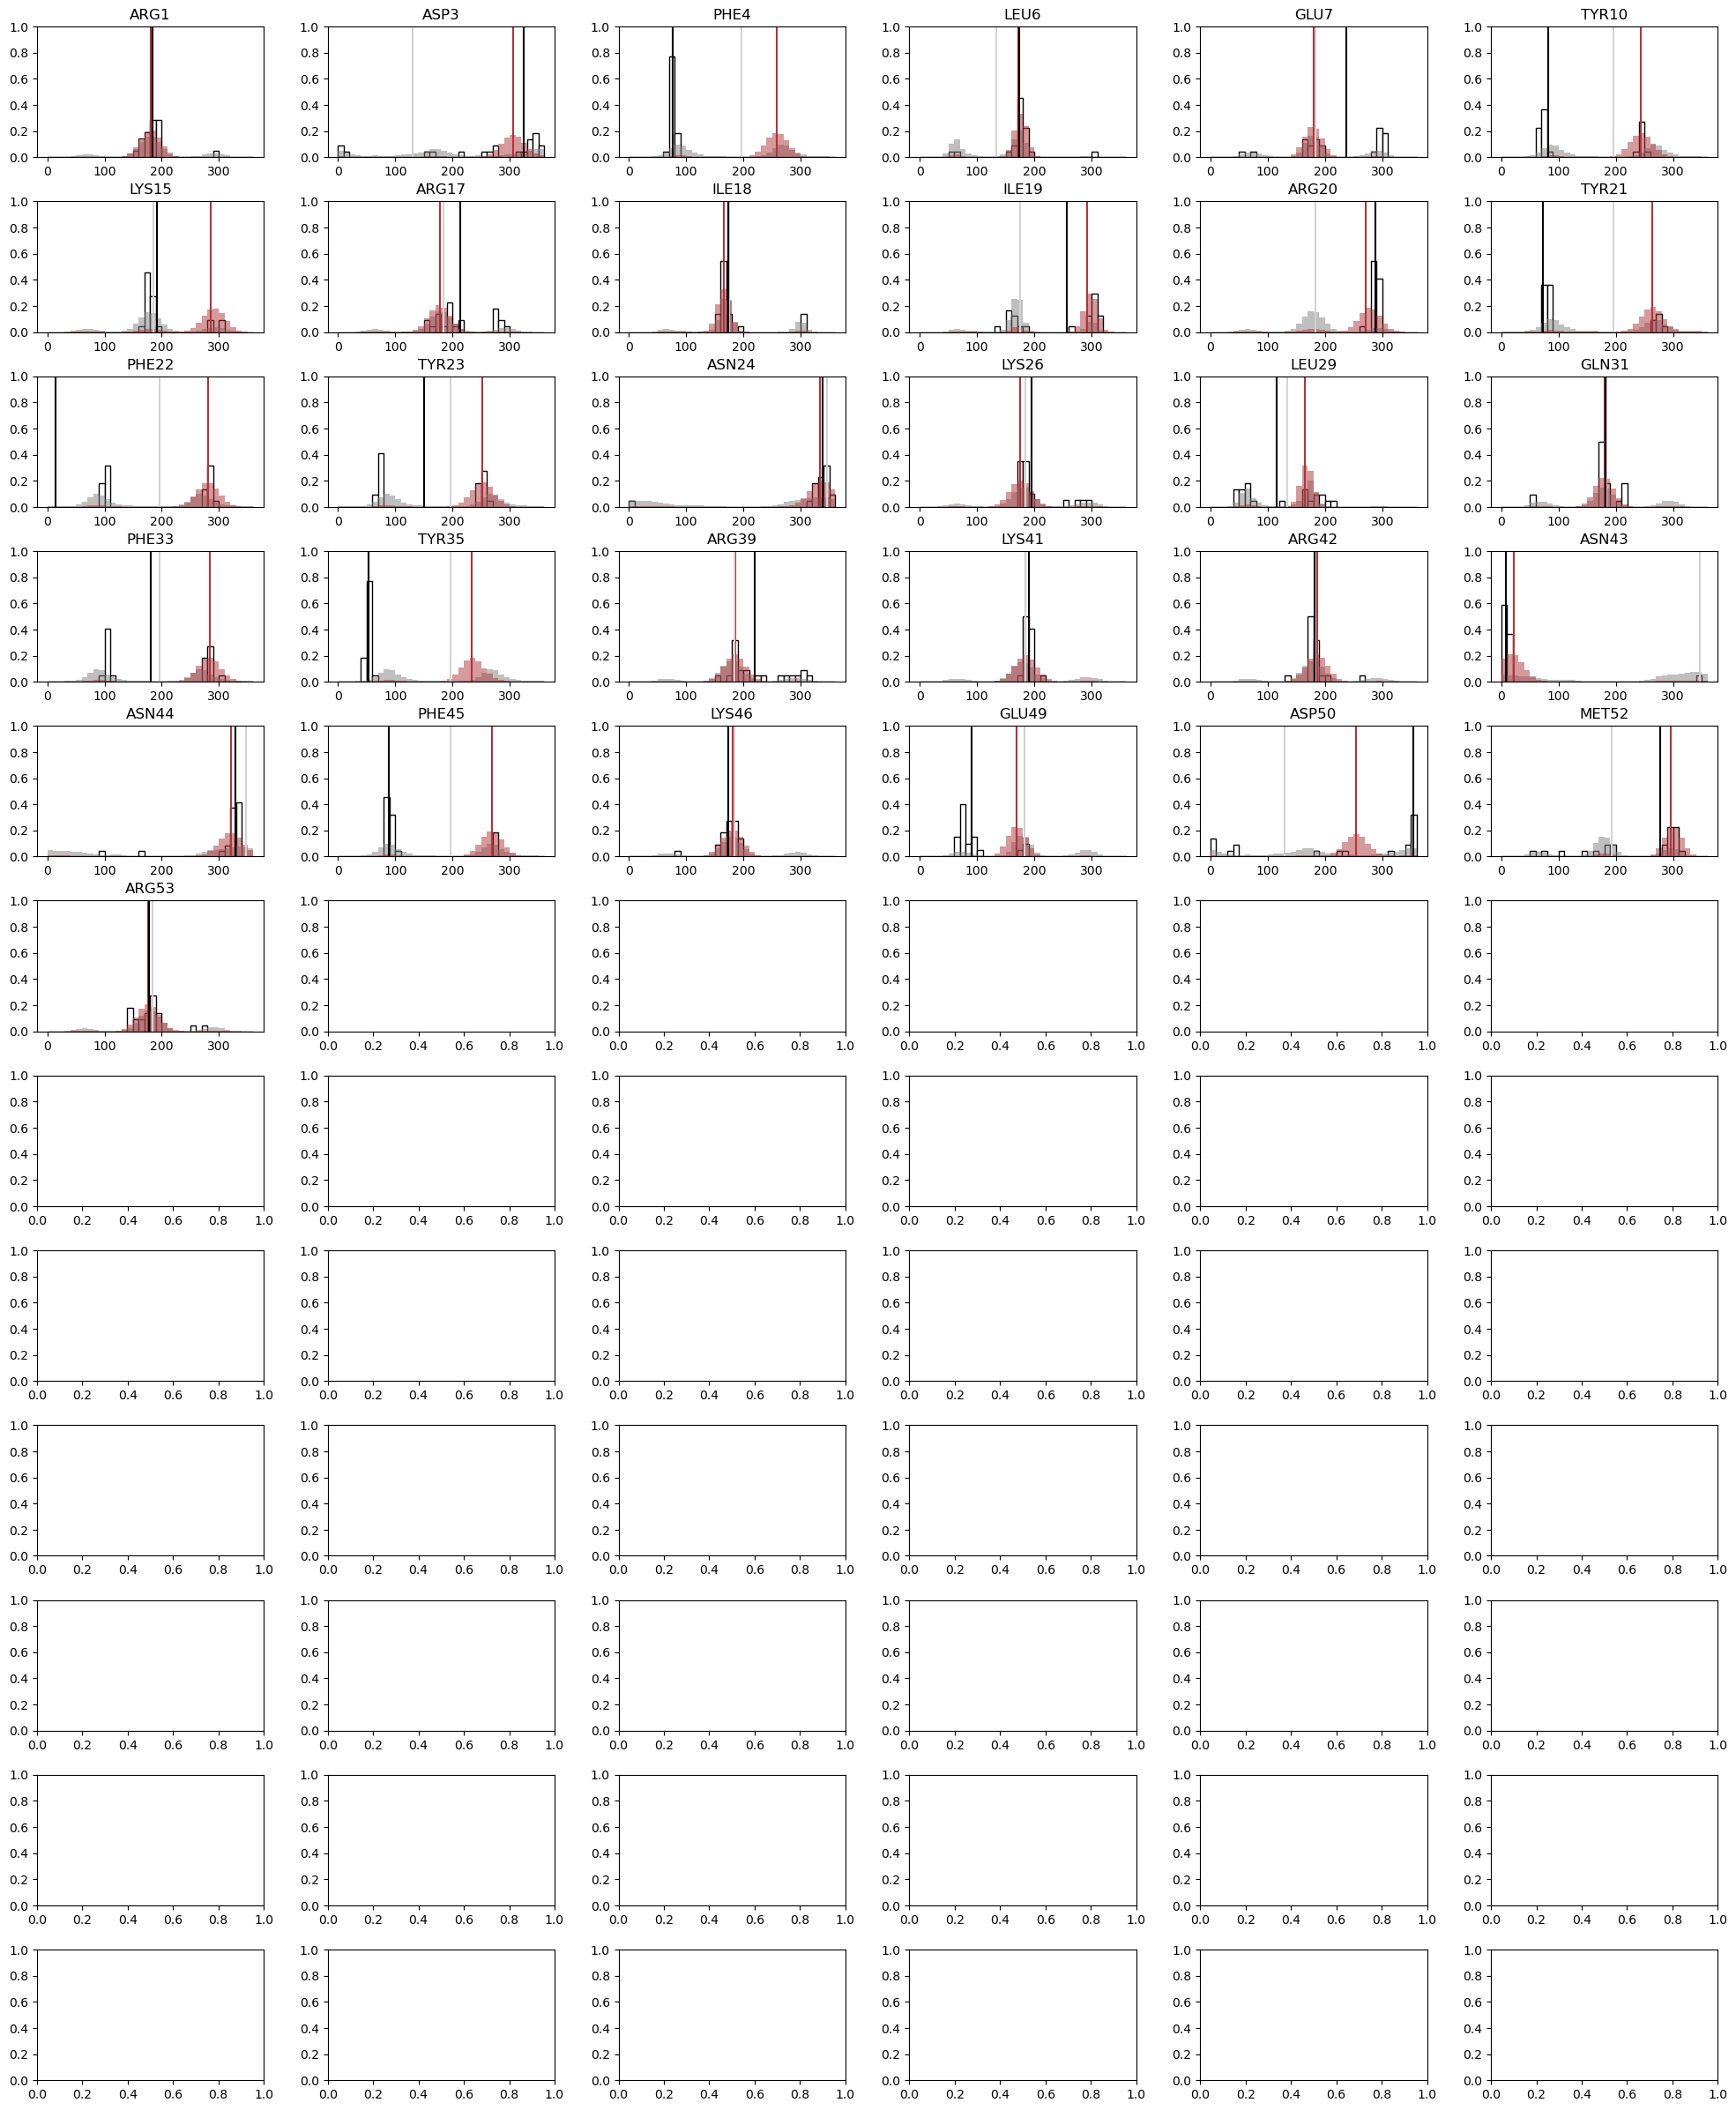

In [124]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(12,6,figsize=(20,24))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
colors=['#56b4e9','#d55c00','#009e74','#f0e442','#000fff']
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.5)
            axs[idx_ax].bar(x,top8000_prior[res[:3]+'_'+chi_sel].values,color='gray',width=10,zorder=-10,alpha=0.5)
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=top8000_prior[res[:3]+'_'+chi_sel].values))), color='lightgray')
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k')

            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/bpti_prior_vs_top8000_on_pdb_ensemble_chi2.pdf',dpi=500)

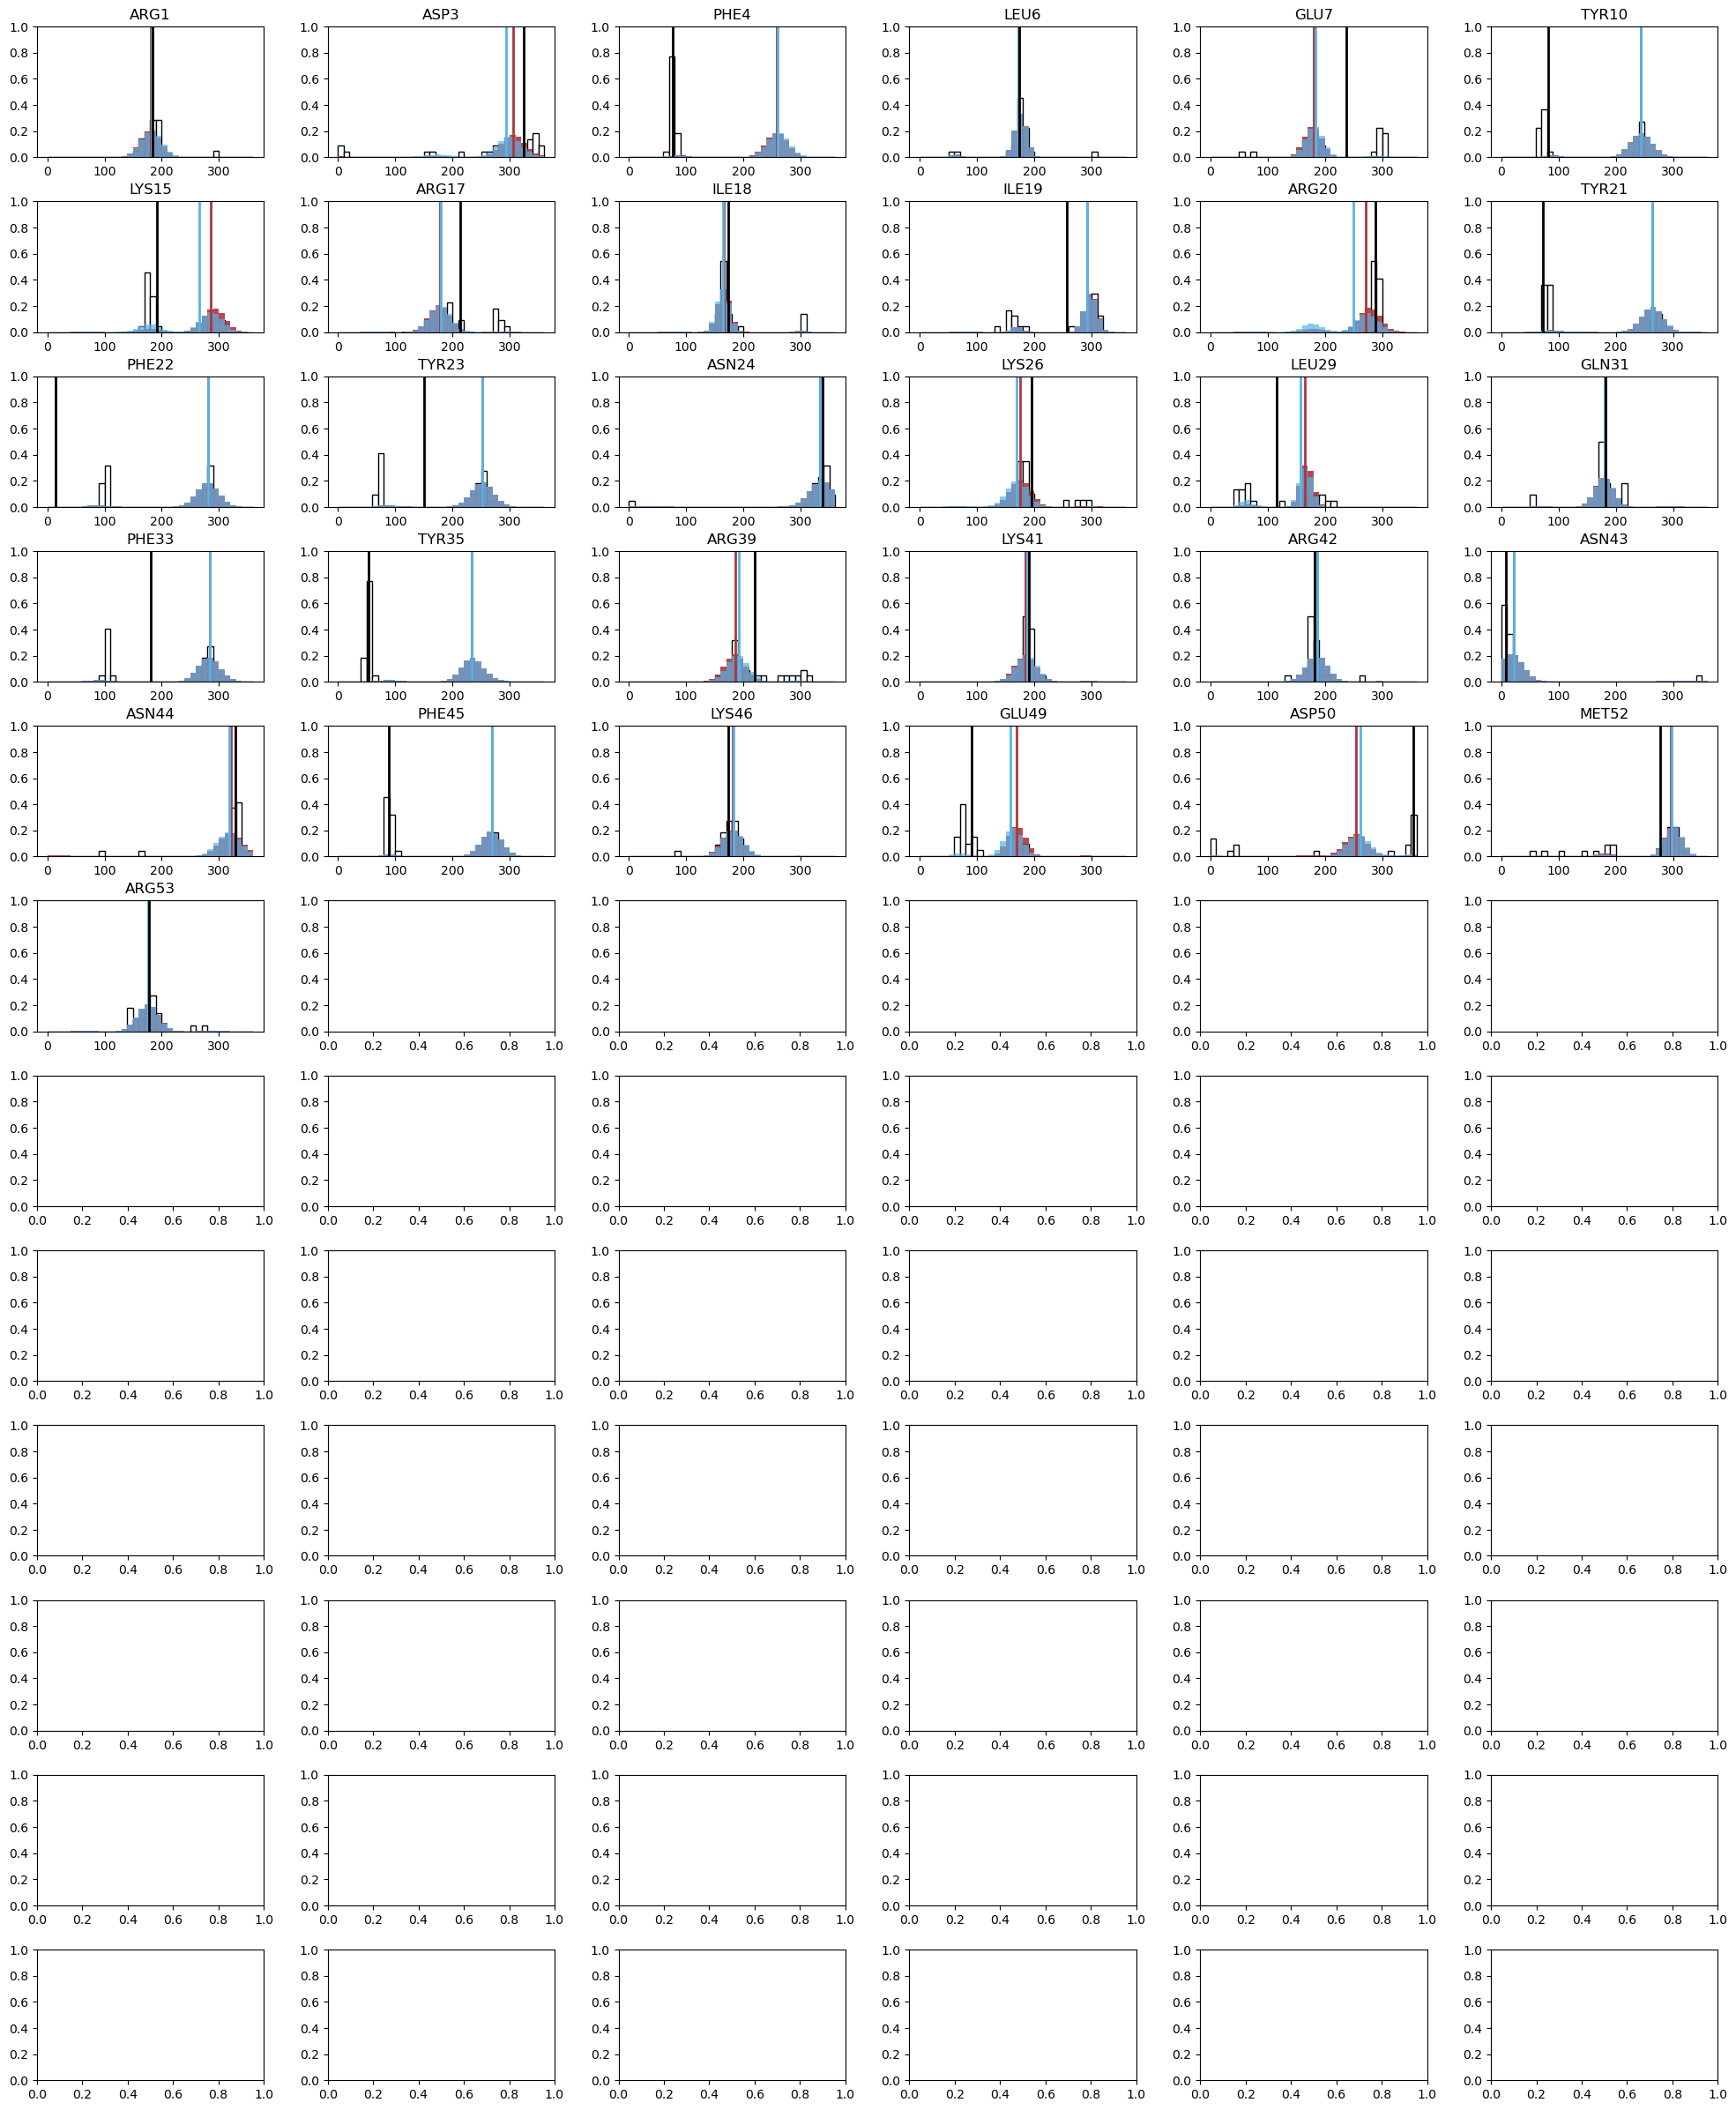

In [125]:
x=[i for i in range(5,360,10)]
fig,ax=plt.subplots(12,6,figsize=(20,24))
fig.tight_layout(pad=1.5)
idx_ax=0
axs=ax.reshape(-1)
for idx,res in enumerate(reweighted_distributions.keys()):
        if res in pdb_ensemble_angles_distr.keys():
            axs[idx_ax].bar(x,pdb_ensemble_angles_distr[res],color='#FFFFFF',edgecolor='k',width=10,zorder=-20)
            axs[idx_ax].bar(x,prior_distributions[res],color='#AF353B',width=10,alpha=0.9,zorder=-10)
            axs[idx_ax].bar(x,reweighted_distributions[res],color='#56b4e9',width=10,alpha=0.7)  
            
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=prior_distributions[res]))), color='#AF353B',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=reweighted_distributions[res]))), color='#56b4e9',lw=2)
            axs[idx_ax].axvline(adjust_period_angle(np.rad2deg(circmean_weighted(np.deg2rad(x),weights=pdb_ensemble_angles_distr[res]))), color='k',lw=2)


            axs[idx_ax].set_ylim(0,1)
            axs[idx_ax].set_title(res)
            
            idx_ax+=1

#plt.savefig('../figures/bpti_rewe_vs_prior_on_pdb_ensemble_chi2.pdf',dpi=500)

In [126]:
js_re=[]
js_prior=[]
js_top8000=[]
js_af2=[]
js_MD=[]

for idx,res in enumerate(reweighted_distributions.keys()):
    if res in pdb_ensemble_angles_distr.keys():
        js_MD.append(jensenshannon(MD_ensemble_angles_distr[res],pdb_ensemble_angles_distr[res]))
        js_re.append(jensenshannon(reweighted_distributions[res],pdb_ensemble_angles_distr[res]))
        js_prior.append(jensenshannon(prior_distributions[res],pdb_ensemble_angles_distr[res]))
        js_top8000.append(jensenshannon(top8000_prior[res[:3]+'_'+chi_sel],pdb_ensemble_angles_distr[res]))
        js_af2.append(jensenshannon(struct_distributions[res],pdb_ensemble_angles_distr[res]))

In [127]:
print('All(tot: ',len(js_top8000))
print('js_af2 - sum:',np.sum(js_af2),' mean: ', np.mean(js_af2),'std',np.std(js_af2))
print('js_top8000 - sum:',np.sum(js_top8000),' mean: ', np.mean(js_top8000),'std',np.std(js_top8000))
print('js_prior - sum:',np.sum(js_prior),' mean: ', np.mean(js_prior),'std',np.std(js_prior))
print('js_re - sum:',np.sum(js_re),' mean: ', np.mean(js_re),'std',np.std(js_re))
print('js_MD - sum:',np.sum(js_MD),' mean: ', np.mean(js_MD),'std',np.std(js_MD))

All(tot:  31
js_af2 - sum: 20.21973190682237  mean:  0.6522494163491087 std 0.13957534609148603
js_top8000 - sum: 16.41939709849468  mean:  0.5296579709191832 std 0.10953471386097345
js_prior - sum: 16.003226566251882  mean:  0.5162331150403833 std 0.14316299462967547
js_re - sum: 15.94153269657202  mean:  0.5142429902120006 std 0.14052460552953244
js_MD - sum: 15.244277935556562  mean:  0.4917509011469859 std 0.12991377779188398


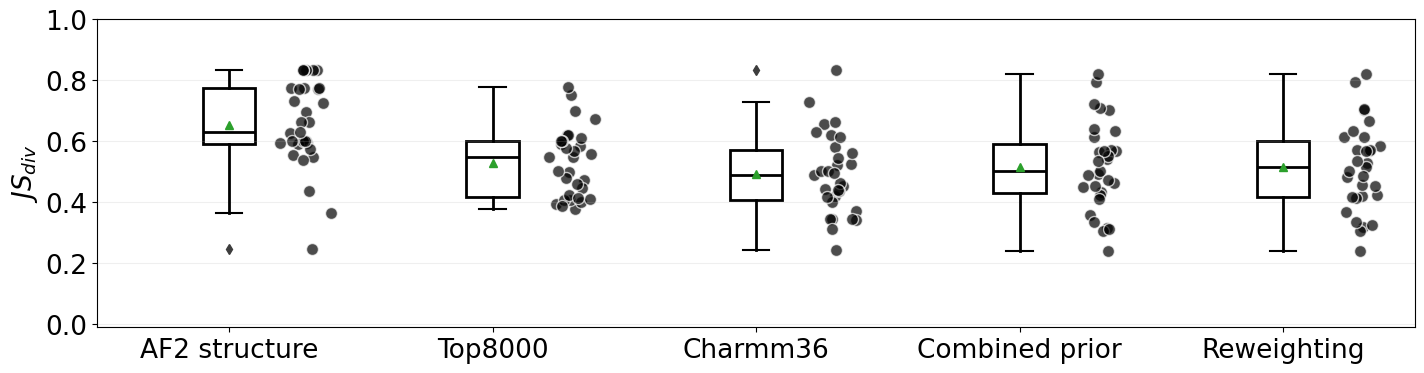

In [128]:
#Fig S7d

plot_boxplot_with_points(js_af2,js_top8000,js_MD,js_prior,js_re,labels=['AF2 structure','Top8000','Charmm36','Combined prior','Reweighting'],
                         colors=['k' if val else 'k' for val in list(is_fixed.values())],width=17,labelsize=19,height=4)
plt.savefig('../figures/bpti_chi2_js_all_and_ensemble_boxplots_points.pdf')